# COMMON SETUP

## DataFrame Merge List
A simple initialization of an empty list (`df_merge_list`) used to collect DataFrames that will be merged later in the processing pipeline.

In [7]:
df_merge_list = []

## DataFrame Display Function
A custom display function for pandas DataFrames that creates scrollable HTML tables with configurable settings for maximum rows and columns. It improves the visualization of large DataFrames in Jupyter notebooks by providing better control over how data is displayed.

In [8]:
from IPython.display import display, HTML
import pandas as pd
import numpy as np

def df_display(df):
    # df = pd.DataFrame(np.random.rand(40, 40), columns=[f"Column {i}" for i in range(40)])

    # Display the DataFrame as a scrollable HTML table
    display(HTML(df.to_html(max_rows=200, max_cols=20, notebook=True, na_rep='-', table_id='dataframe')))

## DataFrame Cache Management
The `read_df_from_cache_or_create()` function implements a caching mechanism for pandas DataFrames. It helps optimize performance by:
- Saving DataFrames to disk to avoid expensive recomputations
- Loading cached DataFrames when available
- Providing cache clearing functionality
- Managing cache storage in a '_cache' directory

In [9]:
import os
import pandas as pd

def read_df_from_cache_or_create(key: str, createdf = None) -> pd.DataFrame:
    """
    Returns a DataFrame either from cache or creates it using the provided function.
    The supplied function may load the dataframe from a remote database or it may create it in some other way.
    If createdf is None, any existing cache for the given key is cleared.

    Parameters:
    key (str): Cache key to identify the DataFrame
    createdf (callable, optional): Function that returns a pandas DataFrame. 
                                 If None, clears cache for the given key.
    
    Returns:
    pd.DataFrame: The cached or newly created DataFrame.
                 Returns None if createdf is None (cache clearing mode).
    """
    # Ensure cache directory exists
    os.makedirs('_cache', exist_ok=True)
    
    # Construct cache file path
    cache_path = os.path.join('_cache', f'{key}.df')
    
    # If createdf is None, clear cache and return
    if createdf is None:
        if os.path.exists(cache_path):
            try:
                os.remove(cache_path)
                print(f"Cache cleared for key: {key}")
            except Exception as e:
                print(f"Error clearing cache for key {key}: {e}")
        return None
    
    # Check if cache file exists
    if os.path.exists(cache_path):
        try:
            # Load from cache
            return pd.read_pickle(cache_path)
        except Exception as e:
            print(f"Error reading cache file: {e}")
            # If there's an error reading cache, proceed to create new DataFrame
    
    # Create new DataFrame
    df = createdf()
    
    # Validate that we got a DataFrame
    if not isinstance(df, pd.DataFrame):
        raise ValueError("createdf function must return a pandas DataFrame")
    
    try:
        # Save to cache
        df.to_pickle(cache_path)
    except Exception as e:
        print(f"Warning: Could not save to cache: {e}")
    
    return df

## DataFrame Analysis Utilities
The `analyze_distinct_elements()` function provides comprehensive analysis of DataFrame columns by:
- Counting unique values in each column
- Supporting column exclusion through an ignore list
- Converting values to strings for consistent handling
- Providing formatted output through the companion `print_distinct_elements()` function

In [10]:
import pandas as pd
from typing import List, Dict, Union, Optional

def analyze_distinct_elements(df: pd.DataFrame, ignore_columns: Optional[List[str]] = None) -> Dict[str, Dict[str, int]]:
    """
    Analyzes distinct elements and their counts for each column in a DataFrame.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame to analyze
    ignore_columns : List[str], optional
        List of column names to exclude from the analysis
        
    Returns:
    --------
    Dict[str, Dict[str, int]]
        A dictionary where:
        - Keys are column names
        - Values are dictionaries mapping unique values to their counts
        
    Example:
    --------
    >>> df = pd.DataFrame({
    ...     'A': [1, 2, 2, 3],
    ...     'B': ['x', 'y', 'x', 'z']
    ... })
    >>> analyze_distinct_elements(df)
    {
        'A': {1: 1, 2: 2, 3: 1},
        'B': {'x': 2, 'y': 1, 'z': 1}
    }
    """
    # Initialize ignore_columns if None
    ignore_columns = ignore_columns or []
    
    # Validate column names
    invalid_columns = [col for col in ignore_columns if col not in df.columns]
    if invalid_columns:
        raise ValueError(f"Columns not found in DataFrame: {invalid_columns}")
    
    # Get columns to analyze
    columns_to_analyze = [col for col in df.columns if col not in ignore_columns]
    
    # Initialize results dictionary
    results = {}
    
    # Analyze each column
    for column in columns_to_analyze:
        # Convert to string to handle mixed types and make results more readable
        value_counts = df[column].astype(str).value_counts().to_dict()
        results[column] = value_counts
        
    return results

def print_distinct_elements(analysis_results: Dict[str, Dict[str, int]]) -> None:
    """
    Prints the analysis results in a formatted way.
    
    Parameters:
    -----------
    analysis_results : Dict[str, Dict[str, int]]
        The results from analyze_distinct_elements function
    """
    for column, counts in analysis_results.items():
        print(f"\n{column}:")
        print("-" * (len(column) + 1))
        for value, count in counts.items():
            print(f"'{value}': {count}")


## Time Statistics Parser
The `TimeStats` class and `parse_time_output()` function work together to:
- Parse Unix-style time command output
- Extract user time, system time, elapsed time, and CPU usage
- Convert time formats (HH:MM:SS) to seconds
- Provide structured access to timing statistics through a dataclass

In [11]:
import re
from dataclasses import dataclass
from typing import Optional

@dataclass
class TimeStats:
    user_time: float      # User time in seconds
    system_time: float    # System time in seconds
    elapsed_time: str     # Elapsed time in HH:MM:SS format
    elapsed_seconds: float  # Elapsed time converted to seconds
    cpu_percentage: float # CPU percentage

def parse_time_output(time_str: str) -> Optional[TimeStats]:
    """
    Parse the output from Unix time command.
    
    Args:
        time_str: String output from time command (e.g., "4083.96user 9.53system 1:07:45elapsed 100%CPU")
    
    Returns:
        TimeStats object containing parsed values, or None if parsing fails
    """
    try:
        # Extract components using regex
        user_match = re.search(r'(\d+\.?\d*)user', time_str)
        system_match = re.search(r'(\d+\.?\d*)system', time_str)
        elapsed_match = re.search(r'(\d+:?\d*:?\d*)elapsed', time_str)
        cpu_match = re.search(r'(\d+)%CPU', time_str)
        
        if not all([user_match, system_match, elapsed_match, cpu_match]):
            return None
            
        # Parse elapsed time to seconds
        elapsed_parts = elapsed_match.group(1).split(':')
        if len(elapsed_parts) == 3:  # HH:MM:SS
            hours, minutes, seconds = map(float, elapsed_parts)
            elapsed_seconds = hours * 3600 + minutes * 60 + seconds
        elif len(elapsed_parts) == 2:  # MM:SS
            minutes, seconds = map(float, elapsed_parts)
            elapsed_seconds = minutes * 60 + seconds
        else:  # SS
            elapsed_seconds = float(elapsed_parts[0])
            
        return TimeStats(
            user_time=float(user_match.group(1)),
            system_time=float(system_match.group(1)),
            elapsed_time=elapsed_match.group(1),
            elapsed_seconds=elapsed_seconds,
            cpu_percentage=float(cpu_match.group(1))
        )
        
    except (AttributeError, ValueError) as e:
        return None

## Figure Generation Utilities
Contains two main functions for figure management:
1. `create_clean_generated()`: Creates and maintains a clean '_generated' directory for documentation
2. `save_optimized_png()`: Handles figure saving with optimization by:
   - Converting matplotlib figures to optimized PNG format
   - Supporting configurable DPI and compression settings
   - Using PIL for image optimization
   - Managing memory through proper buffer handling

In [12]:
def create_clean_generated():
    os.makedirs('doc/_generated', exist_ok=True)
    # if it exists empty the directory
    for filename in os.listdir('doc/_generated'):
        os.remove(f'doc/_generated/{filename}')

create_clean_generated()

In [13]:
import matplotlib.pyplot as plt
from PIL import Image
import io

def save_optimized_png(fig, filepath, dpi=150, optimize=True, compression=9):
    """
    Save a matplotlib figure as an optimized PNG file.
    
    Parameters:
    -----------
    fig : matplotlib.figure.Figure
        The figure to save
    filepath : str
        Path where the PNG file should be saved
    dpi : int, optional
        Resolution of the output image (default: 300)
    optimize : bool, optional
        Whether to optimize the PNG (default: True)
    compression : int, optional
        PNG compression level (0-9, default: 9)
    """
    # First save to a buffer at high quality
    buf = io.BytteBuffer()
    fig.savefig(buf, format='png', dpi=dpi, bbox_inches='tight')
    buf.seek(0)
    
    # Open the buffer with Pillow
    with Image.open(buf) as img:
        # Save with optimization
        img.save(
            filepath,
            'PNG',
            optimize=optimize,
            compress_level=compression
        )
    
    # Clear the buffer
    buf.close()

# RUN EXPERIMENTS

Each run may use a different dataset, LLM model, ranking method, ...

Many combinations are possible but one must be selective because...

One experiment may take several GPU hours even using RTX 4090's'

Queries and passages are processed by a local LLM -- time consuming!

We start jobs using commands from: https://github.com/ielab/llm-rankers

To keep GPU 100% busy we launch several GPUs in parallel.

    "google/flan-t5-large", # 4-5 jobs can share one 24GB GPU
    "google/flan-t5-xl", # 2-3 jobs can share one 24GB GPU
    "google/flan-t5-xxl" # mostly too big for 24GB GPU

Data was collected using ten RTX 4090 GPU servers rented for about a day.

Logs from servers are merged and loaded into dataframes below.

## BEIR EXPERIMENTS

In [14]:
import os
import subprocess
import sys
from pathlib import Path
from itertools import product
import multiprocessing as mp
from functools import partial

# Define the datasets, models, and ranking methods
datasets = [

    "scifact",           # ~5,183 documents, ~10MB
    "dbpedia-entity",    # ~4,600,000 entities, ~42GB

    "nfcorpus",          # ~3,633 abstracts, ~13MB
    "signal1m",          # ~1,000,000 documents, ~23GB
    
    "trec-covid",        # ~171,332 documents, ~5GB
    "webis-touche2020",  # ~382,545 documents, ~8GB
    
    "robust04",          # ~528,000 documents, ~2GB
    "trec-news",         # ~594,977 documents, ~9GB
]

model_names = [
    "google/flan-t5-large", # six per 24GB GPU
    "google/flan-t5-xl", # two per 24GB GPU
    "google/flan-t5-xxl" # too big for 24GB GPU
]
 
ranking_method_names = [
    "setwise", 
    "pairwise",
    "listwise", 
    "pointwise", 
]

sorting_method_names = {
    # "pairwise": ["heapsort", "bubblesort", "allpair"],
    "pairwise": ["heapsort", "bubblesort" ],
    "setwise": ["heapsort", "bubblesort"],
    "pointwise": ["yes_no", "qlm"],
    "listwise": ["likelihood", "generation"],
}

n_hits_list = [ 100 ]
top_k = 10

npar = 3 # Number of parallel processes
device_ids = [0]
# device_ids = [0, 1, 2, 3]

save_dir = "output_files/beir"

activate_script = str(Path("../lr_venv/bin/activate"))

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

def run_bm25(dataset, n_hits):
    pyserini_index = f"beir-v1.0.0-{dataset}"
    bm25_run_file = f"run.bm25.{dataset}.{n_hits}.txt"
    bm25_run_path = os.path.join(save_dir, bm25_run_file)

        # . {activate_script} && \
    if not os.path.exists(bm25_run_path):
        print(f"Running BM25 for dataset {dataset}...")
        bm25_command = f"""
        time python3 -m pyserini.search.lucene \
            --index {pyserini_index}.flat \
            --topics {pyserini_index}-test \
            --output {bm25_run_path} \
            --output-format trec \
            --batch 36 --threads 12 \
            --hits {n_hits*10} --bm25 --remove-query
        """
        process = subprocess.run(
            bm25_command, 
            shell=True, 
            executable='/bin/bash', 
            check=True,
            stderr=subprocess.PIPE,
            text=True
        )
        if process.stderr:
            print("stderr output:", process.stderr)
    return bm25_run_path

def run_experiment(args):
    n_hits, dataset, model_name, ranking_method, sorting_method, dummy_device_id, device_id = args
    model_savename = model_name.split("/")[-1]
    save_file = f"run.{model_savename}.{ranking_method}.{sorting_method}.{dataset}.n_hits={n_hits}.top_k={top_k}.txt"
    out_file = f"run.{model_savename}.{ranking_method}.{sorting_method}.{dataset}.n_hits={n_hits}.top_k={top_k}.out"
    err_file = f"run.{model_savename}.{ranking_method}.{sorting_method}.{dataset}.n_hits={n_hits}.top_k={top_k}.err"

    save_path = os.path.join(save_dir, save_file)
    out_path = os.path.join(save_dir, out_file)
    err_path = os.path.join(save_dir, err_file)
    
    if os.path.exists(save_path):
        print(f"File {save_path} exists.. skipping.")
        return

    bm25_run_path = run_bm25(dataset, n_hits)
    pyserini_index = f"beir-v1.0.0-{dataset}"

    if ranking_method in ["setwise", "pairwise"]:
            # . {activate_script} && \
        command = f"""
        [[ -f {out_path}.ok ]] || ( \
            CUDA_VISIBLE_DEVICES={device_id} time python3 run.py \
            run --model_name_or_path {model_name} \
                --tokenizer_name_or_path {model_name} \
                --run_path {bm25_run_path} \
                --save_path {save_path} \
                --pyserini_index {pyserini_index} \
                --hits {n_hits} \
                --query_length 32 \
                --passage_length 128 \
                --scoring generation \
                --device cuda \
            {ranking_method} --method {sorting_method} \
                            --k {top_k} \
                && touch {out_path}.ok \
        ) 2>&1 | tee {out_path}.all
        """
    elif ranking_method == "listwise":
            # . {activate_script} && \
        command = f"""
        [[ -f {out_path}.ok ]] || ( \
            CUDA_VISIBLE_DEVICES={device_id} time python3 run.py \
            run --model_name_or_path {model_name} \
                --tokenizer_name_or_path {model_name} \
                --run_path {bm25_run_path} \
                --save_path {save_path} \
                --pyserini_index {pyserini_index} \
                --hits {n_hits} \
                --query_length 32 \
                --passage_length 100 \
                --scoring {sorting_method} \
                --device cuda \
            listwise --window_size 4 \
                    --step_size 2 \
                    --num_repeat 5 \
                && touch {out_path}.ok \
        ) 2>&1 | tee {out_path}.all
        """
    elif ranking_method == "pointwise":
            # . {activate_script} && \
        command = f"""
        [[ -f {out_path}.ok ]] || ( \
            CUDA_VISIBLE_DEVICES={device_id} time python3 run.py \
            run --model_name_or_path {model_name} \
                --tokenizer_name_or_path {model_name} \
                --run_path {bm25_run_path} \
                --save_path {save_path} \
                --pyserini_index {pyserini_index} \
                --hits {n_hits} \
                --query_length 32 \
                --passage_length 128 \
                --device cuda \
            pointwise --method {sorting_method} \
                        --batch_size 32 \
                && touch {out_path}.ok \
        ) 2>&1 | tee {out_path}.all
        """
    else:
        print(f"INVALID RANKING METHOD: {ranking_method}. Skipping..")
        return

    print(f"Running command: {command}..")
    with open(out_path, "w") as f:
        with open(err_path, "w") as e:
            process = subprocess.run(
                command, 
                shell=True, 
                executable='/bin/bash', 
                check=True,
                stdout=f,
                stderr=e,
                text=True
            )
            # if process.stderr:
            #     print("stderr output:", process.stderr)

            if process.returncode != 0:
                print(f"Command failed with return code {process.returncode}")

# if __name__ == "__main__":
def launch_loop():
    default_device_id = 0

    combinations = []
    for n_hits in n_hits_list:
        for model_name in model_names:
            for ranking_method in ranking_method_names:
                for dataset in datasets:
                    for sorting_method in sorting_method_names[ranking_method]:
                        device_id = default_device_id
                        combinations.append((n_hits, dataset, model_name, ranking_method, sorting_method, device_id))

    # TODO update combinations so that each combination has a device_id assigned from device_ids
    combinations = [
        (*comb, device_id)
        for comb, device_id in zip(combinations, device_ids * (len(combinations) // len(device_ids)))
    ]
    
    # TODO output combinations to stdout for debugging
    print("Combinations:")
    for comb in combinations:
        print(comb)

    print(f"Running {len(combinations)} experiments..")

    with mp.Pool(npar) as pool:
        pool.map(run_experiment, combinations)

# launch_loop() UNCOMMENT TO RUN

# LOAD PUBLISHED METRICS

After using GPT 4o to OCR the tables from the author's paper and converting the data into an HTML table, we use the following code to extract the data and put them into dataframes.

## Zhuang_table2_ocr_0011()

In [15]:
from bs4 import BeautifulSoup
import pandas as pd
from pathlib import Path

def Zhuang_table2_ocr_0012():
    """
    Converts HTML table data into a DataFrame with columns matching our other tables.
    
    Args:
        html_content (str): HTML content containing the table data
        
    Returns:
        pandas.DataFrame: DataFrame with columns Source, LLM, Dataset, MainMethod, SubMethod, 
                         Parameters, Metric_Name, Metric_Value
    """

    file_path = Path("/home/lenny/repllmr/doc/Zhuang_table2_ocr_0012.html")
    with open(file_path, 'r') as f:
        html_content = f.read()

    soup = BeautifulSoup(html_content, 'html.parser')
    data = []
    
    # Extract metric names from header
    thead = soup.find('thead')
    header_rows = thead.find_all('tr')
    
    # Get metric names from second header row
    metrics = []
    for th in header_rows[1].find_all('th'):
        if th.text.startswith('Metric:'):
            metrics.append(th.text.replace('Metric:', '').strip())
    
    # Define column indices for both datasets
    trec_2019_indices = list(range(2, 7))  # Columns 3-7 for TREC DL 2019
    trec_2020_indices = list(range(7, 12))  # Columns 8-12 for TREC DL 2020
    
    # Find all rows in tbody
    tbody = soup.find('tbody')
    current_llm = None
    
    for row in tbody.find_all('tr'):
        # Check if this is an LLM header row
        colspan_cell = row.find('td', attrs={'colspan': '11'})
        if colspan_cell:
            current_llm = colspan_cell.text.strip().replace('LLM:', '').strip()
            continue
            
        cells = row.find_all('td')
        
        # Skip if this is a header row or we haven't found an LLM yet
        if not current_llm or len(cells) < 11:  # Ensure we have all columns
            continue
            
        method_full = cells[1].text.strip()
        
        # Skip empty method rows
        if not method_full:
            continue
            
        # Split method into main and sub methods
        main_method, sub_method = method_full.split('.') if '.' in method_full else (method_full, '')
        
        # Process metrics for TREC DL 2019
        for i, metric in enumerate(metrics):
            try:
                value = cells[trec_2019_indices[i]].text.strip()
                if value not in ['-', '']:
                    data.append({
                        'Source': 'ZhuangTable2',
                        'LLM': current_llm,
                        'Dataset': 'TREC DL 2019',
                        'MainMethod': main_method,
                        'SubMethod': sub_method,
                        'Parameters': 'none',
                        'Metric_Name': metric,
                        'Metric_Value': value
                    })
            except IndexError:
                continue
        
        # Process metrics for TREC DL 2020
        for i, metric in enumerate(metrics):
            try:
                value = cells[trec_2020_indices[i]].text.strip()
                if value not in ['-', '']:
                    data.append({
                        'Source': 'ZhuangTable2',
                        'LLM': current_llm,
                        'Dataset': 'TREC DL 2020',
                        'MainMethod': main_method,
                        'SubMethod': sub_method,
                        'Parameters': 'none',
                        'Metric_Name': metric,
                        'Metric_Value': value
                    })
            except IndexError:
                continue
    
    # Create DataFrame with specified columns
    columns = ['Source', 'LLM', 'Dataset', 'MainMethod', 'SubMethod', 
               'Parameters', 'Metric_Name', 'Metric_Value']
    
    df = pd.DataFrame(data, columns=columns)
    return df


Zhuang_table2_ocr_0012 = read_df_from_cache_or_create('Zhuang_table2_ocr_0012', Zhuang_table2_ocr_0012)

# Zhuang_table2_ocr_0011 = Zhuang_table2_ocr_0011()

print(Zhuang_table2_ocr_0012.info())

# print(Zhuang_table2_ocr_0011.shape)

df_merge_list.append(Zhuang_table2_ocr_0012)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Source        254 non-null    object
 1   LLM           254 non-null    object
 2   Dataset       254 non-null    object
 3   MainMethod    254 non-null    object
 4   SubMethod     254 non-null    object
 5   Parameters    254 non-null    object
 6   Metric_Name   254 non-null    object
 7   Metric_Value  254 non-null    object
dtypes: object(8)
memory usage: 16.0+ KB
None


## Zhuang_table3_ocr_0011()

In [16]:
from pathlib import Path
import pandas as pd
import re
from bs4 import BeautifulSoup
from io import StringIO

def Zhuang_table3_ocr_0011():
    """
    Converts HTML table data into a DataFrame with columns matching beir_metrics_measured_by_lesner format.
    
    Returns:
        pandas.DataFrame: DataFrame with columns Source, LLM, Dataset, MainMethod, SubMethod, 
                         Parameters, Metric_Name, Metric_Value
    """

    file_path = Path("/home/lenny/repllmr/doc/Zhuang_table3_ocr_0011.html")
    with open(file_path, 'r') as f:
        html_content = f.read()

    # Parse HTML
    soup = BeautifulSoup(html_content, 'html.parser')
    
    data = []
    
    # Find all h2 tags containing LLM names
    llm_sections = soup.find_all('h2')
    
    for section in llm_sections:
        # Extract LLM name
        llm_name = section.text.replace('LLM: ', '').strip()
        
        # Find the next table after this h2
        table = section.find_next('table')
        if not table:
            continue
            
        # Convert table to DataFrame
        df = pd.read_html(StringIO(str(table)))[0]
        
        # Get dataset names (excluding '#', 'Methods', and 'Avg')
        datasets = df.columns[2:-1].tolist()
        
        # Process each row
        for _, row in df.iterrows():
            method_full = row['Methods']
            
            # Split method into main and sub methods
            main_method, sub_method = method_full.split('.') if '.' in method_full else (method_full, '')
            
            # Create a row for each dataset
            for dataset in datasets:
                value = row[dataset]
                data_row = {
                    'Source': 'ZhuangTable3',
                    'LLM': llm_name,
                    'Dataset': dataset,
                    'MainMethod': main_method,
                    'SubMethod': sub_method,
                    'Parameters': 'none',
                    'Metric_Name': 'ndcg_cut_10',
                    'Metric_Value': str(value)
                }
                data.append(data_row)
    
    # Create DataFrame with specified columns
    columns = ['Source', 'LLM', 'Dataset', 'MainMethod', 'SubMethod', 
               'Parameters', 'Metric_Name', 'Metric_Value']
    
    df = pd.DataFrame(data, columns=columns)
    return df



Zhuang_table3_ocr_0011 = read_df_from_cache_or_create('Zhuang_table3_ocr_0011', Zhuang_table3_ocr_0011)

# Zhuang_table3_ocr_0011 = Zhuang_table3_ocr_0011()

# print(Zhuang_table3_ocr_0011.info())

# Zhuang_table3_ocr_0011

df_merge_list.append(Zhuang_table3_ocr_0011)


# LOAD MEASURED METRICS

## eval_measurements()

### v3

In [17]:
import subprocess
import pandas as pd
import re
import sys

def eval_measurements():
    command = """
        set -e
        cd /home/lenny/repllmr/llm-rankers-new

        # merge measurements from GPU hosts h0-h6
        echo "Processing h0-h6 files..."
        mkdir -p output_files/beir/
        find output_files_h0* \\( -name '*.txt' -o -name '*.txt.eval' -o -name '*.out.all' \\) | 
            grep -aiEv 'bm25' |
            xargs -I{} cp {} output_files/beir/

        # merge measurements from GPU hosts h11-h15
        echo "Processing h11-h15 files..."
        mkdir -p output_files2/beir/
        find output_files_h1* \\( -name '*.txt' -o -name '*.txt.eval' -o -name '*.out.all' \\) |
            grep -aiEv 'bm25' |
            xargs -I{} cp {} output_files2/beir/

        # create *.eval files for experiment metrics
        echo "Starting evaluation of datasets..."
        find output_files output_files2 -type f -name '*.txt' | grep flan | while read -r f; do
            dataset=$(echo "$f" | sed 's/\.n_hits=100\.top_k=10\./\./g' | 
                     perl -ne 'm{^.*\.(.*?)\.txt} && print "$1"')
            
            if [ ! -f "${f}.ek" ]; then
                echo "\\nProcessing dataset: $dataset"
                echo "File: $f"
                python3 -m pyserini.eval.trec_eval -c -m ndcg_cut.10 "beir-v1.0.0-${dataset}-test" "$f" | tee "${f}.eval"
                touch "${f}.ek"
            else
                echo "\\nSkipping already processed dataset: $dataset"
            fi
        done 2>&1 | tee beir_eval.log
    """
    
    try:
        # Use Popen instead of run to get real-time output
        process = subprocess.Popen(
            command,
            shell=True,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,  # Redirect stderr to stdout
            text=True,
            executable='/bin/bash',
            bufsize=1,  # Line buffered
            universal_newlines=True
        )

        # Print output in real-time
        for line in process.stdout:
            print(line, end='')  # end='' because the line already contains a newline
            sys.stdout.flush()  # Ensure output is displayed immediately

        # Wait for process to complete and get return code
        return_code = process.wait()
        
        if return_code != 0:
            raise subprocess.CalledProcessError(return_code, command)
            
    except subprocess.CalledProcessError as e:
        print(f"Error running command: {e}")
        return None
    except Exception as e:
        print(f"Error processing data: {e}")
        return None

# Uncomment to run:
# eval_measurements()

### v2

In [18]:
import subprocess
import pandas as pd
import re

def eval_measurements():
    command = """
        set -e
        cd /home/lenny/repllmr/llm-rankers-new

        # merge measurements from GPU hosts h0-h6
        mkdir -p output_files/beir/
        find output_files_h0* \\( -name '*.txt' -o -name '*.txt.eval' -o -name '*.out.all' \\) | 
            grep -aiEv 'bm25' |
            xargs -I{} cp {} output_files/beir/

        # merge measurements from GPU hosts h11-h15
        mkdir -p output_files2/beir/
        find output_files_h1* \\( -name '*.txt' -o -name '*.txt.eval' -o -name '*.out.all' \\) |
            grep -aiEv 'bm25' |
            xargs -I{} cp {} output_files2/beir/

        # create *.eval files for experiment metrics
        find output_files output_files2 -type f -name '*.txt' | grep flan | while read -r f; do
            dataset=$(echo "$f" | sed 's/\.n_hits=100\.top_k=10\./\./g' | 
                     perl -ne 'm{^.*\.(.*?)\.txt} && print "$1"')
            
            if [ ! -f "${f}.ek" ]; then
                echo "Processing dataset: $dataset, file: $f"
                python3 -m pyserini.eval.trec_eval -c -m ndcg_cut.10 "beir-v1.0.0-${dataset}-test" "$f" > "${f}.eval"
                touch "${f}.ek"
            fi
        done 2>&1 | tee beir_eval.log
    """
    
    try:
        result = subprocess.run(command, 
                              shell=True, 
                              capture_output=True, 
                              text=True,
                              executable='/bin/bash')  # Explicitly use bash
        
        if result.returncode != 0:
            print(f"Command failed with return code {result.returncode}")
            print(f"Stdout: {result.stdout}")
            print(f"Stderr: {result.stderr}")
            raise subprocess.CalledProcessError(
                result.returncode, 
                command, 
                result.stdout, 
                result.stderr
            )
            
        print(result.stdout)
        print(result.stderr)
        
    except subprocess.CalledProcessError as e:
        print(f"Error running command: {e}")
        print(f"Stderr: {e.stderr}")
        return None
    except Exception as e:
        print(f"Error processing data: {e}")
        return None

# Uncomment to run:
# eval_measurements()

### v1

In [19]:
import subprocess
import pandas as pd
import re

def eval_measurements():
    command = """
        (
            cd /home/lenny/repllmr/llm-rankers-new

            # merge measurements from GPU hosts h0-h6
            mkdir -p output_files/beir/ || true
            (
                find output_files_h0* -name '*.txt' 
                find output_files_h0* -name '*.txt.eval' 
                find output_files_h0* -name '*.txt' \
                    | perl -pe's{.txt$}{.out.all}' 
            ) \
                | egrep -avi bm25 \
                | xargs -i cp {} output_files/beir/

            
            # merge measurements from GPU hosts h11-h15
            mkdir -p output_files2/beir/  || true
            (
                find output_files_h1* -name '*.txt' 
                find output_files_h1* -name '*.txt.eval' 
                find output_files_h1* -name '*.txt'  \
                    | perl -pe's{.txt$}{.out.all}' 
            ) \
                | egrep -avi bm25 \
                | xargs -i cp {} output_files2/beir/

            # create *.eval files which we read for experiment metrics             
            (
                find output_files output_files2 \
                | egrep flan \
                | egrep '.txt$' \
                | while read f ; do
                    #  dataset=$(echo $f | perl -ne'm{^.*\.(.*?)\.txt} && print "$1\n";')
                    dataset=$(echo $f | perl -pe's{\.n_hits=100.top_k=10\.}{.}g;' | perl -ne'm{^.*\.(.*?)\.txt} && print "$1\n";')
                    echo python3 -m pyserini.eval.trec_eval -c -m ndcg_cut.10 "beir-v1.0.0-${dataset}-test" "$f" 
                    [[ -f "${f}.ek" ]] || ( ( python3 -m pyserini.eval.trec_eval -c -m ndcg_cut.10 "beir-v1.0.0-${dataset}-test" "$f" > "${f}.eval" ) && touch "${f}.ek")
                done
            ) 2>&1 | tee beir_eval.log

        )
    """
    
    try:
        # Run the command and capture output
        result = subprocess.run(command, 
                              shell=True, 
                              capture_output=True, 
                              text=True)
        
        if result.returncode != 0:
            raise subprocess.CalledProcessError(
                result.returncode, 
                command, 
                result.stdout, 
                result.stderr
            )
            
        # Process the output lines
        print(result.stdout) 
        print(result.stderr) 
        
    except subprocess.CalledProcessError as e:
        print(f"Error running command: {e}")
        print(f"Stderr: {e.stderr}")
        return None
    except Exception as e:
        print(f"Error processing data: {e}")
        return None
    

# eval_measurements() # disabled till needed to add new data

## bm25_metrics_measured_by_lesner()

In [20]:
import subprocess
import pandas as pd
import re

def bm25_metrics_measured_by_lesner():
    """
    Runs a shell command and processes BM25 metrics into a standardized DataFrame format.
    
    Returns:
        pd.DataFrame: DataFrame containing parsed metrics with columns:
        Source, LLM, Dataset, MainMethod, SubMethod, Parameters, Metric_Name, Metric_Value
    """
    command = """
        (
            cd /home/lenny/repllmr/llm-rankers-new \
            && find output_files \
                | egrep -ai bm25 \
                | egrep '(.all|.eval)$' \
                | xargs grep ^ \
                | egrep ':Avg|:ndcg|elapse' \
                | cut -d. -f2- \
                | perl -pe's{.100}{}g; s{.out.all:}{:::}g;s{\s++all\s+}{ }g;s{elapsed.*$}{elapsed}g; s{.txt.eval:}{:::}g;' \
                | sort
        )
    """
    
    try:
        # Run the command and capture output
        result = subprocess.run(command, 
                              shell=True, 
                              capture_output=True, 
                              text=True)
        
        if result.returncode != 0:
            raise subprocess.CalledProcessError(
                result.returncode, 
                command, 
                result.stdout, 
                result.stderr
            )
            
        # Process the output lines
        data = []
        for line in result.stdout.strip().split('\n'):
            if not line.strip():
                continue
                
            # Split on ':::' to separate components
            parts = line.strip().split(':::')
            if len(parts) == 2:
                # Extract components from the first part
                method_parts = parts[0].split('.')
                if len(method_parts) >= 2:
                    # Extract metric name and value from second part
                    metric_parts = parts[1].split()
                    if len(metric_parts) == 2:
                        metric_name = metric_parts[0]
                        metric_value = metric_parts[1]
                        
                        # Map components to standardized format
                        data.append({
                            'Source': 'Lesner v1',
                            'LLM': 'none',  # BM25 doesn't use an LLM
                            'Dataset': method_parts[-1],  # Last part is dataset
                            'MainMethod': 'bm25',
                            'SubMethod': 'classic',  # Default SubMethod for BM25
                            'Parameters': 'none',  # BM25 uses default parameters
                            'Metric_Name': metric_name,
                            'Metric_Value': metric_value
                        })
        
        # Create DataFrame
        df = pd.DataFrame(data)
        
        # Ensure all expected columns are present
        expected_columns = ['Source', 'LLM', 'Dataset', 'MainMethod', 'SubMethod', 
                          'Parameters', 'Metric_Name', 'Metric_Value']
        for col in expected_columns:
            if col not in df.columns:
                df[col] = None
                
        # Return DataFrame with columns in specified order
        return df[expected_columns]
        
    except subprocess.CalledProcessError as e:
        print(f"Error running command: {e}")
        print(f"Stderr: {e.stderr}")
        return None
    except Exception as e:
        print(f"Error processing data: {e}")
        return None
    


bm25_metrics_measured_by_lesner = read_df_from_cache_or_create('bm25_metrics_measured_by_lesner', bm25_metrics_measured_by_lesner)

# bm25_metrics_measured_by_lesner = bm25_metrics_measured_by_lesner()

df_merge_list.append(bm25_metrics_measured_by_lesner)

bm25_metrics_measured_by_lesner.head()


,Source,LLM,Dataset,MainMethod,SubMethod,Parameters,Metric_Name,Metric_Value
0,Lesner v1,none,dbpedia-entity,bm25,classic,none,ndcg_cut_10,0.3180
1,Lesner v1,none,nfcorpus,bm25,classic,none,ndcg_cut_10,0.3218
2,Lesner v1,none,robust04,bm25,classic,none,ndcg_cut_10,0.4070
3,Lesner v1,none,scifact,bm25,classic,none,ndcg_cut_10,0.6789
4,Lesner v1,none,signal1m,bm25,classic,none,ndcg_cut_10,0.3304


## bm25_metrics_measured_by_lesner2()

In [21]:
import subprocess
import pandas as pd
import re

def bm25_metrics_measured_by_lesner2():
    """
    Runs a shell command and processes BM25 metrics into a standardized DataFrame format.
    
    Returns:
        pd.DataFrame: DataFrame containing parsed metrics with columns:
        Source, LLM, Dataset, MainMethod, SubMethod, Parameters, Metric_Name, Metric_Value
    """
    command = """
        (
            cd /home/lenny/repllmr/llm-rankers-new \
            && find output_files2 \
                | egrep -ai bm25 \
                | egrep '(.all|.eval)$' \
                | xargs grep ^ \
                | egrep ':Avg|:ndcg|elapse' \
                | cut -d. -f2- \
                | perl -pe's{.100}{}g; s{.out.all:}{:::}g;s{\s++all\s+}{ }g;s{elapsed.*$}{elapsed}g; s{.txt.eval:}{:::}g;' \
                | sort
        )
    """
    
    try:
        # Run the command and capture output
        result = subprocess.run(command, 
                              shell=True, 
                              capture_output=True, 
                              text=True)
        
        if result.returncode != 0:
            raise subprocess.CalledProcessError(
                result.returncode, 
                command, 
                result.stdout, 
                result.stderr
            )
            
        # Process the output lines
        data = []
        for line in result.stdout.strip().split('\n'):
            if not line.strip():
                continue
                
            # Split on ':::' to separate components
            parts = line.strip().split(':::')
            if len(parts) == 2:
                # Extract components from the first part
                method_parts = parts[0].split('.')
                if len(method_parts) >= 2:
                    # Extract metric name and value from second part
                    metric_parts = parts[1].split()
                    if len(metric_parts) == 2:
                        metric_name = metric_parts[0]
                        metric_value = metric_parts[1]
                        
                        # Map components to standardized format
                        data.append({
                            'Source': 'Lesner v2',
                            'LLM': 'none',  # BM25 doesn't use an LLM
                            'Dataset': method_parts[-1],  # Last part is dataset
                            'MainMethod': 'bm25',
                            'SubMethod': 'classic',  # Default SubMethod for BM25
                            'Parameters': 'none',  # BM25 uses default parameters
                            'Metric_Name': metric_name,
                            'Metric_Value': metric_value
                        })
        
        # Create DataFrame
        df = pd.DataFrame(data)
        
        # Ensure all expected columns are present
        expected_columns = ['Source', 'LLM', 'Dataset', 'MainMethod', 'SubMethod', 
                          'Parameters', 'Metric_Name', 'Metric_Value']
        for col in expected_columns:
            if col not in df.columns:
                df[col] = None
                
        # Return DataFrame with columns in specified order
        return df[expected_columns]
        
    except subprocess.CalledProcessError as e:
        print(f"Error running command: {e}")
        print(f"Stderr: {e.stderr}")
        return None
    except Exception as e:
        print(f"Error processing data: {e}")
        return None
    
bm25_metrics_measured_by_lesner2 = read_df_from_cache_or_create('bm25_metrics_measured_by_lesner2', bm25_metrics_measured_by_lesner2)
# bm25_metrics_measured_by_lesner2 = bm25_metrics_measured_by_lesner2()


df_merge_list.append(bm25_metrics_measured_by_lesner2)

bm25_metrics_measured_by_lesner2.head()
# bm25_metrics_measured_by_lesner2

,Source,LLM,Dataset,MainMethod,SubMethod,Parameters,Metric_Name,Metric_Value


## beir_metrics_measured_by_lesner()

In [22]:
import subprocess
import pandas as pd
import re

def beir_metrics_measured_by_lesner():
    """
    Runs the metrics command and processes output into a structured DataFrame matching all_metrics_measured_by_dhaliwal format.
    Returns a pandas DataFrame with columns: Source, LLM, Dataset, MainMethod, SubMethod, Parameters, 
    Metric_Name, Metric_Value
    """
    # Run the command and capture output
    cmd = '''
        (
            cd /home/lenny/repllmr/llm-rankers-new \
            && find output_files \
                    | egrep -avi .bm25. \
                    | egrep '(.all|.eval)$' \
                    | xargs grep ^ \
                    | egrep ':Avg|:ndcg|elapse' \
                    | cut -d. -f2- \
                    | perl -pe's{.n_hits=100.top_k=10}{}g; s{.out.all:}{:::}g;s{\s++all\s+}{ }g;s{elapsed.*$}{elapsed}g; s{.txt.eval:}{:::}g;' \
                    | sort 
        )
    '''
    
    try:
        output = subprocess.check_output(cmd, shell=True, text=True)
    except subprocess.CalledProcessError as e:
        print(f"Error running command: {e}")
        return None

    def parse_elapsed_to_minutes(time_str):
        """Convert elapsed time string to minutes"""
        parts = time_str.split(':')
        if len(parts) == 2:  # MM:SS format
            return int(parts[0]) + float(parts[1])/60
        elif len(parts) == 3:  # HH:MM:SS format
            return int(parts[0])*60 + int(parts[1]) + float(parts[2])/60
        return None

    def seconds_to_minutes(seconds_str):
        """Convert seconds to minutes"""
        try:
            return float(seconds_str)/60
        except ValueError:
            return None

    # Initialize list to store the data
    data = []
    current_config = {}

    # Process each line of the output
    for line in output.split('\n'):
        if not line.strip():
            continue
            
        # Split the line into parts
        parts = line.split(':::')
        if len(parts) != 2:
            continue

        # Parse the configuration part
        config = parts[0].split('.')
        if len(config) >= 4:
            current_config = {
                'LLM': config[0],
                'MainMethod': config[1],
                'SubMethod': config[2],
                'Dataset': config[3]
            }

        # Parse the metrics part
        value_part = parts[1].strip()
        metric_value = None
        metric_name = None
        
        if 'elapsed' in value_part:
            user_match = re.search(r'(\d+\.?\d*)user', value_part)
            if user_match:
                metric_name = "User_Minutes"
                metric_value = str(round(seconds_to_minutes(user_match.group(1)), 2))
            

            elapsed_match = re.search(r'((?:\d+:)?\d+:\d+)elapsed', value_part)
            if elapsed_match:
                if not metric_name:  # Only add if we didn't already add user time
                    metric_name = "Elapsed_Minutes"
                    metric_value = str(round(parse_elapsed_to_minutes(elapsed_match.group(1)), 2))
        
        elif 'Avg comparisons:' in value_part:
            metric_name = "Avg_comparisons"
            metric_value = value_part.split(': ')[1]
        elif 'Avg completion tokens:' in value_part:
            metric_name = "Avg_completion_tokens"
            metric_value = value_part.split(': ')[1]
        elif 'Avg prompt tokens:' in value_part:
            metric_name = "Avg_Prompt_Tokens"
            metric_value = value_part.split(': ')[1]
        elif 'Avg time per query:' in value_part:
            metric_name = "Avg_time_per_query"
            metric_value = value_part.split(': ')[1]
        elif 'ndcg_cut_10' in value_part:
            metric_name = "ndcg_cut_10"
            metric_value = value_part.split()[-1]

        if metric_name and metric_value and current_config:
            data_row = {
                'Source': 'Lesner v1',
                'LLM': current_config['LLM'],
                'Dataset': current_config['Dataset'],
                'MainMethod': current_config['MainMethod'],
                'SubMethod': current_config['SubMethod'],
                'Parameters': 'none',  # Adding default parameter value
                'Metric_Name': metric_name,
                'Metric_Value': metric_value
            }
            data.append(data_row)

    # Create DataFrame
    expected_columns = ['Source', 'LLM', 'Dataset', 'MainMethod', 'SubMethod', 
                       'Parameters', 'Metric_Name', 'Metric_Value']
    
    df = pd.DataFrame(data, columns=expected_columns)
    
    return df


# beir_metrics_measured_by_lesner = beir_metrics_measured_by_lesner()
beir_metrics_measured_by_lesner = read_df_from_cache_or_create('beir_metrics_measured_by_lesner', beir_metrics_measured_by_lesner)

df_merge_list.append(beir_metrics_measured_by_lesner)

print(beir_metrics_measured_by_lesner.head())

results = analyze_distinct_elements(beir_metrics_measured_by_lesner, ignore_columns=['Metric_Value'])
print_distinct_elements(results)




      Source            LLM         Dataset MainMethod   SubMethod Parameters  \
0  Lesner v1  flan-t5-large  dbpedia-entity   listwise  generation       none   
1  Lesner v1  flan-t5-large  dbpedia-entity   listwise  generation       none   
2  Lesner v1  flan-t5-large  dbpedia-entity   listwise  generation       none   
3  Lesner v1  flan-t5-large  dbpedia-entity   listwise  generation       none   
4  Lesner v1  flan-t5-large  dbpedia-entity   listwise  generation       none   

             Metric_Name        Metric_Value  
0           User_Minutes              321.14  
1        Avg_comparisons               244.4  
2  Avg_completion_tokens             2200.98  
3      Avg_Prompt_Tokens         120273.0225  
4     Avg_time_per_query  47.970179012417795  

Source:
-------
'Lesner v1': 809

LLM:
----
'flan-t5-xl': 384
'flan-t5-large': 363
'flan-t5-xxl': 62

Dataset:
--------
'trec-news': 110
'signal1m': 108
'nfcorpus': 104
'trec-covid': 104
'robust04': 102
'webis-touche2020': 98
'dbp

In [23]:
df_display(beir_metrics_measured_by_lesner)

,Source,LLM,Dataset,MainMethod,SubMethod,Parameters,Metric_Name,Metric_Value
0,Lesner v1,flan-t5-large,dbpedia-entity,listwise,generation,none,User_Minutes,321.14
1,Lesner v1,flan-t5-large,dbpedia-entity,listwise,generation,none,Avg_comparisons,244.4
2,Lesner v1,flan-t5-large,dbpedia-entity,listwise,generation,none,Avg_completion_tokens,2200.98
3,Lesner v1,flan-t5-large,dbpedia-entity,listwise,generation,none,Avg_Prompt_Tokens,120273.0225
4,Lesner v1,flan-t5-large,dbpedia-entity,listwise,generation,none,Avg_time_per_query,47.970179012417795
5,Lesner v1,flan-t5-large,dbpedia-entity,listwise,generation,none,ndcg_cut_10,0.3909
6,Lesner v1,flan-t5-large,nfcorpus,listwise,generation,none,User_Minutes,218.21
7,Lesner v1,flan-t5-large,nfcorpus,listwise,generation,none,Avg_comparisons,173.53896103896105
8,Lesner v1,flan-t5-large,nfcorpus,listwise,generation,none,Avg_completion_tokens,858.5422077922078
9,Lesner v1,flan-t5-large,nfcorpus,listwise,generation,none,Avg_Prompt_Tokens,88850.9512987013


## beir_metrics_measured_by_lesner2()

In [24]:
import subprocess
import pandas as pd
import re

def beir_metrics_measured_by_lesner2():
    """
    Runs the metrics command and processes output into a structured DataFrame matching all_metrics_measured_by_dhaliwal format.
    Returns a pandas DataFrame with columns: Source, LLM, Dataset, MainMethod, SubMethod, Parameters, 
    Metric_Name, Metric_Value
    """
    # Run the command and capture output
    cmd = '''
        (
            cd /home/lenny/repllmr/llm-rankers-new \
            && find output_files2 \
                    | egrep -avi .bm25. \
                    | egrep '(.all|.eval)$' \
                    | xargs grep ^ \
                    | egrep ':Avg|:ndcg|elapse' \
                    | cut -d. -f2- \
                    | perl -pe's{.n_hits=100.top_k=10}{}g; s{.out.all:}{:::}g;s{\s++all\s+}{ }g;s{elapsed.*$}{elapsed}g; s{.txt.eval:}{:::}g;' \
                    | sort 
        )
    '''
    
    try:
        output = subprocess.check_output(cmd, shell=True, text=True)
    except subprocess.CalledProcessError as e:
        print(f"Error running command: {e}")
        return None

    def parse_elapsed_to_minutes(time_str):
        """Convert elapsed time string to minutes"""
        parts = time_str.split(':')
        if len(parts) == 2:  # MM:SS format
            return int(parts[0]) + float(parts[1])/60
        elif len(parts) == 3:  # HH:MM:SS format
            return int(parts[0])*60 + int(parts[1]) + float(parts[2])/60
        return None

    def seconds_to_minutes(seconds_str):
        """Convert seconds to minutes"""
        try:
            return float(seconds_str)/60
        except ValueError:
            return None

    # Initialize list to store the data
    data = []
    current_config = {}

    # Process each line of the output
    for line in output.split('\n'):
        if not line.strip():
            continue
            
        # Split the line into parts
        parts = line.split(':::')
        if len(parts) != 2:
            continue

        # Parse the configuration part
        config = parts[0].split('.')
        if len(config) >= 4:
            current_config = {
                'LLM': config[0],
                'MainMethod': config[1],
                'SubMethod': config[2],
                'Dataset': config[3]
            }

        # Parse the metrics part
        value_part = parts[1].strip()
        metric_value = None
        metric_name = None
        
        if 'elapsed' in value_part:
            user_match = re.search(r'(\d+\.?\d*)user', value_part)
            if user_match:
                metric_name = "User_Minutes"
                metric_value = str(round(seconds_to_minutes(user_match.group(1)), 2))
            
            # TODO WHY NOT both User_Minutes and Elapsed_Minutes? WHY ARE THEY DIFFERENT METRIC NAMES?
            elapsed_match = re.search(r'((?:\d+:)?\d+:\d+)elapsed', value_part)
            if elapsed_match:
                if not metric_name:  # Only add if we didn't already add user time
                    metric_name = "Elapsed_Minutes"
                    metric_value = str(round(parse_elapsed_to_minutes(elapsed_match.group(1)), 2))
        
        elif 'Avg comparisons:' in value_part:
            metric_name = "Avg_comparisons"
            metric_value = value_part.split(': ')[1]
        elif 'Avg completion tokens:' in value_part:
            metric_name = "Avg_completion_tokens"
            metric_value = value_part.split(': ')[1]
        elif 'Avg prompt tokens:' in value_part:
            metric_name = "Avg_Prompt_Tokens"
            metric_value = value_part.split(': ')[1]
        elif 'Avg time per query:' in value_part:
            metric_name = "Avg_time_per_query"
            metric_value = value_part.split(': ')[1]
        elif 'ndcg_cut_10' in value_part:
            metric_name = "ndcg_cut_10"
            metric_value = value_part.split()[-1]

        if metric_name and metric_value and current_config:
            data_row = {
                'Source': 'Lesner v2',
                'LLM': current_config['LLM'],
                'Dataset': current_config['Dataset'],
                'MainMethod': current_config['MainMethod'],
                'SubMethod': current_config['SubMethod'],
                'Parameters': 'none',  # Adding default parameter value
                'Metric_Name': metric_name,
                'Metric_Value': metric_value
            }
            data.append(data_row)

    # Create DataFrame
    expected_columns = ['Source', 'LLM', 'Dataset', 'MainMethod', 'SubMethod', 
                       'Parameters', 'Metric_Name', 'Metric_Value']
    
    df = pd.DataFrame(data, columns=expected_columns)
    
    return df


beir_metrics_measured_by_lesner2 = read_df_from_cache_or_create('beir_metrics_measured_by_lesner2', beir_metrics_measured_by_lesner2)


# beir_metrics_measured_by_lesner2 = beir_metrics_measured_by_lesner2()

beir_metrics_measured_by_lesner2.info()

results = analyze_distinct_elements(beir_metrics_measured_by_lesner2, ignore_columns=['Metric_Value'])
print_distinct_elements(results)


df_merge_list.append(beir_metrics_measured_by_lesner2)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585 entries, 0 to 584
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Source        585 non-null    object
 1   LLM           585 non-null    object
 2   Dataset       585 non-null    object
 3   MainMethod    585 non-null    object
 4   SubMethod     585 non-null    object
 5   Parameters    585 non-null    object
 6   Metric_Name   585 non-null    object
 7   Metric_Value  585 non-null    object
dtypes: object(8)
memory usage: 36.7+ KB

Source:
-------
'Lesner v2': 585

LLM:
----
'flan-t5-large': 283
'flan-t5-xl': 277
'flan-t5-xxl': 25

Dataset:
--------
'webis-touche2020': 84
'trec-covid': 79
'scifact': 72
'robust04': 72
'signal1m': 72
'trec-news': 72
'nfcorpus': 68
'dbpedia-entity': 66

MainMethod:
-----------
'setwise': 207
'pointwise': 192
'pairwise': 186

SubMethod:
----------
'heapsort': 210
'bubblesort': 183
'qlm': 96
'yes_no': 96

Parameters:
-----------


## bm25_metrics_measured_by_dhaliwal()

In [25]:
import subprocess
import pandas as pd
import re

def bm25_metrics_measured_by_dhaliwal():
    """
    Runs a shell command and processes BM25 metrics into a standardized DataFrame format.
    
    Returns:
        pd.DataFrame: DataFrame containing parsed metrics with columns:
        Source, LLM, Dataset, MainMethod, SubMethod, Parameters, Metric_Name, Metric_Value
    """
    command = """
        (
            cd /home/lenny/repllmr/llm-rankers-new \
            && find output_files_trec_01 \
                | egrep -ai bm25 \
                | egrep '(.all|.eval)$' \
                | xargs grep ^ \
                | egrep ':Avg|:ndcg|elapse' \
                | cut -d. -f2- \
                | perl -pe's{.100}{}g; s{.out.all:}{:::}g;s{\s++all\s+}{ }g;s{elapsed.*$}{elapsed}g; s{.txt.eval:}{:::}g;' \
                | sort
        )
    """
    
    try:
        # Run the command and capture output
        result = subprocess.run(command, 
                              shell=True, 
                              capture_output=True, 
                              text=True)
        
        if result.returncode != 0:
            raise subprocess.CalledProcessError(
                result.returncode, 
                command, 
                result.stdout, 
                result.stderr
            )
            
        # Process the output lines
        data = []
        for line in result.stdout.strip().split('\n'):
            if not line.strip():
                continue
                
            # Split on ':::' to separate components
            parts = line.strip().split(':::')
            if len(parts) == 2:
                # Extract components from the first part
                method_parts = parts[0].split('.')
                if len(method_parts) >= 2:
                    # Extract metric name and value from second part
                    metric_parts = parts[1].split()
                    if len(metric_parts) == 2:
                        metric_name = metric_parts[0]
                        metric_value = metric_parts[1]
                        
                        # Map components to standardized format
                        data.append({
                            'Source': 'Dhaliwal',
                            'LLM': 'none',  # BM25 doesn't use an LLM
                            'Dataset': method_parts[-2],  # Last part is dataset
                            'MainMethod': 'bm25',
                            'SubMethod': 'classic',  # Default SubMethod for BM25
                            'Parameters': 'none',  # BM25 uses default parameters
                            'Metric_Name': metric_name,
                            'Metric_Value': metric_value
                        })
        
        # Create DataFrame
        df = pd.DataFrame(data)
        
        # Ensure all expected columns are present
        expected_columns = ['Source', 'LLM', 'Dataset', 'MainMethod', 'SubMethod', 
                          'Parameters', 'Metric_Name', 'Metric_Value']
        for col in expected_columns:
            if col not in df.columns:
                df[col] = None
                
        # Return DataFrame with columns in specified order
        return df[expected_columns]
        
    except subprocess.CalledProcessError as e:
        print(f"Error running command: {e}")
        print(f"Stderr: {e.stderr}")
        return None
    except Exception as e:
        print(f"Error processing data: {e}")
        return None
    

bm25_metrics_measured_by_dhaliwal = read_df_from_cache_or_create('bm25_metrics_measured_by_dhaliwal', bm25_metrics_measured_by_dhaliwal)

# bm25_metrics_measured_by_dhaliwal = bm25_metrics_measured_by_dhaliwal()

bm25_metrics_measured_by_dhaliwal.info()

bm25_metrics_measured_by_dhaliwal

df_merge_list.append(bm25_metrics_measured_by_dhaliwal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Source        3 non-null      object
 1   LLM           3 non-null      object
 2   Dataset       3 non-null      object
 3   MainMethod    3 non-null      object
 4   SubMethod     3 non-null      object
 5   Parameters    3 non-null      object
 6   Metric_Name   3 non-null      object
 7   Metric_Value  3 non-null      object
dtypes: object(8)
memory usage: 320.0+ bytes


## all_metrics_measured_by_dhaliwal()

In [26]:
import pandas as pd
import subprocess
import re

def all_metrics_measured_by_dhaliwal():
    """
    Runs the provided command and parses its output into a DataFrame with standardized columns.
    
    Args:
        command (str): The shell command to execute
        
    Returns:
        pd.DataFrame: DataFrame containing parsed metrics with columns:
        Source, LLM, Dataset, MainMethod, SubMethod, Parameters, Metric_Name, Metric_Value
    """
    
        # output_files 
    command = """
        (
            cd /home/lenny/repllmr/llm-rankers-new \
                && find output_files_trec_01 \
                    | egrep -avi /bm25/ \
                    | egrep '\.eval$|\.out$' \
                    | sort | xargs grep -a ^ \
                    | egrep -ai ':Avg|:ndcg_cut' \
                    | tr "\t" " " \
                    | perl -pe'
                        s{^.*?run.}{}g; 
                        s{.txt.eval}{.out}g; 
                        s{allpair}{apair}g; 
                        s{Avg }{Avg_}g; 
                        s{ per }{_per_}g; 
                        s{ token}{_token}g; 
                        s{dl([0-9]{2}).out}{dl$1.none.out}g; 
                        s{noveleval.out}{noveleval.none.out}g; 
                        s{ *all *}{ }g; s{.out:}{:::}g;  
                        s{.top_k=10}{.none}g; 
                        s{.n_hits=100.}{.}g; 
                        s{:::ndcg_cut_10}{:::ndcg_cut_10:}g; 
                        s{v1.5}{v1_5}g; 
                        s{Llama-3.1}{Llama-3_1}g; 
                    ' \
                    | egrep -avi '=' \
                    | tr -s " "
        )
    """
    ## TODO strip metrics with parameters 

    # Run command and capture output
    try:
        result = subprocess.run(command, shell=True, text=True, capture_output=True)
        output_lines = result.stdout.strip().split('\n')
    except subprocess.SubProcessError as e:
        raise RuntimeError(f"Error executing command: {str(e)}")
    
    # Initialize lists to store data
    data = []
    
    # Process each line of output
    for line in output_lines:
        if not line.strip():
            continue
            
        # Extract metric name and value using regex
        metric_match = re.search(r'^.*:::([^:]+):\s*(.+)$', line)
        if not metric_match:
            print(f"Warning: No metric found in line: {line}")
            continue
            
        metric_name = metric_match.group(1).strip()
        metric_value = metric_match.group(2).strip()
        
        # Get the prefix (everything before the metric)
        # prefix = line[:line.rindex(metric_name)].strip('.:')
        prefix = line
        
        # Parse the prefix parts using regex to handle parameters with periods
        match = re.match(r'([^.]+)\.([^.]+)\.([^.]+)\.([^.]+)\.(.+):::.*$', prefix)
        if match:
            llm, main_method, sub_method, dataset, parameters = match.groups()
            
            # # Convert metric value to float if possible
            # try:
            #     metric_value = float(metric_value)
            # except ValueError:
            #     pass  # Keep as string if not convertible to float
            
            # Add row to data
            data.append({
                'Source': 'Dhaliwal',
                'LLM': llm,
                'Dataset': dataset,
                'MainMethod': main_method,
                'SubMethod': sub_method,
                'Parameters': parameters,
                'Metric_Name': metric_name,
                'Metric_Value': metric_value
            })
        else:
            print(f"Warning: Could not parse prefix in line: {line}")
            continue
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Ensure all expected columns are present
    expected_columns = ['Source', 'LLM', 'Dataset', 'MainMethod', 'SubMethod', 
                       'Parameters', 'Metric_Name', 'Metric_Value']
    for col in expected_columns:
        if col not in df.columns:
            df[col] = None
            
    # Return DataFrame with columns in specified order
    return df[expected_columns]


all_metrics_measured_by_dhaliwal = read_df_from_cache_or_create('all_metrics_measured_by_dhaliwal', all_metrics_measured_by_dhaliwal)
# all_metrics_measured_by_dhaliwal = all_metrics_measured_by_dhaliwal()

results = analyze_distinct_elements(all_metrics_measured_by_dhaliwal, ignore_columns=['Metric_Value'])
print_distinct_elements(results)

df_merge_list.append(all_metrics_measured_by_dhaliwal)
all_metrics_measured_by_dhaliwal.info()

# all_metrics_measured_by_dhaliwal.info()
# all_metrics_measured_by_dhaliwal

# all_metrics_measured_by_dhaliwal[all_metrics_measured_by_dhaliwal['Dataset'] == 'noveleval']


Source:
-------
'Dhaliwal': 765

LLM:
----
'flan-t5-large': 135
'flan-t5-xl': 135
'flan-t5-xxl': 135
'Llama-2-13b-hf': 60
'Llama-2-7b-hf': 60
'Llama-3_1-8B-Instruct': 60
'Llama-3_1-8B': 60
'vicuna-13b-v1_5': 60
'vicuna-7b-v1_5': 60

Dataset:
--------
'dl19': 315
'dl20': 315
'noveleval': 135

MainMethod:
-----------
'pairwise': 255
'listwise': 210
'setwise': 210
'pointwise': 90

SubMethod:
----------
'bubblesort': 210
'heapsort': 210
'generation': 105
'likelihood': 105
'apair': 45
'qlm': 45
'yes_no': 45

Parameters:
-----------
'none': 765

Metric_Name:
------------
'Avg_comparisons': 153
'Avg_prompt_tokens': 153
'Avg_completion_tokens': 153
'Avg_time_per_query': 153
'ndcg_cut_10': 153
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 765 entries, 0 to 764
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Source        765 non-null    object
 1   LLM           765 non-null    object
 2   Dataset       765 non-null  

# CONSOLIDATE METRICS

## DataFrame Merging
The `merge_dataframes()` function provides a robust mechanism for combining multiple DataFrames by:
- Validating input DataFrame list
- Ensuring column consistency across DataFrames
- Performing vertical concatenation (stacking)
- Handling error cases with appropriate feedback

In [27]:
def merge_dataframes(dataframes_list):
    if not dataframes_list or len(dataframes_list) == 0:
        return None
        
    # Get first dataframe as reference
    df1 = dataframes_list[0]
    
    # If only one dataframe, return it
    if len(dataframes_list) == 1:
        return df1
        
    # Check all dataframes have same columns as first dataframe
    all_cols_match = all(df1.columns.equals(df.columns) for df in dataframes_list[1:])
    
    if all_cols_match:
        # Concatenate all dataframes
        final_df = pd.concat(dataframes_list, axis=0, ignore_index=True)
        return final_df
    else:
        print("Column names don't match across dataframes")
        return None

merged_df = merge_dataframes(df_merge_list)
if merged_df is not None:
    print("Successfully merged dataframes")

# merged_df.info()
# results = analyze_distinct_elements(merged_df, ignore_columns=['Metric_Value'])
# print_distinct_elements(results)

Successfully merged dataframes


## Data Inspection
A series of data quality checks and filtering operations to examine:
- Empty SubMethod entries
- BM25-related entries (case-sensitive checks)
- Data consistency across merged results

In [28]:
merged_df[merged_df['SubMethod'] == '']

,Source,LLM,Dataset,MainMethod,SubMethod,Parameters,Metric_Name,Metric_Value
0,ZhuangTable2,Flan-t5-large,TREC DL 2019,BM25,,none,NDCG@10,.506
1,ZhuangTable2,Flan-t5-large,TREC DL 2020,BM25,,none,NDCG@10,.480
254,ZhuangTable3,Flan-t5-large,Covid,BM25,,none,ndcg_cut_10,0.595
255,ZhuangTable3,Flan-t5-large,NFCorpus,BM25,,none,ndcg_cut_10,0.322
256,ZhuangTable3,Flan-t5-large,Touche,BM25,,none,ndcg_cut_10,0.442
257,ZhuangTable3,Flan-t5-large,DBPedia,BM25,,none,ndcg_cut_10,0.318
258,ZhuangTable3,Flan-t5-large,SciFact,BM25,,none,ndcg_cut_10,0.679
259,ZhuangTable3,Flan-t5-large,Signal,BM25,,none,ndcg_cut_10,0.331
260,ZhuangTable3,Flan-t5-large,News,BM25,,none,ndcg_cut_10,0.395
261,ZhuangTable3,Flan-t5-large,Robust04,BM25,,none,ndcg_cut_10,0.407


In [29]:
merged_df[merged_df['MainMethod'] == 'bm25']

,Source,LLM,Dataset,MainMethod,SubMethod,Parameters,Metric_Name,Metric_Value
454,Lesner v1,none,dbpedia-entity,bm25,classic,none,ndcg_cut_10,0.3180
455,Lesner v1,none,nfcorpus,bm25,classic,none,ndcg_cut_10,0.3218
456,Lesner v1,none,robust04,bm25,classic,none,ndcg_cut_10,0.4070
457,Lesner v1,none,scifact,bm25,classic,none,ndcg_cut_10,0.6789
458,Lesner v1,none,signal1m,bm25,classic,none,ndcg_cut_10,0.3304
459,Lesner v1,none,trec-covid,bm25,classic,none,ndcg_cut_10,0.5947
460,Lesner v1,none,trec-news,bm25,classic,none,ndcg_cut_10,0.3952
461,Lesner v1,none,webis-touche2020,bm25,classic,none,ndcg_cut_10,0.4422
1856,Dhaliwal,none,dl19,bm25,classic,none,ndcg_cut_10,0.5058
1857,Dhaliwal,none,dl20,bm25,classic,none,ndcg_cut_10,0.4796


In [30]:
merged_df[merged_df['MainMethod'] == 'BM25']

,Source,LLM,Dataset,MainMethod,SubMethod,Parameters,Metric_Name,Metric_Value
0,ZhuangTable2,Flan-t5-large,TREC DL 2019,BM25,,none,NDCG@10,.506
1,ZhuangTable2,Flan-t5-large,TREC DL 2020,BM25,,none,NDCG@10,.480
254,ZhuangTable3,Flan-t5-large,Covid,BM25,,none,ndcg_cut_10,0.595
255,ZhuangTable3,Flan-t5-large,NFCorpus,BM25,,none,ndcg_cut_10,0.322
256,ZhuangTable3,Flan-t5-large,Touche,BM25,,none,ndcg_cut_10,0.442
257,ZhuangTable3,Flan-t5-large,DBPedia,BM25,,none,ndcg_cut_10,0.318
258,ZhuangTable3,Flan-t5-large,SciFact,BM25,,none,ndcg_cut_10,0.679
259,ZhuangTable3,Flan-t5-large,Signal,BM25,,none,ndcg_cut_10,0.331
260,ZhuangTable3,Flan-t5-large,News,BM25,,none,ndcg_cut_10,0.395
261,ZhuangTable3,Flan-t5-large,Robust04,BM25,,none,ndcg_cut_10,0.407


## Label Standardization
A comprehensive set of standardization functions that normalize various data labels:
- `standard_metric_name()`: Normalizes metric names (e.g., NDCG@10, Latency)
- `standard_dataset_name()`: Standardizes dataset references (e.g., TrecDL19, SciFact)
- `standard_mainmethod_name()`: Normalizes method names (e.g., listwise, pairwise)
- `standard_submethod_name()`: Standardizes submethod references
- `standard_llm()`: Normalizes LLM model names
- `standard_source()`: Standardizes data source references

In [31]:
def standard_metric_name(metric_name):
    mapping = {

        'NDCG@10': 'NDCG@10',
        'ndcg_cut_10': 'NDCG@10',

        'Latency (s)': 'Latency (s)',
        'Avg_Latency_Seconds': 'Latency (s)',
        'Avg_time_per_query': 'Latency (s)',

        'Avg_Inferences': 'Inferences',
        '#Inferences': 'Inferences',
        'Avg_comparisons': 'Inferences',

        'Avg_completion_tokens': 'Generated Tokens',
        'Avg_Generation_Tokens': 'Generated Tokens',
        'Gen. tokens': 'Generated Tokens',
        
        'Avg_prompt_tokens': 'Prompt Tokens',
        'Avg_Prompt_Tokens': 'Prompt Tokens',
        'Pro. tokens': 'Prompt Tokens',
        
        'User_Minutes': 'GPU Minutes ',
    }
    return mapping.get(metric_name, f"Unknown metric: {metric_name}")


def standard_dataset_name(dataset_name):
    mapping = {

        'dl19': 'TrecDL19',
        'TREC DL 2019': 'TrecDL19',

        'dl20': 'TrecDL20',
        'TREC DL 2020': 'TrecDL20',
        
        'noveleval': 'noveleval',

        'signal1m': 'Signal',
        'Signal': 'Signal',
        
        'trec-news': 'News',
        'News': 'News',
        
        'scifact': 'SciFact',
        'SciFact': 'SciFact',
        
        'robust04': 'Robust04',
        'Robust04': 'Robust04',

        'nfcorpus': 'NFCorpus',
        'NFCorpus': 'NFCorpus',

        'trec-covid': 'Covid',
        'Covid': 'Covid',

        'webis-touche2020': 'Touche',
        'Touche': 'Touche',

        'dbpedia-entity': 'DBPedia',
        'DBPedia': 'DBPedia',

    }
    return mapping.get(dataset_name, f"Unknown dataset: {dataset_name}")


def standard_mainmethod_name(mainmethod_name):
    mapping = {
        'listwise': 'listwise',
        'setwise': 'setwise',
        'pairwise': 'pairwise',
        'pointwise': 'pointwise',
        'bm25': 'bm25',
        'BM25': 'bm25',
    }
    return mapping.get(mainmethod_name, f"Unknown dataset: {mainmethod_name}")


def standard_submethod_name(submethod_name):
    mapping = {
        'heapsort': 'heapsort',
        'bubblesort': 'bubblesort',
        'generation': 'generation',
        'likelihood': 'likelihood',
        'qlm': 'qlm',
        'yes_no': 'yes_no',
        'apair': 'allpair',
        'allpair': 'allpair',
        'classic': None,
        '': None,
    }
    return mapping.get(submethod_name, f"Unknown dataset: {submethod_name}")


def standard_llm(llm):
    mapping = {
        'flan-t5-large': 'flan-t5-large',
        'Flan-t5-large': 'flan-t5-large',
        'flan-t5-xl': 'flan-t5-xl',
        'Flan-t5-xl': 'flan-t5-xl',
        'flan-t5-xxl': 'flan-t5-xxl',
        'Flan-t5-xxl': 'flan-t5-xxl',
        'Llama-2-13b-hf': 'llama-2-13b-hf',
        'Llama-2-7b-hf': 'llama-2-7b-hf',
        'Llama-3_1-8B-Instruct': 'llama-3.1-8B-Instruct',
        'Llama-3_1-8B': 'llama-3.1-8B',
        'vicuna-13b-v1_5': 'vicuna-13b-v1.5',
        'vicuna-7b-v1_5': 'vicuna-7b-v1.5',
        'none': 'none',
    }
    return mapping.get(llm, f"Unknown LLM: {llm}")


def standard_source(source):
    mapping = {
        'ZhuangTable2': 'Zhuang',
        'ZhuangTable3': 'Zhuang',
        'Dhaliwal': 'Dhaliwal',
        'Lesner v1': 'Lesner1',
        'Lesner v2': 'Lesner2',
    }
    return mapping.get(source, f"Unknown source: {source}")


def standard_source2(source):
    mapping = {
        'ZhuangTable2': 'Published',
        'ZhuangTable3': 'Published',
        'Dhaliwal': 'Measured',
        'Lesner v1': 'Measured',
        'Lesner v2': 'Modified',
    }
    return mapping.get(source, f"Unknown source: {source}")


def apply_standardization(merged_df):    
    standardized_df = merged_df.copy()
    standardized_df['Metric_Name'] = standardized_df['Metric_Name'].apply(standard_metric_name)
    standardized_df['Dataset'] = standardized_df['Dataset'].apply(standard_dataset_name)
    standardized_df['MainMethod'] = standardized_df['MainMethod'].apply(standard_mainmethod_name)
    standardized_df['SubMethod'] = standardized_df['SubMethod'].apply(standard_submethod_name)
    standardized_df['Source'] = standardized_df['Source'].apply(standard_source2)
    standardized_df['LLM'] = standardized_df['LLM'].apply(standard_llm)
    return standardized_df

standardized_df = apply_standardization(merged_df)

## Data Adjustment Pipeline
Two-stage data adjustment process:
1. `merge_adjustment1()`: Initial data cleaning and structuring:
   - Numeric conversion
   - Empty string handling
   - Parameter validation
   - Method column creation

2. `merge_adjustment()`: Advanced data refinement:
   - Precision rounding
   - Column combining
   - Baseline filtering
   - Column reorganization


In [32]:
def merge_adjustment1(df0):

    df = df0.copy()

    df['Metric_Value'] = pd.to_numeric(df['Metric_Value'], errors='coerce')

    # map empty strings to None
    df = df.replace(r'^(\s*)$', np.nan, regex=True)

    # drop rows that have a value other than empty for Parameters
    df = df[~df['Parameters'].isnull()]

    # Create combined Method column
    # df['Method'] = df['MainMethod'] + '.' + df['SubMethod'] + '_' + df['Parameters']


    # TODO Method = MainMethod with SubMethod if SubMethod is not empty else just MainMethod
    df['Method'] = df['MainMethod']



    # df['Method'] = df['MainMethod'] + '.' + df['SubMethod']
    # df['Method'] = df['Method'].str.replace('_none', '')

    return df


def merge_adjustment(df0):
    df = df0.copy()
    
    # df['Metric_Value'] = pd.to_numeric(df['Metric_Value'], errors='coerce')
    df['Metric_Value'] = pd.to_numeric(df['Metric_Value'], errors='coerce').round(3)

    # map empty strings to None
    df = df.replace(r'^(\s*)$', np.nan, regex=True)
    
    # drop rows that have a value other than empty for Parameters
    df = df[~df['Parameters'].isnull()]
    

    # Create Method column by combining MainMethod and SubMethod
    df['Method'] = df.apply(
        lambda x: f"{x['MainMethod']}.{x['SubMethod']}" 
        if pd.notna(x['SubMethod']) 
        else x['MainMethod'], 
        axis=1
    )

    df = df[df['Method'] != 'bm25'] # drop baselines 

    df = df.drop(columns=['Parameters'])
    df = df.drop(columns=['MainMethod'])
    df = df.drop(columns=['SubMethod'])

    df = df[[
        'Source',
        'Dataset',
        'LLM', 
        'Method',
        'Metric_Name',
        'Metric_Value'
        ]]

    return df


adjusted_df = merge_adjustment(standardized_df)

adjusted_df.info()

adjusted_df

<class 'pandas.core.frame.DataFrame'>
Index: 2603 entries, 2 to 2623
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Source        2603 non-null   object 
 1   Dataset       2603 non-null   object 
 2   LLM           2603 non-null   object 
 3   Method        2603 non-null   object 
 4   Metric_Name   2603 non-null   object 
 5   Metric_Value  2603 non-null   float64
dtypes: float64(1), object(5)
memory usage: 142.4+ KB


,Source,Dataset,LLM,Method,Metric_Name,Metric_Value
2,Published,TrecDL19,flan-t5-large,pointwise.qlm,NDCG@10,0.557
3,Published,TrecDL19,flan-t5-large,pointwise.qlm,Inferences,100.000
4,Published,TrecDL19,flan-t5-large,pointwise.qlm,Prompt Tokens,15211.600
5,Published,TrecDL19,flan-t5-large,pointwise.qlm,Latency (s),0.600
6,Published,TrecDL20,flan-t5-large,pointwise.qlm,NDCG@10,0.567
...,...,...,...,...,...,...
2619,Measured,TrecDL20,vicuna-7b-v1.5,setwise.heapsort,Inferences,48.905
2620,Measured,TrecDL20,vicuna-7b-v1.5,setwise.heapsort,Prompt Tokens,23707.890
2621,Measured,TrecDL20,vicuna-7b-v1.5,setwise.heapsort,Generated Tokens,23756.795
2622,Measured,TrecDL20,vicuna-7b-v1.5,setwise.heapsort,Latency (s),2.544


## Distinct Elements

In [33]:
standardized_results = analyze_distinct_elements(adjusted_df, ignore_columns=['Metric_Value'])
print_distinct_elements(standardized_results)



Source:
-------
'Measured': 1574
'Modified': 585
'Published': 444

Dataset:
--------
'TrecDL19': 441
'TrecDL20': 441
'Covid': 207
'Touche': 206
'News': 206
'Signal': 204
'Robust04': 198
'NFCorpus': 196
'DBPedia': 186
'SciFact': 183
'noveleval': 135

LLM:
----
'flan-t5-xl': 944
'flan-t5-large': 929
'flan-t5-xxl': 370
'llama-2-13b-hf': 60
'llama-2-7b-hf': 60
'llama-3.1-8B-Instruct': 60
'llama-3.1-8B': 60
'vicuna-13b-v1.5': 60
'vicuna-7b-v1.5': 60

Method:
-------
'setwise.heapsort': 399
'setwise.bubblesort': 355
'pairwise.heapsort': 351
'pairwise.bubblesort': 340
'pointwise.qlm': 295
'pointwise.yes_no': 290
'listwise.generation': 250
'listwise.likelihood': 248
'pairwise.allpair': 75

Metric_Name:
------------
'NDCG@10': 633
'Inferences': 437
'Prompt Tokens': 437
'Latency (s)': 437
'Generated Tokens': 419
'GPU Minutes ': 240


## Duplicate Detection
   - `count_duplicates()` function identifies and quantifies duplicate entries
   - Should return an empty dataframe, for no duplicates detected


In [34]:
def count_duplicates(df):
    """
    Count occurrences of duplicate rows in a DataFrame.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame to analyze
    
    Returns:
    pandas.DataFrame: DataFrame containing duplicate rows and their counts,
                     sorted by count in descending order
    """
    # Get count of all duplicated rows
    duplicate_counts = df.value_counts().reset_index()
    
    # Rename the count column
    duplicate_counts.columns = list(df.columns) + ['count']
    
    # Filter to only rows that appear more than once
    duplicates_only = duplicate_counts[duplicate_counts['count'] > 1]
    
    # Sort by count in descending order
    duplicates_only = duplicates_only.sort_values('count', ascending=False)
    
    # Reset index for clean output
    duplicates_only = duplicates_only.reset_index(drop=True)
    
    return duplicates_only


# df_display(count_duplicates(adjusted_df))

adjusted_df2 = adjusted_df.copy()

# TODO drop the Metric_Value column from adjusted_df2
adjusted_df2 = adjusted_df2.drop(columns=['Metric_Value'])

df_display(count_duplicates(adjusted_df2))


,Source,Dataset,LLM,Method,Metric_Name,count


In [35]:
adjusted_df

,Source,Dataset,LLM,Method,Metric_Name,Metric_Value
2,Published,TrecDL19,flan-t5-large,pointwise.qlm,NDCG@10,0.557
3,Published,TrecDL19,flan-t5-large,pointwise.qlm,Inferences,100.000
4,Published,TrecDL19,flan-t5-large,pointwise.qlm,Prompt Tokens,15211.600
5,Published,TrecDL19,flan-t5-large,pointwise.qlm,Latency (s),0.600
6,Published,TrecDL20,flan-t5-large,pointwise.qlm,NDCG@10,0.567
...,...,...,...,...,...,...
2619,Measured,TrecDL20,vicuna-7b-v1.5,setwise.heapsort,Inferences,48.905
2620,Measured,TrecDL20,vicuna-7b-v1.5,setwise.heapsort,Prompt Tokens,23707.890
2621,Measured,TrecDL20,vicuna-7b-v1.5,setwise.heapsort,Generated Tokens,23756.795
2622,Measured,TrecDL20,vicuna-7b-v1.5,setwise.heapsort,Latency (s),2.544


# ANALYZE METRICS

Defines standard dimensions for heatmap visualizations:
- Width and height parameters for different chart types
- Consistent sizing across all visualizations

In [36]:
hmap_width=12
hmap_height=4
hmap_height2=1


### Data Statistics
The `generate_analysis_report()` function creates comprehensive statistical reports by:
- Counting unique values across key categories (Source, Dataset, LLM, Method, Metric_Name)
- Calculating percentages for each category
- Providing formatted output of statistics
- Excluding baseline (BM25) measurements for clean comparisons

In [37]:
import pandas as pd

def generate_analysis_report(df):
    """
    Generate a detailed analysis report of counts and subtotals for a DataFrame.
    
    Parameters:
    df (pandas.DataFrame): DataFrame with columns Source, Dataset, LLM, Method, Metric_Name
    
    Returns:
    dict: Dictionary containing counts and analysis for each category
    """
    report = {}
    
    # Generate counts for each category
    categories = ['Source', 'Dataset', 'LLM', 'Method', 'Metric_Name']
    
    for category in categories:
        counts = df[category].value_counts()
        total = len(df)
        
        # Create detailed breakdown with percentages
        breakdown = []
        for value, count in counts.items():
            percentage = (count / total) * 100
            breakdown.append({
                'value': value,
                'count': count,
                'percentage': round(percentage, 2)
            })
            
        report[category] = {
            'total_records': total,
            'unique_values': len(counts),
            'breakdown': breakdown
        }
    
    # Print formatted report
    print("\nDATASET ANALYSIS REPORT")
    print("=" * 50)
    
    for category in categories:
        print(f"\n{category.upper()} ANALYSIS")
        print("-" * 30)
        print(f"Total Records: {report[category]['total_records']}")
        print(f"Unique Values: {report[category]['unique_values']}")
        print("\nBreakdown:")
        
        # Sort breakdown by count in descending order
        sorted_breakdown = sorted(
            report[category]['breakdown'], 
            key=lambda x: x['count'], 
            reverse=True
        )
        
        for item in sorted_breakdown:
            print(f"  {item['value']}: {item['count']} records ({item['percentage']}%)")
    
    return report


adjusted_df2 = adjusted_df[adjusted_df['Method'] != 'bm25']
# Generate overall report
report = generate_analysis_report(adjusted_df2)




DATASET ANALYSIS REPORT

SOURCE ANALYSIS
------------------------------
Total Records: 2603
Unique Values: 3

Breakdown:
  Measured: 1574 records (60.47%)
  Modified: 585 records (22.47%)
  Published: 444 records (17.06%)

DATASET ANALYSIS
------------------------------
Total Records: 2603
Unique Values: 11

Breakdown:
  TrecDL19: 441 records (16.94%)
  TrecDL20: 441 records (16.94%)
  Covid: 207 records (7.95%)
  Touche: 206 records (7.91%)
  News: 206 records (7.91%)
  Signal: 204 records (7.84%)
  Robust04: 198 records (7.61%)
  NFCorpus: 196 records (7.53%)
  DBPedia: 186 records (7.15%)
  SciFact: 183 records (7.03%)
  noveleval: 135 records (5.19%)

LLM ANALYSIS
------------------------------
Total Records: 2603
Unique Values: 9

Breakdown:
  flan-t5-xl: 944 records (36.27%)
  flan-t5-large: 929 records (35.69%)
  flan-t5-xxl: 370 records (14.21%)
  llama-2-13b-hf: 60 records (2.31%)
  llama-2-7b-hf: 60 records (2.31%)
  llama-3.1-8B-Instruct: 60 records (2.31%)
  llama-3.1-8B: 

## Metric Selection and Summary Functions
Two main functions that work together to analyze metrics:

1. `select_metrics()`:
   - Filters data for specific metrics (like NDCG@10)
   - Converts metric values to proper numeric format
   - Creates pivot tables for easy comparison
   - Organizes data by source, LLM, and method

2. `summarize_metrics()`:
   - Separates data into published, measured, and modified results
   - Creates formatted tables for each category
   - Displays results in an easy-to-read format

In [38]:
import pandas as pd

def select_metrics(df, metric_name='NDCG@10'):
    
    # Filter only NDCG@10 metrics
    ndcg_df = df[df['Metric_Name'] == metric_name].copy()
    
    # Convert Metric_Value to float
    ndcg_df['Metric_Value'] = pd.to_numeric(ndcg_df['Metric_Value'])
    
    # Combine method columns
    # ndcg_df['method'] = ndcg_df.apply(
    #     lambda row: f"{row['MainMethod']}_{row['SubMethod']}" + 
    #                (f"_{row['Parameters']}" if row['Parameters'] != 'none' else ''),
    #     axis=1
    # )
    
    # Keep only needed columns and pivot
    result = ndcg_df.pivot_table(
        index=['Source', 'LLM', 'Method'],
        columns='Dataset',
        values='Metric_Value',
        aggfunc='first'  # Use 'first' instead of default 'mean' to avoid aggregation
    ).reset_index()
    
    return result

def summarize_metrics(df, metric_name='NDCG@10'):
    # Assuming your DataFrame is called 'ndcg_metrics'
    # Create separate DataFrames for each source
    published_df = df[df['Source'] == 'Published'].copy()
    measured_df = df[df['Source'] == 'Measured'].copy()
    modified_df = df[df['Source'] == 'Modified'].copy()

    # Function to display tables with proper formatting
    def display_tables(published_df, measured_df, modified_df):
        print(f"\n=== Published {metric_name} ===")
        if len(published_df) > 0:
            print(published_df.to_string(index=False))
        else:
            print("No published results available")
            
        print(f"\n=== Measured {metric_name} ===")
        if len(measured_df) > 0:
            print(measured_df.to_string(index=False))
        else:
            print("No measured results available")
            
        print(f"\n=== Modified {metric_name} ===")
        if len(modified_df) > 0:
            print(modified_df.to_string(index=False))
        else:
            print("No modified results available")

    # Display the tables
    # display_tables(published_df, measured_df, modified_df)

    print(f"\n=== Published {metric_name} from ===")
    df_display(published_df)
    print(f"\n=== Measured {metric_name} ===")
    df_display(measured_df)
    print(f"\n=== Modified {metric_name} ===")
    df_display(modified_df)

## Specific Metric Analysis Sections
Individual analysis sections for different metrics:
1. NDCG@10 Metrics
   - Analysis of ranking effectiveness
   - Comparison across different methods

2. Inference Metrics
   - Tracking number of inferences made
   - Performance analysis

3. Token Analysis
   - Prompt token usage metrics
   - Generated token measurements
   
4. Latency Measurements
   - Processing time analysis
   - Performance benchmarking

### ndcg_metrics

In [39]:
ndcg_metrics = select_metrics(adjusted_df, metric_name='NDCG@10')
summarize_metrics(ndcg_metrics, "NDCG@10")


=== Published NDCG@10 from ===


Dataset,Source,LLM,Method,Covid,DBPedia,NFCorpus,News,Robust04,SciFact,Signal,Touche,TrecDL19,TrecDL20,noveleval
77,Published,flan-t5-large,listwise.generation,0.692,0.391,0.333,0.428,0.441,0.650,0.343,0.441,0.561,0.547,-
78,Published,flan-t5-large,listwise.likelihood,0.756,0.444,0.334,0.453,0.475,0.639,0.308,0.327,0.669,0.626,-
79,Published,flan-t5-large,pairwise.allpair,-,-,-,-,-,-,-,-,0.666,0.622,-
80,Published,flan-t5-large,pairwise.bubblesort,0.714,0.416,0.341,0.440,0.439,0.700,0.361,0.447,0.636,0.589,-
81,Published,flan-t5-large,pairwise.heapsort,0.761,0.435,0.336,0.440,0.402,0.671,0.325,0.318,0.657,0.619,-
82,Published,flan-t5-large,pointwise.qlm,0.664,0.305,0.322,0.413,0.430,0.644,0.314,0.260,0.557,0.567,-
83,Published,flan-t5-large,pointwise.yes_no,0.664,0.296,0.308,0.346,0.456,0.504,0.275,0.238,0.654,0.615,-
84,Published,flan-t5-large,setwise.bubblesort,0.761,0.441,0.338,0.447,0.497,0.636,0.351,0.394,0.678,0.624,-
85,Published,flan-t5-large,setwise.heapsort,0.768,0.413,0.325,0.439,0.462,0.620,0.319,0.303,0.670,0.618,-
86,Published,flan-t5-xl,listwise.generation,0.650,0.366,0.334,0.437,0.475,0.694,0.349,0.451,0.569,0.547,-



=== Measured NDCG@10 ===


Dataset,Source,LLM,Method,Covid,DBPedia,NFCorpus,News,Robust04,SciFact,Signal,Touche,TrecDL19,TrecDL20,noveleval
0,Measured,flan-t5-large,listwise.generation,0.692,0.391,0.332,0.428,0.441,0.651,0.344,0.441,0.561,0.547,0.776
1,Measured,flan-t5-large,listwise.likelihood,0.756,0.443,0.334,0.453,0.475,-,0.310,0.328,0.664,0.626,0.797
2,Measured,flan-t5-large,pairwise.allpair,-,-,-,-,-,-,-,-,0.666,0.622,0.802
3,Measured,flan-t5-large,pairwise.bubblesort,0.714,0.416,0.342,0.439,0.439,0.700,0.362,0.447,0.636,0.587,0.804
4,Measured,flan-t5-large,pairwise.heapsort,0.761,0.414,0.335,0.439,0.402,0.689,0.327,0.314,0.656,0.619,0.810
5,Measured,flan-t5-large,pointwise.qlm,0.664,0.304,0.321,0.412,0.439,0.645,0.316,0.259,0.555,0.565,0.691
6,Measured,flan-t5-large,pointwise.yes_no,0.664,0.297,0.307,0.347,0.456,0.504,0.276,0.236,0.654,0.615,0.738
7,Measured,flan-t5-large,setwise.bubblesort,0.777,0.442,0.330,0.455,0.494,0.609,0.350,0.355,0.687,0.627,0.844
8,Measured,flan-t5-large,setwise.heapsort,0.765,0.421,0.332,0.431,0.463,0.462,0.307,0.282,0.652,0.603,0.806
9,Measured,flan-t5-xl,listwise.generation,0.650,0.367,0.334,0.437,0.476,0.694,0.349,0.452,0.568,0.546,0.777



=== Modified NDCG@10 ===


Dataset,Source,LLM,Method,Covid,DBPedia,NFCorpus,News,Robust04,SciFact,Signal,Touche,TrecDL19,TrecDL20,noveleval
63,Modified,flan-t5-large,pairwise.bubblesort,0.705,0.425,0.347,0.447,0.462,0.712,0.353,0.428,-,-,-
64,Modified,flan-t5-large,pairwise.heapsort,0.765,0.422,0.342,0.461,0.446,0.690,0.307,0.328,-,-,-
65,Modified,flan-t5-large,pointwise.qlm,0.670,0.310,0.300,0.423,0.435,0.652,0.294,0.256,-,-,-
66,Modified,flan-t5-large,pointwise.yes_no,0.664,0.314,0.292,0.329,0.451,0.501,0.271,0.240,-,-,-
67,Modified,flan-t5-large,setwise.bubblesort,0.722,0.431,-,0.468,0.478,0.680,0.364,0.423,-,-,-
68,Modified,flan-t5-large,setwise.heapsort,0.756,0.427,0.336,0.458,0.452,0.650,0.338,0.314,-,-,-
69,Modified,flan-t5-xl,pairwise.bubblesort,0.766,-,0.359,0.494,0.521,0.736,0.338,0.391,-,-,-
70,Modified,flan-t5-xl,pairwise.heapsort,0.782,0.430,0.352,0.483,0.529,0.712,0.299,0.311,-,-,-
71,Modified,flan-t5-xl,pointwise.qlm,0.688,0.318,0.324,0.422,0.416,0.720,0.310,0.237,-,-,-
72,Modified,flan-t5-xl,pointwise.yes_no,0.693,0.283,0.331,0.404,0.477,0.535,0.304,0.255,-,-,-


### infrences_metrics

In [40]:
infrences_metrics = select_metrics(adjusted_df, metric_name='Inferences')
summarize_metrics(infrences_metrics, "Inferences")


=== Published Inferences from ===


Dataset,Source,LLM,Method,Covid,DBPedia,NFCorpus,News,Robust04,SciFact,Signal,Touche,TrecDL19,TrecDL20,noveleval
77,Published,flan-t5-large,listwise.generation,-,-,-,-,-,-,-,-,245.0,245.0,-
78,Published,flan-t5-large,listwise.likelihood,-,-,-,-,-,-,-,-,245.0,245.0,-
79,Published,flan-t5-large,pairwise.allpair,-,-,-,-,-,-,-,-,9900.0,9900.0,-
80,Published,flan-t5-large,pairwise.bubblesort,-,-,-,-,-,-,-,-,844.2,778.5,-
81,Published,flan-t5-large,pairwise.heapsort,-,-,-,-,-,-,-,-,230.3,226.8,-
82,Published,flan-t5-large,pointwise.qlm,-,-,-,-,-,-,-,-,100.0,100.0,-
83,Published,flan-t5-large,pointwise.yes_no,-,-,-,-,-,-,-,-,100.0,100.0,-
84,Published,flan-t5-large,setwise.bubblesort,-,-,-,-,-,-,-,-,460.5,457.4,-
85,Published,flan-t5-large,setwise.heapsort,-,-,-,-,-,-,-,-,125.4,124.2,-
86,Published,flan-t5-xl,listwise.generation,-,-,-,-,-,-,-,-,245.0,245.0,-



=== Measured Inferences ===


Dataset,Source,LLM,Method,Covid,DBPedia,NFCorpus,News,Robust04,SciFact,Signal,Touche,TrecDL19,TrecDL20,noveleval
0,Measured,flan-t5-large,listwise.generation,245.00,244.400,173.539,245.000,245.000,-,245.000,245.000,245.000,245.000,242.143
1,Measured,flan-t5-large,listwise.likelihood,245.00,244.400,173.539,245.000,245.000,244.717,245.000,245.000,245.000,245.000,242.143
2,Measured,flan-t5-large,pairwise.allpair,-,-,-,-,-,-,-,-,4950.000,4950.000,4853.619
3,Measured,flan-t5-large,pairwise.bubblesort,880.18,773.330,572.367,814.842,528.205,-,694.474,849.184,844.140,781.550,658.714
4,Measured,flan-t5-large,pairwise.heapsort,241.40,224.638,167.597,214.158,182.225,199.300,209.351,223.306,230.977,226.750,211.571
5,Measured,flan-t5-large,pointwise.qlm,4.00,3.992,3.049,4.000,4.000,3.997,4.000,4.000,4.000,4.000,3.952
6,Measured,flan-t5-large,pointwise.yes_no,4.00,3.992,3.049,4.000,4.000,-,4.000,4.000,4.000,4.000,3.952
7,Measured,flan-t5-large,setwise.bubblesort,311.46,303.558,221.175,302.193,301.867,-,304.567,301.918,300.884,302.865,306.714
8,Measured,flan-t5-large,setwise.heapsort,77.50,75.910,54.045,75.439,74.795,69.167,76.289,76.367,76.767,76.570,72.381
9,Measured,flan-t5-xl,listwise.generation,245.00,244.400,173.539,245.000,245.000,244.717,245.000,245.000,245.000,245.000,242.143



=== Modified Inferences ===


Dataset,Source,LLM,Method,Covid,DBPedia,NFCorpus,News,Robust04,SciFact,Signal,Touche,TrecDL19,TrecDL20,noveleval
63,Modified,flan-t5-large,pairwise.bubblesort,891.10,859.760,580.045,832.175,765.229,598.727,792.062,914.163,-,-,-
64,Modified,flan-t5-large,pairwise.heapsort,238.90,237.312,169.581,225.000,223.839,199.293,222.557,245.245,-,-,-
65,Modified,flan-t5-large,pointwise.qlm,4.00,3.992,3.049,4.000,4.000,3.997,4.000,4.000,-,-,-
66,Modified,flan-t5-large,pointwise.yes_no,4.00,3.992,3.049,4.000,4.000,3.997,4.000,4.000,-,-,-
67,Modified,flan-t5-large,setwise.bubblesort,294.40,248.645,-,281.947,286.060,307.463,284.361,279.082,-,-,-
68,Modified,flan-t5-large,setwise.heapsort,76.50,73.708,53.620,74.263,73.430,71.003,74.103,73.469,-,-,-
69,Modified,flan-t5-xl,pairwise.bubblesort,900.90,-,383.058,622.737,611.438,375.620,743.701,861.388,-,-,-
70,Modified,flan-t5-xl,pairwise.heapsort,251.42,229.470,152.075,219.175,223.904,183.883,217.969,249.204,-,-,-
71,Modified,flan-t5-xl,pointwise.qlm,4.00,3.992,3.049,4.000,4.000,3.997,4.000,4.000,-,-,-
72,Modified,flan-t5-xl,pointwise.yes_no,4.00,3.992,3.049,4.000,4.000,3.997,4.000,4.000,-,-,-


### prompt_tokens_metrics

In [41]:
infrences_metrics = select_metrics(adjusted_df, metric_name='Prompt Tokens')
summarize_metrics(infrences_metrics, "Prompt Tokens")


=== Published Prompt Tokens from ===


Dataset,Source,LLM,Method,Covid,DBPedia,NFCorpus,News,Robust04,SciFact,Signal,Touche,TrecDL19,TrecDL20,noveleval
77,Published,flan-t5-large,listwise.generation,-,-,-,-,-,-,-,-,119120.8,119629.6,-
78,Published,flan-t5-large,listwise.likelihood,-,-,-,-,-,-,-,-,94200.7,95208.3,-
79,Published,flan-t5-large,pairwise.allpair,-,-,-,-,-,-,-,-,3014383.1,3014232.7,-
80,Published,flan-t5-large,pairwise.bubblesort,-,-,-,-,-,-,-,-,381386.3,357358.5,-
81,Published,flan-t5-large,pairwise.heapsort,-,-,-,-,-,-,-,-,104952.5,104242.1,-
82,Published,flan-t5-large,pointwise.qlm,-,-,-,-,-,-,-,-,15211.6,15285.2,-
83,Published,flan-t5-large,pointwise.yes_no,-,-,-,-,-,-,-,-,16111.6,16185.2,-
84,Published,flan-t5-large,setwise.bubblesort,-,-,-,-,-,-,-,-,147774.1,148947.3,-
85,Published,flan-t5-large,setwise.heapsort,-,-,-,-,-,-,-,-,40460.6,40362.0,-
86,Published,flan-t5-xl,listwise.generation,-,-,-,-,-,-,-,-,119120.8,119814.3,-



=== Measured Prompt Tokens ===


Dataset,Source,LLM,Method,Covid,DBPedia,NFCorpus,News,Robust04,SciFact,Signal,Touche,TrecDL19,TrecDL20,noveleval
0,Measured,flan-t5-large,listwise.generation,125330.86,120273.022,88850.951,125440.000,125436.161,-,71080.825,123888.633,119126.186,119736.360,123971.143
1,Measured,flan-t5-large,listwise.likelihood,116404.54,98952.198,81353.873,116899.228,116724.550,119572.870,42006.423,110055.571,94188.535,95621.805,114044.952
2,Measured,flan-t5-large,pairwise.allpair,-,-,-,-,-,-,-,-,2247148.047,2288235.510,3000465.524
3,Measured,flan-t5-large,pairwise.bubblesort,555187.88,364205.490,352801.403,515994.175,334939.871,-,148228.227,503412.000,381388.930,360962.720,406968.667
4,Measured,flan-t5-large,pairwise.heapsort,152222.36,105811.515,103289.110,135625.053,115698.779,136618.607,44801.278,133289.878,105245.767,104889.900,130628.476
5,Measured,flan-t5-large,pointwise.qlm,16078.00,15016.688,10838.532,15950.877,16323.293,16568.720,7638.062,15277.551,15115.628,15103.280,15503.857
6,Measured,flan-t5-large,pointwise.yes_no,16978.00,15914.550,11482.208,16850.877,17223.293,-,8538.062,16177.551,16015.628,16003.280,16394.000
7,Measured,flan-t5-large,setwise.bubblesort,181088.58,130475.128,126393.422,176778.737,176276.345,-,52242.887,166298.612,124257.907,127629.760,175563.714
8,Measured,flan-t5-large,setwise.heapsort,45300.34,32775.622,31186.987,44371.526,43935.610,40470.357,13078.577,42453.837,31961.023,32437.435,41609.190
9,Measured,flan-t5-xl,listwise.generation,125303.62,120462.620,88850.640,125440.000,125437.261,125294.933,71028.474,124161.367,119174.744,119827.310,123975.429



=== Modified Prompt Tokens ===


Dataset,Source,LLM,Method,Covid,DBPedia,NFCorpus,News,Robust04,SciFact,Signal,Touche,TrecDL19,TrecDL20,noveleval
63,Modified,flan-t5-large,pairwise.bubblesort,597723.88,438269.655,381584.052,561857.789,516948.506,410520.560,202152.969,574112.286,-,-,-
64,Modified,flan-t5-large,pairwise.heapsort,160194.40,121159.240,111548.708,151874.561,151242.892,136614.007,56866.701,155194.041,-,-,-
65,Modified,flan-t5-large,pointwise.qlm,16578.00,15515.500,11196.130,16450.877,16823.293,17068.153,8138.062,15777.551,-,-,-
66,Modified,flan-t5-large,pointwise.yes_no,17478.00,16413.362,11839.805,17350.877,17723.293,17967.133,9038.062,16677.551,-,-,-
67,Modified,flan-t5-large,setwise.bubblesort,175170.74,110305.435,-,168986.088,170911.281,185911.813,52935.670,156686.245,-,-,-
68,Modified,flan-t5-large,setwise.heapsort,45792.38,32903.685,31726.331,44799.526,44175.293,43159.010,13709.247,41834.020,-,-,-
69,Modified,flan-t5-xl,pairwise.bubblesort,602697.28,-,251567.981,420351.123,412474.426,256335.967,191927.443,543254.000,-,-,-
70,Modified,flan-t5-xl,pairwise.heapsort,168175.76,116404.995,99980.506,147929.404,151221.502,125799.940,56059.794,158299.918,-,-,-
71,Modified,flan-t5-xl,pointwise.qlm,16578.00,15515.500,11196.130,16450.877,16823.293,17068.153,8138.062,15777.551,-,-,-
72,Modified,flan-t5-xl,pointwise.yes_no,17478.00,16413.362,11839.805,17350.877,17723.293,17967.133,9038.062,16677.551,-,-,-


### generated_tokens_metrics

In [42]:
infrences_metrics = select_metrics(adjusted_df, metric_name='Generated Tokens')
summarize_metrics(infrences_metrics, "Generated Tokens")


=== Published Generated Tokens from ===


Dataset,Source,LLM,Method,Covid,DBPedia,NFCorpus,News,Robust04,SciFact,Signal,Touche,TrecDL19,TrecDL20,noveleval
77,Published,flan-t5-large,listwise.generation,-,-,-,-,-,-,-,-,2581.35,2460.1,-
78,Published,flan-t5-large,pairwise.allpair,-,-,-,-,-,-,-,-,49500.00,49500.0,-
79,Published,flan-t5-large,pairwise.bubblesort,-,-,-,-,-,-,-,-,8441.60,7785.4,-
80,Published,flan-t5-large,pairwise.heapsort,-,-,-,-,-,-,-,-,2303.30,2268.3,-
81,Published,flan-t5-large,setwise.bubblesort,-,-,-,-,-,-,-,-,2302.30,2287.1,-
82,Published,flan-t5-large,setwise.heapsort,-,-,-,-,-,-,-,-,626.90,621.1,-
83,Published,flan-t5-xl,listwise.generation,-,-,-,-,-,-,-,-,2910.00,2814.7,-
84,Published,flan-t5-xl,pairwise.allpair,-,-,-,-,-,-,-,-,49500.00,49500.0,-
85,Published,flan-t5-xl,pairwise.bubblesort,-,-,-,-,-,-,-,-,8869.10,8638.5,-
86,Published,flan-t5-xl,pairwise.heapsort,-,-,-,-,-,-,-,-,2418.60,2443.3,-



=== Measured Generated Tokens ===


Dataset,Source,LLM,Method,Covid,DBPedia,NFCorpus,News,Robust04,SciFact,Signal,Touche,TrecDL19,TrecDL20,noveleval
0,Measured,flan-t5-large,listwise.generation,1262.36,2200.980,858.542,1222.053,1223.446,-,3062.412,1448.531,2584.047,2479.050,1230.762
1,Measured,flan-t5-large,listwise.likelihood,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,Measured,flan-t5-large,pairwise.allpair,-,-,-,-,-,-,-,-,49500.000,49500.000,48536.190
3,Measured,flan-t5-large,pairwise.bubblesort,8801.80,7733.300,5723.669,8148.421,5282.048,-,6944.742,8491.837,8441.395,7815.500,6587.143
4,Measured,flan-t5-large,pairwise.heapsort,2414.00,2246.375,1675.974,2141.579,1822.249,1993.000,2093.505,2233.061,2309.767,2267.500,2115.714
5,Measured,flan-t5-large,pointwise.qlm,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,Measured,flan-t5-large,pointwise.yes_no,0.00,0.000,0.000,0.000,0.000,-,0.000,0.000,0.000,0.000,0.000
7,Measured,flan-t5-large,setwise.bubblesort,1557.30,1517.788,1105.877,1510.965,1509.337,-,1522.835,1509.592,1504.419,1514.325,1533.571
8,Measured,flan-t5-large,setwise.heapsort,387.50,379.550,270.227,377.193,373.976,345.833,381.443,381.837,383.837,382.850,361.905
9,Measured,flan-t5-xl,listwise.generation,1245.48,2680.315,897.971,1203.298,1208.847,1200.613,3390.196,1786.265,2911.349,2829.295,1227.762



=== Modified Generated Tokens ===


Dataset,Source,LLM,Method,Covid,DBPedia,NFCorpus,News,Robust04,SciFact,Signal,Touche,TrecDL19,TrecDL20,noveleval
63,Modified,flan-t5-large,pairwise.bubblesort,8911.0,8597.600,5800.455,8321.754,7652.289,5987.267,7920.619,9141.633,-,-,-
64,Modified,flan-t5-large,pairwise.heapsort,2389.0,2373.125,1695.812,2250.000,2238.394,1992.933,2225.567,2452.449,-,-,-
65,Modified,flan-t5-large,pointwise.qlm,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-,-,-
66,Modified,flan-t5-large,pointwise.yes_no,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-,-,-
67,Modified,flan-t5-large,setwise.bubblesort,1472.0,1243.225,-,1409.737,1430.301,1537.317,1421.804,1395.408,-,-,-
68,Modified,flan-t5-large,setwise.heapsort,382.5,368.538,268.101,371.316,367.149,355.017,370.515,367.347,-,-,-
69,Modified,flan-t5-xl,pairwise.bubblesort,9009.0,-,3830.584,6227.368,6114.378,3756.200,7437.010,8613.878,-,-,-
70,Modified,flan-t5-xl,pairwise.heapsort,2514.2,2294.700,1520.747,2191.754,2239.036,1838.833,2179.691,2492.041,-,-,-
71,Modified,flan-t5-xl,pointwise.qlm,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-,-,-
72,Modified,flan-t5-xl,pointwise.yes_no,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-,-,-


### latency_metrics

In [43]:
infrences_metrics = select_metrics(adjusted_df, metric_name='Latency (s)')
summarize_metrics(infrences_metrics, "Latency (s)")


=== Published Latency (s) from ===


Dataset,Source,LLM,Method,Covid,DBPedia,NFCorpus,News,Robust04,SciFact,Signal,Touche,TrecDL19,TrecDL20,noveleval
77,Published,flan-t5-large,listwise.generation,-,-,-,-,-,-,-,-,54.2,52.0,-
78,Published,flan-t5-large,listwise.likelihood,-,-,-,-,-,-,-,-,10.0,10.0,-
79,Published,flan-t5-large,pairwise.allpair,-,-,-,-,-,-,-,-,109.6,108.9,-
80,Published,flan-t5-large,pairwise.bubblesort,-,-,-,-,-,-,-,-,58.3,54.1,-
81,Published,flan-t5-large,pairwise.heapsort,-,-,-,-,-,-,-,-,16.1,16.1,-
82,Published,flan-t5-large,pointwise.qlm,-,-,-,-,-,-,-,-,0.6,0.5,-
83,Published,flan-t5-large,pointwise.yes_no,-,-,-,-,-,-,-,-,0.6,0.6,-
84,Published,flan-t5-large,setwise.bubblesort,-,-,-,-,-,-,-,-,29.1,28.9,-
85,Published,flan-t5-large,setwise.heapsort,-,-,-,-,-,-,-,-,8.0,8.0,-
86,Published,flan-t5-xl,listwise.generation,-,-,-,-,-,-,-,-,71.4,69.0,-



=== Measured Latency (s) ===


Dataset,Source,LLM,Method,Covid,DBPedia,NFCorpus,News,Robust04,SciFact,Signal,Touche,TrecDL19,TrecDL20,noveleval
0,Measured,flan-t5-large,listwise.generation,62.053,47.970,42.056,30.414,30.360,-,73.025,74.662,71.409,69.529,32.621
1,Measured,flan-t5-large,listwise.likelihood,23.692,12.438,18.024,12.814,13.933,16.832,11.747,23.650,12.644,12.054,12.825
2,Measured,flan-t5-large,pairwise.allpair,-,-,-,-,-,-,-,-,434.994,439.184,426.645
3,Measured,flan-t5-large,pairwise.bubblesort,144.553,57.976,91.869,70.689,47.576,-,52.662,144.675,72.091,65.930,56.485
4,Measured,flan-t5-large,pairwise.heapsort,42.335,18.311,26.988,19.120,16.986,23.137,15.931,35.805,22.608,19.643,17.767
5,Measured,flan-t5-large,pointwise.qlm,0.862,0.898,0.824,1.001,1.022,1.018,0.599,0.861,0.667,0.612,0.632
6,Measured,flan-t5-large,pointwise.yes_no,0.914,0.934,0.844,1.060,1.081,-,0.617,0.897,0.669,0.614,0.655
7,Measured,flan-t5-large,setwise.bubblesort,46.970,24.127,34.852,26.694,27.234,-,21.986,47.619,25.145,24.448,30.009
8,Measured,flan-t5-large,setwise.heapsort,12.292,5.675,8.772,6.656,6.854,7.343,5.540,12.436,6.197,6.291,5.769
9,Measured,flan-t5-xl,listwise.generation,63.175,66.964,43.632,51.401,52.044,59.821,80.806,95.582,81.161,82.001,36.658



=== Modified Latency (s) ===


Dataset,Source,LLM,Method,Covid,DBPedia,NFCorpus,News,Robust04,SciFact,Signal,Touche,TrecDL19,TrecDL20,noveleval
63,Modified,flan-t5-large,pairwise.bubblesort,92.400,78.871,47.526,64.668,66.486,56.253,57.292,93.026,-,-,-
64,Modified,flan-t5-large,pairwise.heapsort,24.854,22.380,12.559,17.165,17.351,18.665,16.400,25.571,-,-,-
65,Modified,flan-t5-large,pointwise.qlm,1.311,0.913,0.726,0.875,0.788,0.940,0.635,1.279,-,-,-
66,Modified,flan-t5-large,pointwise.yes_no,1.340,0.951,0.759,0.770,0.854,0.956,0.657,1.329,-,-,-
67,Modified,flan-t5-large,setwise.bubblesort,23.308,14.155,-,16.626,18.448,20.159,20.071,21.634,-,-,-
68,Modified,flan-t5-large,setwise.heapsort,5.514,5.259,3.719,5.895,5.099,4.885,4.383,5.977,-,-,-
69,Modified,flan-t5-xl,pairwise.bubblesort,109.500,-,43.512,67.155,69.033,28.904,57.940,99.562,-,-,-
70,Modified,flan-t5-xl,pairwise.heapsort,30.651,16.073,19.805,29.138,29.824,16.564,17.597,30.203,-,-,-
71,Modified,flan-t5-xl,pointwise.qlm,2.044,1.548,1.421,1.831,1.876,1.657,1.048,2.005,-,-,-
72,Modified,flan-t5-xl,pointwise.yes_no,2.135,1.650,1.497,1.949,1.993,1.757,1.117,2.081,-,-,-


In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from typing import Tuple

def analyze_trec_metric(df: pd.DataFrame, metric_name="NDCG@10") -> Tuple[pd.DataFrame, List[plt.Figure]]:
    """
    Analyzes BEIR NDCG@10 scores, comparing published vs measured values across LLMs, methods, and datasets.
    
    Args:
        df (pd.DataFrame): Input dataframe with columns Source, LLM, Dataset, Method, Metric_Name, Metric_Value
        
    Returns:
        Tuple[pd.DataFrame, List[plt.Figure]]: Tables and figures for the analysis
    """

    scale = 0.6
    # Filter for relevant data
    relevant_datasets = ['TrecDL19', 'TrecDL20']
    relevant_llms = ['flan-t5-large', 'flan-t5-xl', 'flan-t5-xxl']
    
    filtered_df = df[
        (df['Dataset'].isin(relevant_datasets)) &
        (df['LLM'].isin(relevant_llms)) &
        (df['Metric_Name'] == metric_name) &
        (df['Source'].isin(['Published', 'Measured']))
    ]
    
    # Create comparison table
    pivot_table = filtered_df.pivot_table(
        index=['Dataset', 'LLM', 'Method'],
        columns='Source',
        values='Metric_Value',
        aggfunc='mean'
    ).reset_index()
    
    # Calculate differences
    pivot_table['Difference'] = pivot_table['Measured'] - pivot_table['Published']
    pivot_table['Relative_Difference_%'] = (pivot_table['Difference'] / pivot_table['Published'] * 100).round(2)
    pivot_table['Factor_Difference'] = pivot_table['Measured'] / pivot_table['Published']
    
    # Sort by absolute difference
    pivot_table['Abs_Difference'] = pivot_table['Difference'].abs()
    pivot_table = pivot_table.sort_values('Abs_Difference', ascending=False)
    pivot_table = pivot_table.drop('Abs_Difference', axis=1)
    
    # Generate figures
    figures = []
    
    # 1. Heatmap of absolute differences by Dataset and Method for each LLM
    # for llm in relevant_llms:
    #     fig, ax = plt.subplots(figsize=(scale*15, scale*8))
    #     heatmap_data = pivot_table[pivot_table['LLM'] == llm].pivot(
    #         index='Dataset',
    #         columns='Method',
    #         values='Difference'
    #     )
        
    #     sns.heatmap(heatmap_data, 
    #                cmap='RdYlBu',
    #                center=0,
    #                annot=True,
    #                fmt='.3f',
    #                ax=ax)
        
    #     plt.tick_params(axis='x', labelsize=9)
    #     plt.xticks(rotation=30)
    #     plt.xlabel('')  # Remove x-label
    #     plt.ylabel('')  # Remove y-label

    #     plt.title(f'Published vs Measured Difference {metric_name} for {llm}')
    #     plt.tight_layout()
    #     figures.append(fig)

    # 2. Heatmap of relative differences (%) by Dataset and Method for each LLM
    for llm in relevant_llms:
        fig, ax = plt.subplots(figsize=(hmap_width, hmap_height2))
        heatmap_data = pivot_table[pivot_table['LLM'] == llm].pivot(
            index='Dataset',
            columns='Method',
            values='Relative_Difference_%'
        )
        
        sns.heatmap(heatmap_data, 
                   cmap='RdYlBu',
                   center=0,
                   annot=True,
                   cbar=False,  # Remove colorbar
                   fmt='.1f',
                   vmin=-40,
                   vmax=40,
                   ax=ax)
        
        plt.tick_params(axis='x', labelsize=9)
        plt.xticks(rotation=30)
        plt.yticks(rotation=30)
        plt.xlabel('')  # Remove x-label
        plt.ylabel('')  # Remove y-label

        plt.title(f'{metric_name} % Discrepancy (Measured vs Published) for {llm}')
        # plt.tight_layout()

        filename = f'doc/_generated/measured_published_trecdl_heatmap_pdiff_{metric_name.replace(" ", "")}_{llm.lower().replace("-", "")}.png'
        plt.savefig(filename, bbox_inches='tight', dpi=150)

        figures.append(fig)

    if metric_name == 'Latency (s)':
        for llm in relevant_llms:
            fig, ax = plt.subplots(figsize=(hmap_width, hmap_height2))
            heatmap_data = pivot_table[pivot_table['LLM'] == llm].pivot(
                index='Dataset',
                columns='Method',
                values='Factor_Difference'
            )
            
            sns.heatmap(heatmap_data, 
                    cmap='RdYlBu',
                    center=0,
                    annot=True,
                    cbar=False,  # Remove colorbar
                    fmt='.1f',
                    vmin=-4,
                    vmax=4,
                    ax=ax)
            
            plt.tick_params(axis='x', labelsize=9)
            plt.xticks(rotation=30)
            plt.yticks(rotation=30)
            plt.xlabel('')  # Remove x-label
            plt.ylabel('')  # Remove y-label

            plt.title(f'{metric_name} Discrepancy Factor (Measured/Published) for {llm}')
            # plt.tight_layout()

            filename = f'doc/_generated/measured_published_trecdl_heatmap_fdiff_{metric_name.replace(" ", "")}_{llm.lower().replace("-", "")}.png'
            plt.savefig(filename, bbox_inches='tight', dpi=150)

            figures.append(fig)

    
    # # 3. Box plot of differences by Dataset
    # if metric_name == 'NDCG@10':
    #     fig, ax = plt.subplots(figsize=(hmap_width, hmap_height))
    #     sns.boxplot(data=pivot_table, x='Method', y='Relative_Difference_%', hue='LLM', ax=ax)
    #     plt.xticks(rotation=30)
    #     plt.yticks(rotation=30)
    #     plt.tick_params(axis='x', labelsize=9)

    #     plt.ylim(-10, 10)  # Set y-axis limits
    #     # if metric_name == 'NDCG@10':
    #     #     plt.ylim(-0.10, 0.10)  # Set y-axis limits
        
    #     # if metric_name == 'Inferences':
    #     #     plt.ylim(-3000, 3000)

        
    #     plt.xlabel('')  # Remove x-label
    #     plt.ylabel(f'% Difference ({metric_name})')  
    #     plt.title('Measured vs Published Difference')
    #     plt.tight_layout()

    #     filename = f'doc/_generated/measured_published_trecdl_pdiff_method_boxplot{metric_name.replace(" ", "")}.png'
    #     plt.savefig(filename, bbox_inches='tight', dpi=150)

    #     figures.append(fig)
    
    return pivot_table, figures


def format_results_metric(table: pd.DataFrame, metric_name="NDCG@10") -> str:
    """
    Formats the analysis results into a markdown string suitable for a research paper.
    
    Args:
        table (pd.DataFrame): The comparison table generated by analyze_beir_ndcg
        
    Returns:
        str: Formatted markdown string
    """
    markdown = f"# TREC 19/20 {metric_name}: Measured vs Published Results\n\n"
    
    # Overall statistics
    markdown += "## Summary Statistics\n\n"
    markdown += f"* Mean absolute difference: {table['Difference'].abs().mean():.3f}\n"
    markdown += f"* Median absolute difference: {table['Difference'].abs().median():.3f}\n"
    markdown += f"* Maximum absolute difference: {table['Difference'].abs().max():.3f}\n"
    
    # Results by LLM
    markdown += "\n## Results by LLM\n\n"
    llm_stats = table.groupby('LLM')['Difference'].agg(['mean', 'std', 'count']).round(3)
    markdown += llm_stats.to_markdown()
    
    # Most significant differences
    markdown += "\n\n## Most Significant Differences\n\n"
    significant_diffs = table.head(30)  # Already sorted by absolute difference
    markdown += significant_diffs.to_markdown()
    
    return markdown


# Results: Measured vs Published

## Measured vs Published: TrecDL NDCG@10

# TREC 19/20 NDCG@10: Measured vs Published Results

## Summary Statistics

* Mean absolute difference: 0.003
* Median absolute difference: 0.001
* Maximum absolute difference: 0.025

## Results by LLM

| LLM           |   mean |   std |   count |
|:--------------|-------:|------:|--------:|
| flan-t5-large | -0.002 | 0.006 |      18 |
| flan-t5-xl    |  0     | 0.006 |      18 |
| flan-t5-xxl   | -0.003 | 0.008 |      18 |

## Most Significant Differences

|    | Dataset   | LLM           | Method              |   Measured |   Published |   Difference |   Relative_Difference_% |   Factor_Difference |
|---:|:----------|:--------------|:--------------------|-----------:|------------:|-------------:|------------------------:|--------------------:|
| 26 | TrecDL19  | flan-t5-xxl   | setwise.heapsort    |      0.681 |       0.706 |       -0.025 |                   -3.54 |            0.964589 |
| 47 | TrecDL20  | flan-t5-xxl   | pairwise.allpair    |      0.689 |       0.709 |       -0.02  

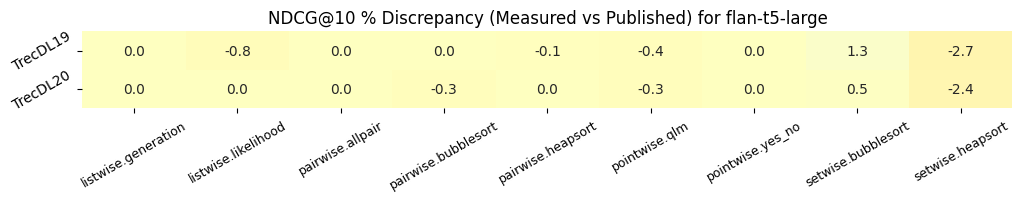

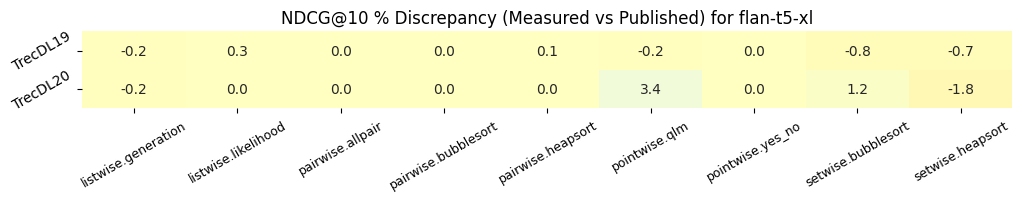

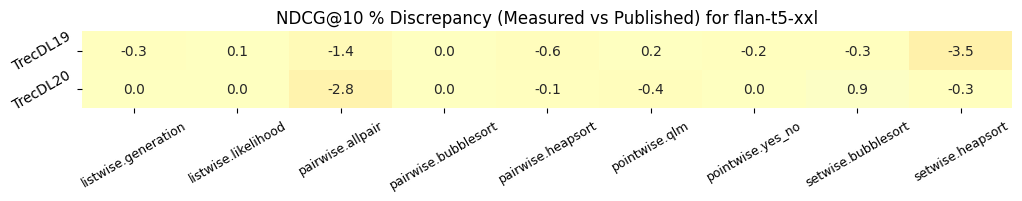

In [45]:

# TODO drop rows where adjusted_df has Method = 'bm25'
adjusted_df2 = adjusted_df[adjusted_df['Method'] != 'bm25']

comparison_table, figures = analyze_trec_metric(adjusted_df2, metric_name='NDCG@10')
report_text = format_results_metric(comparison_table)

# Print the formatted report
print(report_text)

# Display the figures
for fig in figures:
    plt.show()

## Measured vs Published: TrecDL Query Latency 

# TREC 19/20 Latency (s): Measured vs Published Results

## Summary Statistics

* Mean absolute difference: 30.059
* Median absolute difference: 4.997
* Maximum absolute difference: 330.284

## Results by LLM

| LLM           |   mean |     std |   count |
|:--------------|-------:|--------:|--------:|
| flan-t5-large | 39.952 | 104.959 |      18 |
| flan-t5-xl    | 28.951 |  78.889 |      18 |
| flan-t5-xxl   |  2.46  |  32.894 |      18 |

## Most Significant Differences

|    | Dataset   | LLM           | Method              |   Measured |   Published |   Difference |   Relative_Difference_% |   Factor_Difference |
|---:|:----------|:--------------|:--------------------|-----------:|------------:|-------------:|------------------------:|--------------------:|
| 29 | TrecDL20  | flan-t5-large | pairwise.allpair    |    439.184 |       108.9 |      330.284 |                  303.29 |            4.03291  |
|  2 | TrecDL19  | flan-t5-large | pairwise.allpair    |    434.994 |       109.

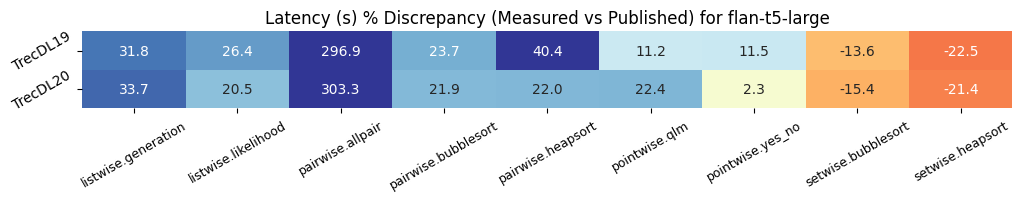

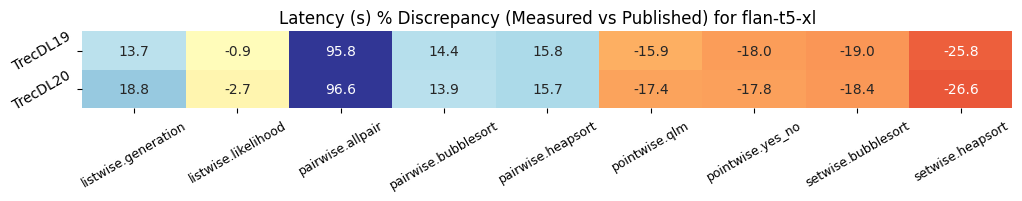

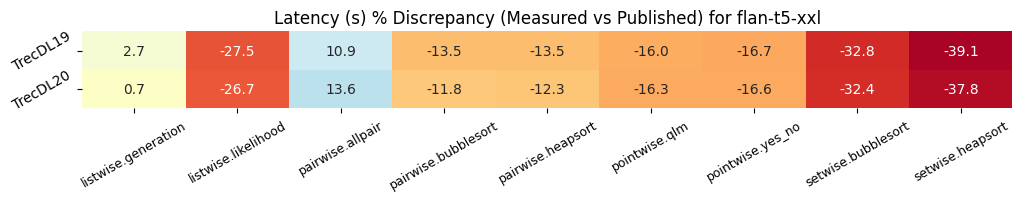

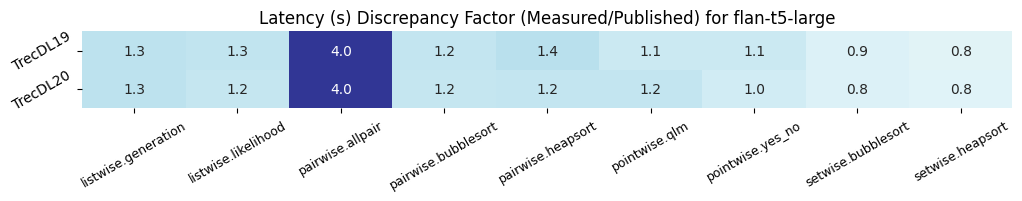

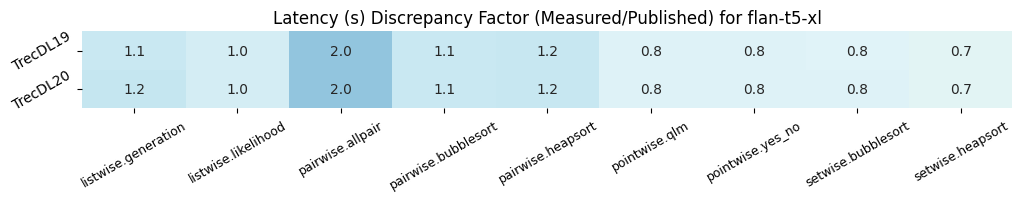

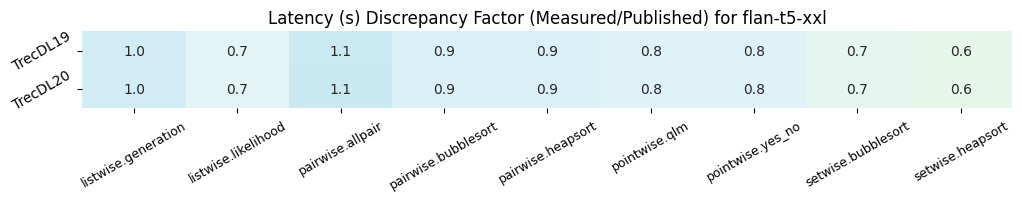

In [46]:
comparison_table, figures = analyze_trec_metric(adjusted_df2, metric_name='Latency (s)')
report_text = format_results_metric(comparison_table, metric_name='Latency (s)')

# Print the formatted report
print(report_text)

# Display the figures
for fig in figures:
    plt.show()

## Measured vs Published: TrecDL #Inferences 

# TREC 19/20 Inferences: Measured vs Published Results

## Summary Statistics

* Mean absolute difference: 594.600
* Median absolute difference: 50.412
* Maximum absolute difference: 4950.000

## Results by LLM

| LLM           |     mean |     std |   count |
|:--------------|---------:|--------:|--------:|
| flan-t5-large | -593.933 | 1585.71 |      18 |
| flan-t5-xl    | -593.556 | 1585.82 |      18 |
| flan-t5-xxl   | -593.63  | 1585.83 |      18 |

## Most Significant Differences

|    | Dataset   | LLM           | Method             |   Measured |   Published |   Difference |   Relative_Difference_% |   Factor_Difference |
|---:|:----------|:--------------|:-------------------|-----------:|------------:|-------------:|------------------------:|--------------------:|
|  2 | TrecDL19  | flan-t5-large | pairwise.allpair   |   4950     |      9900   |    -4950     |                  -50    |            0.5      |
| 11 | TrecDL19  | flan-t5-xl    | pairwise.allpair   |   4950     |   

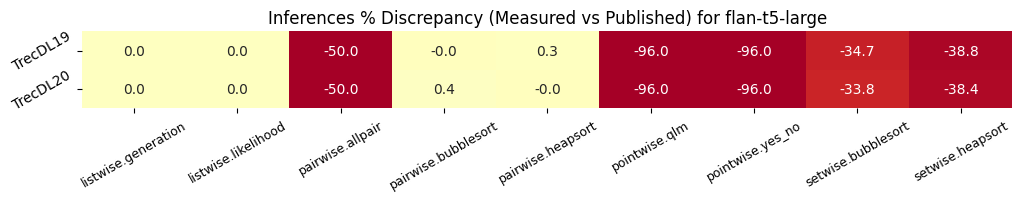

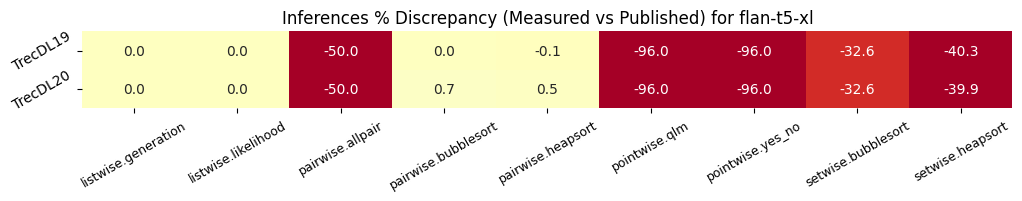

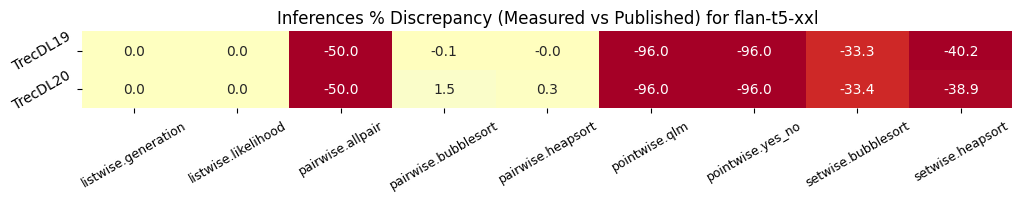

In [47]:
comparison_table, figures = analyze_trec_metric(adjusted_df2, metric_name='Inferences')
report_text = format_results_metric(comparison_table, metric_name='Inferences')

# Print the formatted report
print(report_text)

# Display the figures
for fig in figures:
    plt.show()

Pointwise (yes_no and qlm) report that they only do an average of 4 inferences per query, when it should be 100. The reason to this is unknown

## Measured vs Published: TrecDL Prompt Tokens

# TREC 19/20 Prompt Tokens: Measured vs Published Results

## Summary Statistics

* Mean absolute difference: 101672.380
* Median absolute difference: 441.167
* Maximum absolute difference: 991179.093

## Results by LLM

| LLM           |      mean |    std |   count |
|:--------------|----------:|-------:|--------:|
| flan-t5-large |  -86110.2 | 240515 |      18 |
| flan-t5-xl    | -133862   | 306492 |      18 |
| flan-t5-xxl   |  -82415.7 | 185732 |      18 |

## Most Significant Differences

|    | Dataset   | LLM           | Method              |         Measured |        Published |   Difference |   Relative_Difference_% |   Factor_Difference |
|---:|:----------|:--------------|:--------------------|-----------------:|-----------------:|-------------:|------------------------:|--------------------:|
| 13 | TrecDL19  | flan-t5-xl    | pairwise.heapsort   | 110090           |      1.10127e+06 |  -991179     |                  -90    |           0.0999664 |
|  2 | TrecDL19  | flan-t5

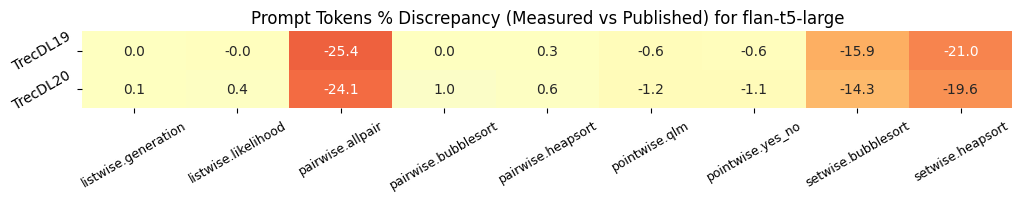

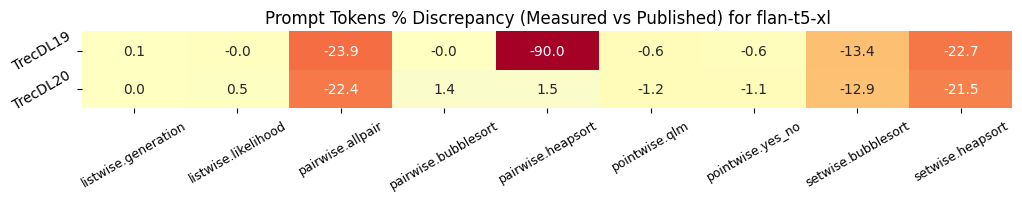

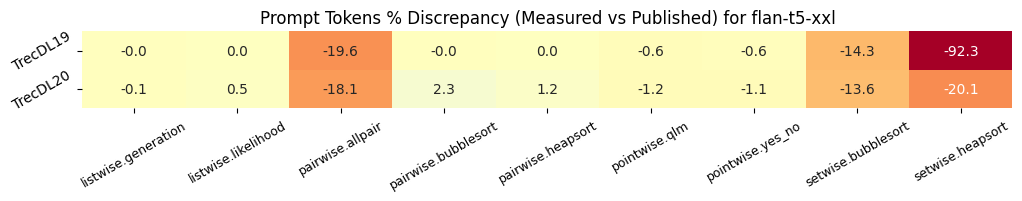

In [48]:
comparison_table, figures = analyze_trec_metric(adjusted_df2, metric_name='Prompt Tokens')
report_text = format_results_metric(comparison_table, metric_name='Prompt Tokens')

# Print the formatted report
print(report_text)

# Display the figures
for fig in figures:
    plt.show()

## Measured vs Published: TrecDL Generated Tokens 

# TREC 19/20 Generated Tokens: Measured vs Published Results

## Summary Statistics

* Mean absolute difference: 181.664
* Median absolute difference: 13.247
* Maximum absolute difference: 797.881

## Results by LLM

| LLM           |     mean |     std |   count |
|:--------------|---------:|--------:|--------:|
| flan-t5-large | -166.23  | 304.417 |      12 |
| flan-t5-xl    | -162.407 | 297.529 |      12 |
| flan-t5-xxl   | -154.932 | 313.774 |      12 |

## Most Significant Differences

|    | Dataset   | LLM           | Method              |   Measured |   Published |   Difference |   Relative_Difference_% |   Factor_Difference |
|---:|:----------|:--------------|:--------------------|-----------:|------------:|-------------:|------------------------:|--------------------:|
|  7 | TrecDL19  | flan-t5-large | setwise.bubblesort  |   1504.42  |     2302.3  |     -797.881 |                  -34.66 |            0.653442 |
| 52 | TrecDL20  | flan-t5-xxl   | setwise.bubblesort  |   1559

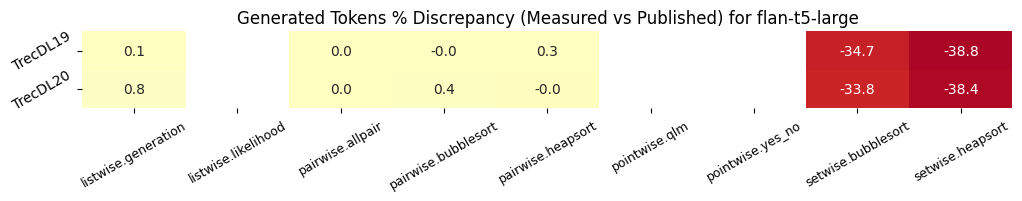

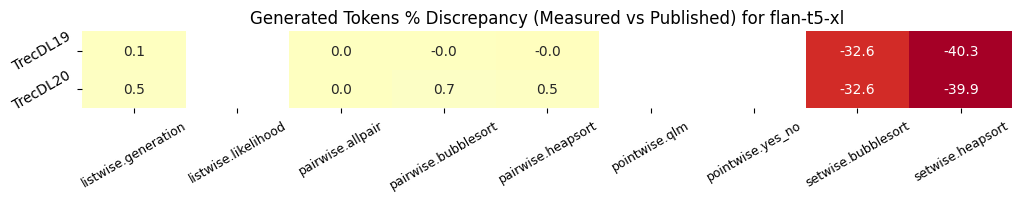

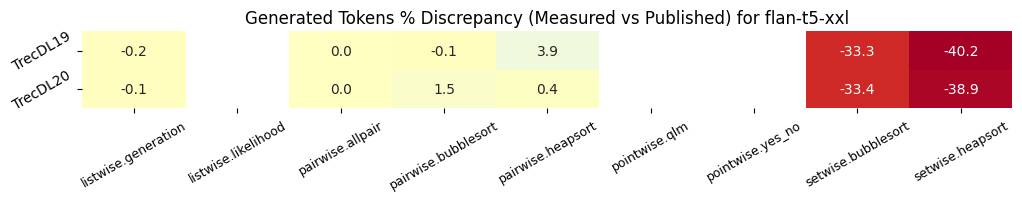

In [49]:
comparison_table, figures = analyze_trec_metric(adjusted_df2, metric_name='Generated Tokens')
report_text = format_results_metric(comparison_table, metric_name='Generated Tokens')

# Print the formatted report
print(report_text)

# Display the figures
for fig in figures:
    plt.show()

## Measured vs Published: TrecDL Metric Discrepancy %

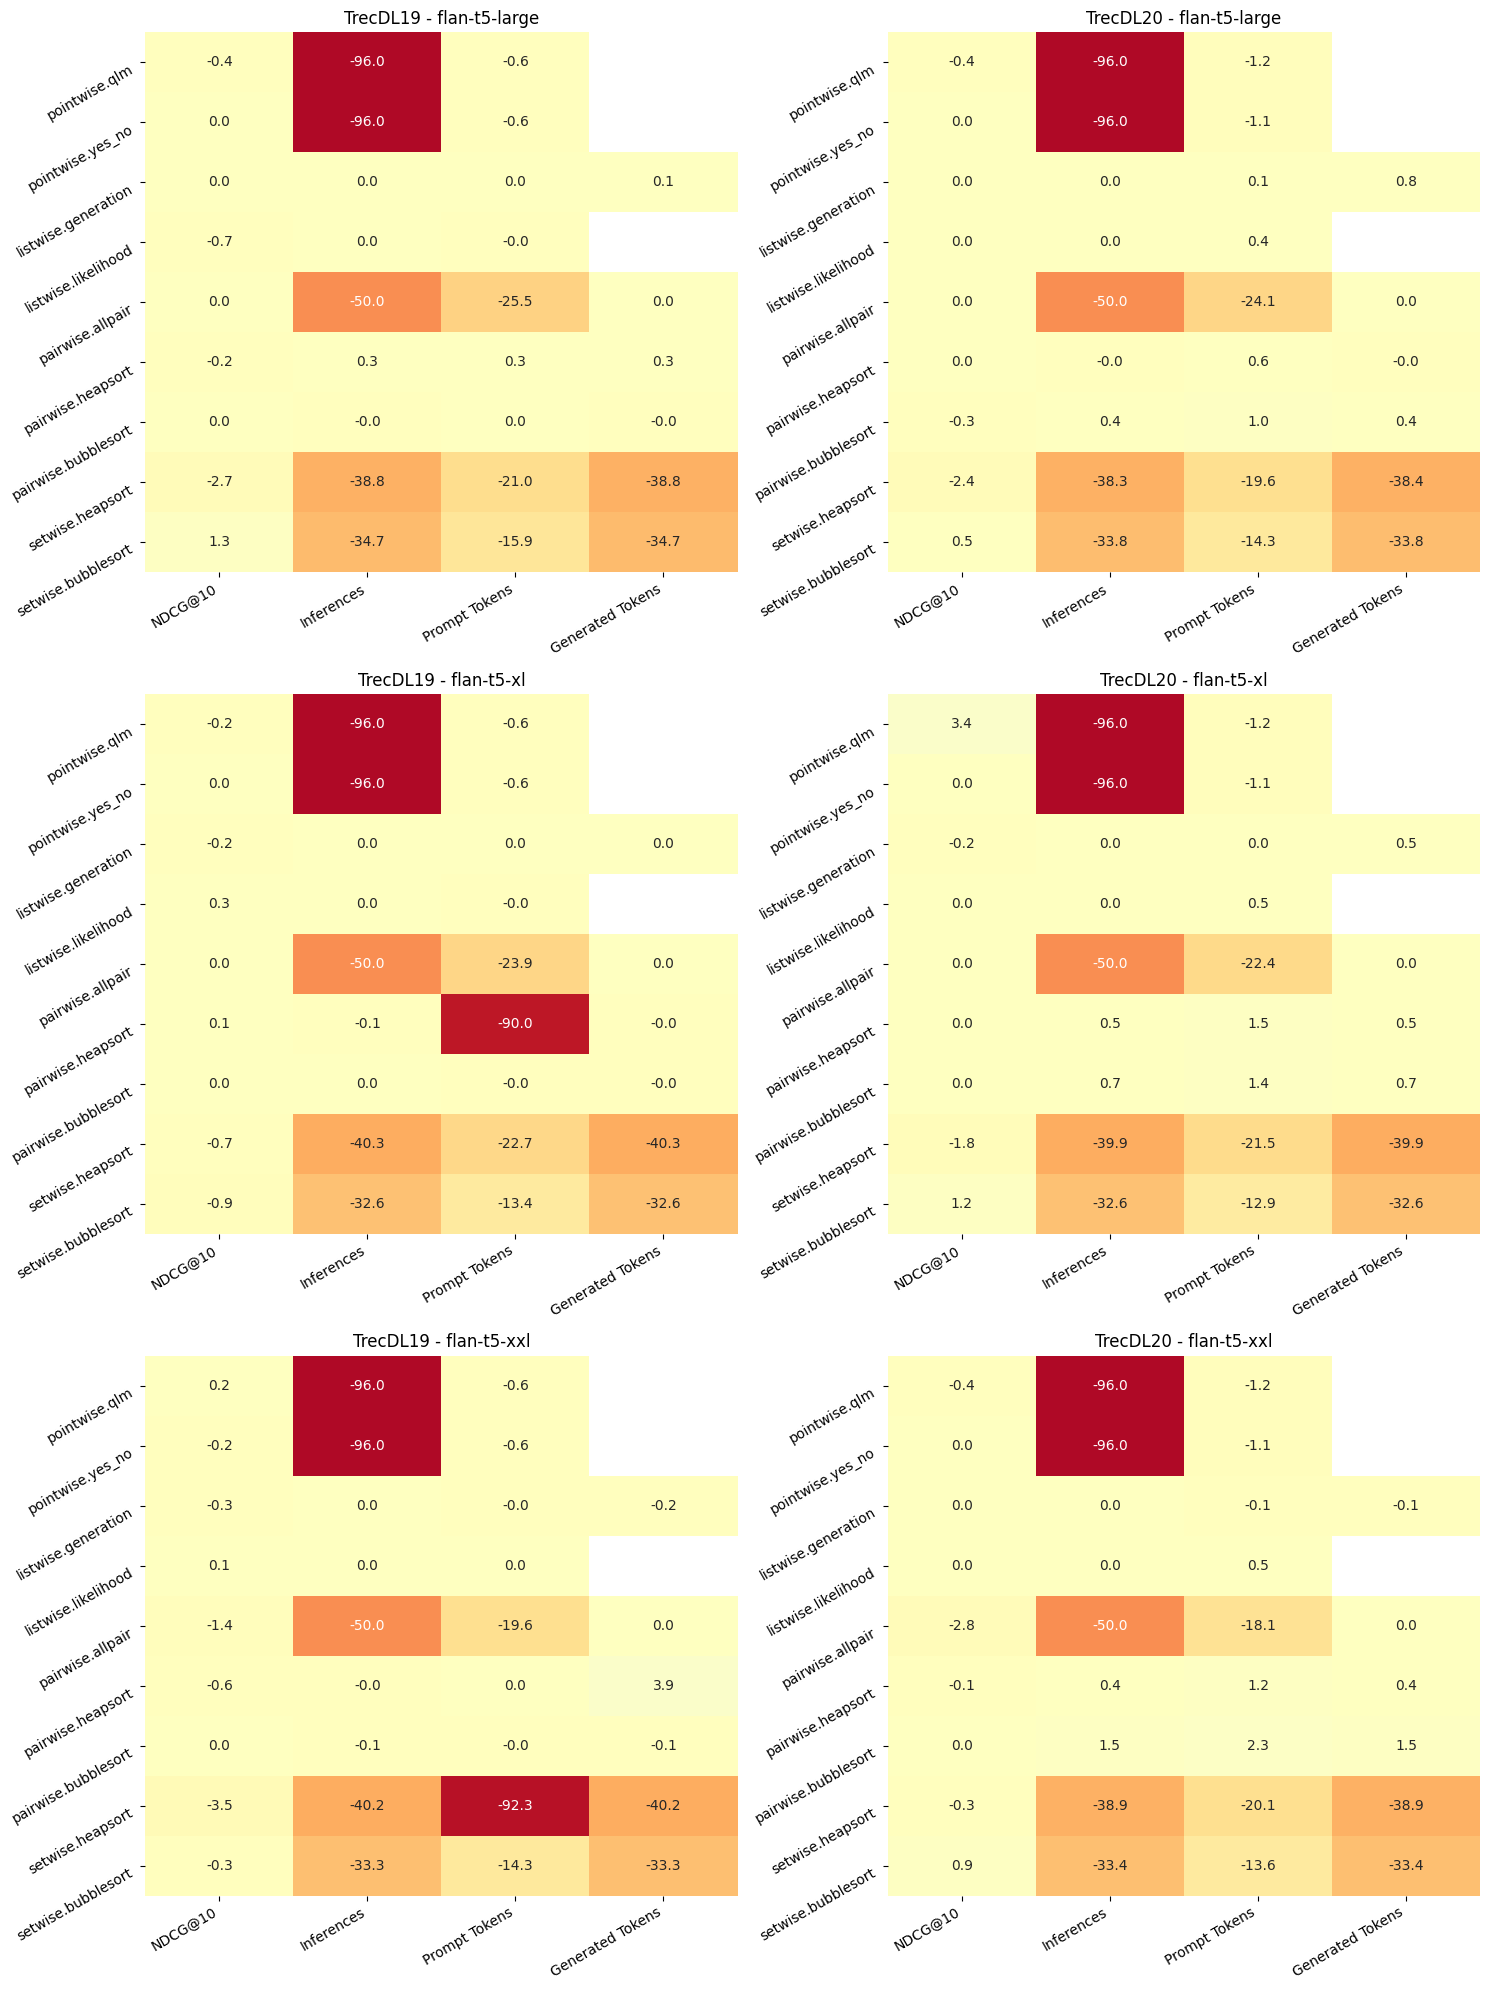

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from typing import List

def create_discrepancy_heatmap(
    df: pd.DataFrame, 
    llm: str, 
    dataset: str, 
    ax: plt.Axes,
    metrics: List[str]
) -> pd.DataFrame:
    """
    Create a heatmap showing the percentage discrepancy between measured and published metrics
    for different methods and metrics.
    
    Parameters:
        df (pd.DataFrame): Input dataframe containing the metrics data
        llm (str): LLM model name to filter data
        dataset (str): Dataset name to filter data
        ax (plt.Axes): Matplotlib axes object to plot on
        metrics (List[str]): List of metrics to display in specified order
    """
    method_order = [
        'pointwise.qlm',
        'pointwise.yes_no',
        'listwise.generation',
        'listwise.likelihood',
        'pairwise.allpair',
        'pairwise.heapsort',
        'pairwise.bubblesort',
        'setwise.heapsort',
        'setwise.bubblesort'
    ]

    # Filter data for specified LLM and dataset
    filtered_df = df[(df['LLM'] == llm) & (df['Dataset'] == dataset)].copy()
    
    # Create pivot tables for measured and published values
    measured_pivot = filtered_df[filtered_df['Source'] == 'Measured'].pivot_table(
        values='Metric_Value',
        index='Method',
        columns='Metric_Name',
        aggfunc='first'
    )
    
    published_pivot = filtered_df[filtered_df['Source'] == 'Published'].pivot_table(
        values='Metric_Value',
        index='Method',
        columns='Metric_Name',
        aggfunc='first'
    )
    
    # Calculate discrepancy percentage
    discrepancy = (measured_pivot - published_pivot) / published_pivot * 100

    # Validate and reorder columns based on provided metrics
    available_metrics = [m for m in metrics if m in discrepancy.columns]
    if len(available_metrics) != len(metrics):
        missing_metrics = set(metrics) - set(available_metrics)
        print(f"Warning: Some metrics not found in data: {missing_metrics}")
    discrepancy = discrepancy[available_metrics]

    # Reorder rows according to method_order
    available_methods = [method for method in method_order if method in discrepancy.index]
    discrepancy = discrepancy.reindex(available_methods)
    
    # Create heatmap on the provided axes
    sns.heatmap(
        discrepancy,
        annot=True,
        fmt='.1f',
        cmap='RdYlBu',
        center=0,
        cbar=False,
        vmin=-100,
        vmax=100,
        ax=ax
    )
    
    # Customize the plot
    ax.set_title(f"{dataset} - {llm}")
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    # Rotate labels
    ax.set_yticklabels(ax.get_yticklabels(), rotation=30, ha='right', va='top')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', va='top')
    
    return discrepancy

def create_heatmap_matrix(
    df: pd.DataFrame,
    metrics: List[str],
    hmap_width: float = 15,
    hmap_height: float = 10
):
    """
    Create a matrix of heatmaps for different LLM and dataset combinations.
    
    Parameters:
        df (pd.DataFrame): Input dataframe containing the metrics data
        metrics (List[str]): List of metrics to display in specified order
        hmap_width (float): Width of the heatmap figure
        hmap_height (float): Height of the heatmap figure
    """
    # Create a figure with 3x2 subplots
    fig, axes = plt.subplots(3, 2, figsize=(hmap_width, hmap_height*2))
    
    # LLM models and datasets
    llms = ["flan-t5-large", "flan-t5-xl", "flan-t5-xxl"]
    datasets = ["TrecDL19", "TrecDL20"]
    
    # Create heatmaps for each combination
    for i, llm in enumerate(llms):
        for j, dataset in enumerate(datasets):
            create_discrepancy_heatmap(df, llm, dataset, axes[i, j], metrics)
    
    bname = "Measured vs Published TrecDL Metric Discrepancy"
    filename = f'doc/_generated/{bname.replace(" ","_")}.png'
    plt.savefig(
        filename,
        dpi=150,
        bbox_inches='tight',  # Automatically adjust boundaries
        pad_inches=0.5  # Add padding around the entire figure
    )

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    
    return fig

# Example usage:
# metrics_order = ['NDCG@10', 'Inferences', 'Prompt Tokens', 'Generated Tokens', 'Latency (s)']
metrics_order = ['NDCG@10', 'Inferences', 'Prompt Tokens', 'Generated Tokens']
fig = create_heatmap_matrix(adjusted_df, metrics=metrics_order)
plt.show()


## Measured vs Published: BEIR NDCG@10 Discrepancy %

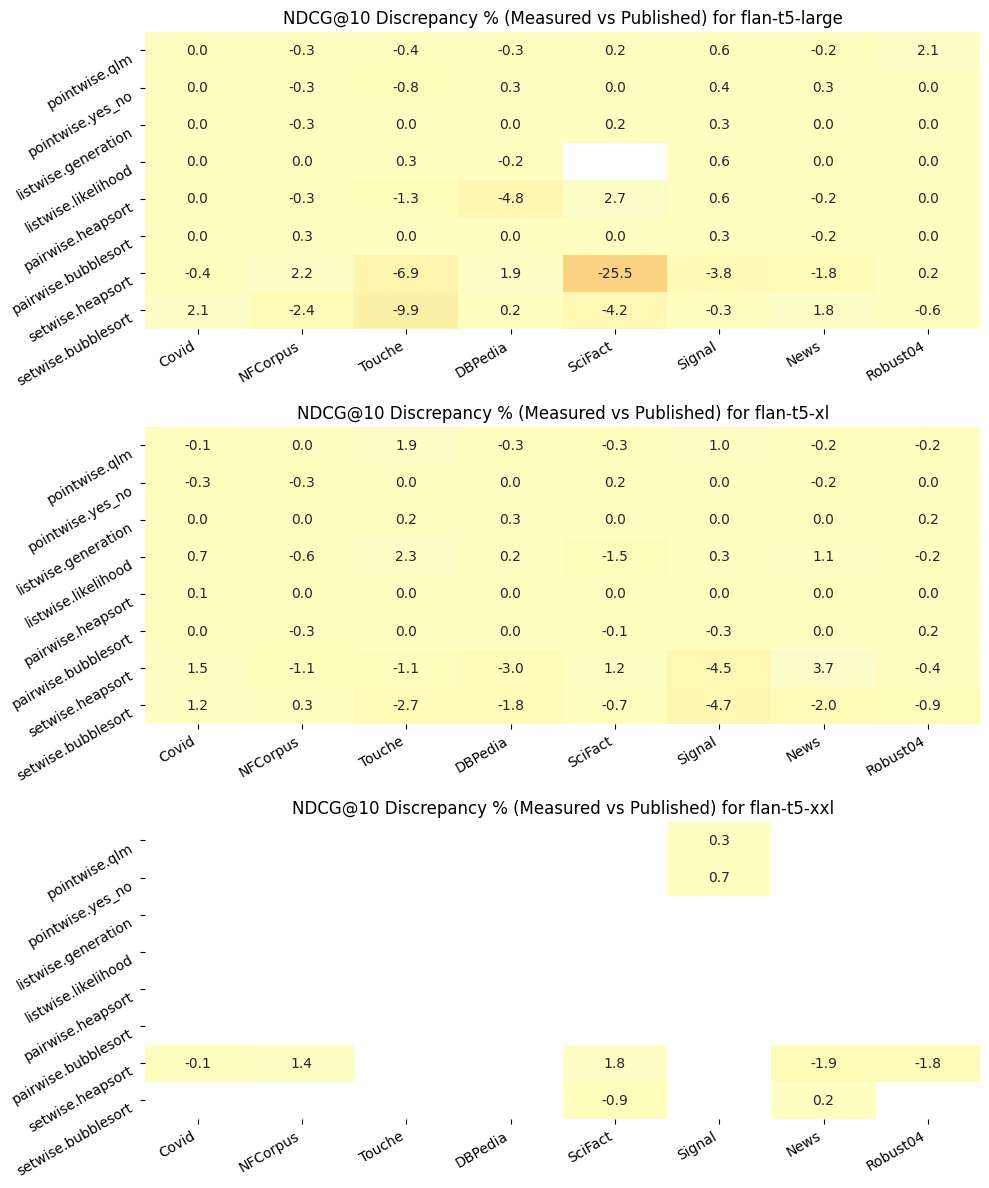

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def value_formatter(val):
    """Custom formatter to display '-' for missing values"""
    if pd.isna(val) or not np.isfinite(val) :
        return '-'
    return f'{val:.1f}'

def plot_ndcg_discrepancy_stacked(df, llm_list):
    """
    Creates three vertically stacked heatmaps showing the percentage discrepancy 
    between measured and published NDCG@10 values for different methods and datasets
    for multiple LLMs. Empty cells are filled with '-'.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing the metrics data
    llm_list : list
        List of LLM names to create heatmaps for
    """
    
    # Define the order of methods and datasets
    method_order = [
        'pointwise.qlm',
        'pointwise.yes_no',
        'listwise.generation',
        'listwise.likelihood',
        'pairwise.heapsort',
        'pairwise.bubblesort',
        'setwise.heapsort',
        'setwise.bubblesort'
    ]
    
    dataset_order = [
        'Covid',
        'NFCorpus',
        'Touche',
        'DBPedia',
        'SciFact',
        'Signal',
        'News',
        'Robust04'
    ]
    
    # Create figure with subplots
    fig, axes = plt.subplots(3, 1, figsize=(10, 12))
    
    # Create heatmap for each LLM
    for idx, llm in enumerate(llm_list):
        # Filter data for the specified LLM and NDCG@10 metric
        filtered_df = df[
            (df['LLM'] == llm) &
            (df['Metric_Name'] == 'NDCG@10')
        ]
        
        # Create pivot tables for measured and published values
        measured_df = filtered_df[filtered_df['Source'] == 'Measured'].pivot(
            index='Method',
            columns='Dataset',
            values='Metric_Value'
        )
        
        published_df = filtered_df[filtered_df['Source'] == 'Published'].pivot(
            index='Method',
            columns='Dataset',
            values='Metric_Value'
        )
        
        # Calculate discrepancy percentage
        discrepancy_df = ((measured_df - published_df) / published_df) * 100
        
        # Reorder rows and columns
        discrepancy_df = discrepancy_df.reindex(index=method_order, columns=dataset_order)
        
        # Format annotation values
        annot_values = [[value_formatter(val) for val in row] for row in discrepancy_df.values]
        
        # Create heatmap
        sns.heatmap(
            discrepancy_df,
            annot=annot_values,
            fmt='',  # Empty format string since we're using custom annotations
            cmap='RdYlBu',
            center=0,
            cbar=False,
            vmin=-100,
            vmax=100,
            ax=axes[idx]
        )
        
        # Customize each subplot
        axes[idx].set_title(f"NDCG@10 Discrepancy % (Measured vs Published) for {llm}")
        axes[idx].set_ylabel('')
        axes[idx].set_xlabel('')
        
        # Rotate labels
        axes[idx].set_yticklabels(axes[idx].get_yticklabels(), rotation=30, ha='right', va='top')
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=30, ha='right', va='top')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    bname = "Measured vs Published BEIR NDCG@10 Discrepancy"
    filename = f'doc/_generated/{bname.replace(" ","_")}.png'
    plt.savefig(filename, bbox_inches='tight', dpi=150)
    
    # return fig

# Call the function with the list of LLMs
llms = ["flan-t5-large", "flan-t5-xl", "flan-t5-xxl"]
plot_ndcg_discrepancy_stacked(adjusted_df, llms)

## Measured vs Published: BEIR GPU Minutes

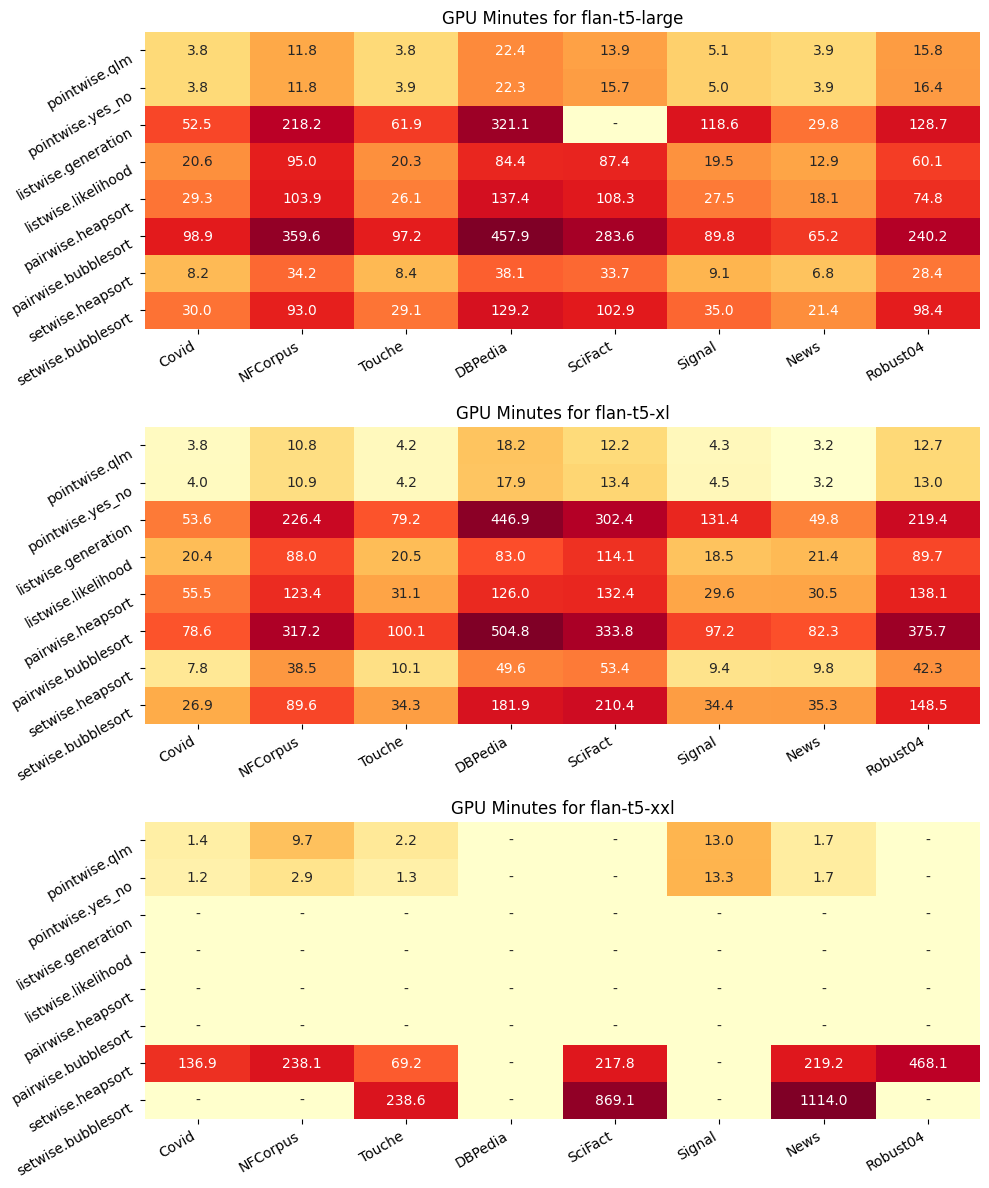

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

def plot_gpu_minutes_stacked(df, llm_list):
    """
    Creates three vertically stacked heatmaps showing the GPU minutes
    for different methods and datasets across multiple LLMs.
    Uses consistent color scaling across all subplots.
    """
    
    method_order = [
        'pointwise.qlm',
        'pointwise.yes_no',
        'listwise.generation',
        'listwise.likelihood',
        'pairwise.heapsort',
        'pairwise.bubblesort',
        'setwise.heapsort',
        'setwise.bubblesort'
    ]
    
    dataset_order = [
        'Covid',
        'NFCorpus',
        'Touche', 
        'DBPedia',
        'SciFact',
        'Signal',
        'News',
        'Robust04'
    ]
    
    # Create figure with subplots
    fig, axes = plt.subplots(3, 1, figsize=(10, 12))
    
    # First pass to find global min/max for consistent color scaling
    global_min = float('inf')
    global_max = float('-inf')
    
    for llm in llm_list:
        filtered_df = df[
            (df['LLM'] == llm) &
            (df['Metric_Name'] == 'GPU Minutes ')
        ]
        
        if (filtered_df.groupby(['Method', 'Dataset']).size() > 1).any():
            filtered_df = filtered_df.groupby(['Method', 'Dataset'])['Metric_Value'].mean().reset_index()
            
        gpu_minutes_df = filtered_df.pivot(
            index='Method',
            columns='Dataset', 
            values='Metric_Value'
        ).reindex(index=method_order, columns=dataset_order).fillna(0)
        
        nonzero_vals = gpu_minutes_df[gpu_minutes_df > 0]
        if not nonzero_vals.empty:
            global_min = min(global_min, nonzero_vals.min().min())
            global_max = max(global_max, nonzero_vals.max().max())
    
    # Use 1/10 of global_min for zero values
    zero_replacement = global_min / 10
    
    # Custom formatter to display '-' for zeros
    def value_formatter(val):
        if val == 0:
            return '-'
        return f'{val:.1f}'
    
    for idx, llm in enumerate(llm_list):
        filtered_df = df[
            (df['LLM'] == llm) &
            (df['Metric_Name'] == 'GPU Minutes ')
        ]
        
        if (filtered_df.groupby(['Method', 'Dataset']).size() > 1).any():
            filtered_df = filtered_df.groupby(['Method', 'Dataset'])['Metric_Value'].mean().reset_index()
        
        gpu_minutes_df = filtered_df.pivot(
            index='Method',
            columns='Dataset', 
            values='Metric_Value'
        ).reindex(index=method_order, columns=dataset_order).fillna(0)
        
        # Prepare data for plotting
        data_for_plot = gpu_minutes_df.copy()
        data_for_plot = data_for_plot.replace(0, zero_replacement)
        
        # Format annotation values
        annot_values = [[value_formatter(val) for val in row] for row in gpu_minutes_df.values]
        
        # data_for_plot.clip(lower=1e-10)
        # axes[idx].set_yscale('log')

        log_data = np.log1p(data_for_plot)  # log1p adds 1 before taking log to handle zeros

        # sns.heatmap(log_data, 
        #             cmap='YlOrRd', 
        #             # annot=True, 
        #             annot=pivot_for_heatmap, 



        # Create heatmap with consistent log-scaled colors
        sns.heatmap(
            log_data,
            annot=annot_values,
            fmt='',  # Use empty string since we're providing formatted annotations
            cmap='YlOrRd',
            # norm=LogNorm(vmin=global_min/10, vmax=global_max),
            # norm=LogNorm(vmin=1, vmax=240),
            cbar=False,  # Remove colorbar
            ax=axes[idx]
        )

        # plt.yscale('log')
        
        # Customize each subplot
        axes[idx].set_title(f"GPU Minutes for {llm}")
        axes[idx].set_ylabel('')
        axes[idx].set_xlabel('')
        
        # Rotate labels
        axes[idx].set_yticklabels(axes[idx].get_yticklabels(), rotation=30, ha='right', va='top')
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=30, ha='right', va='top')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    bname = "Measured vs Published BEIR GPU Minutes"
    filename = f'doc/_generated/{bname.replace(" ","_")}.png'
    plt.savefig(filename, bbox_inches='tight', dpi=150)

    # return fig

# Example usage
llms = ["flan-t5-large", "flan-t5-xl", "flan-t5-xxl"]
plot_gpu_minutes_stacked(adjusted_df, llms)

# Results: Modified vs Original

## Modified vs Original: BEIR Metric Increase %

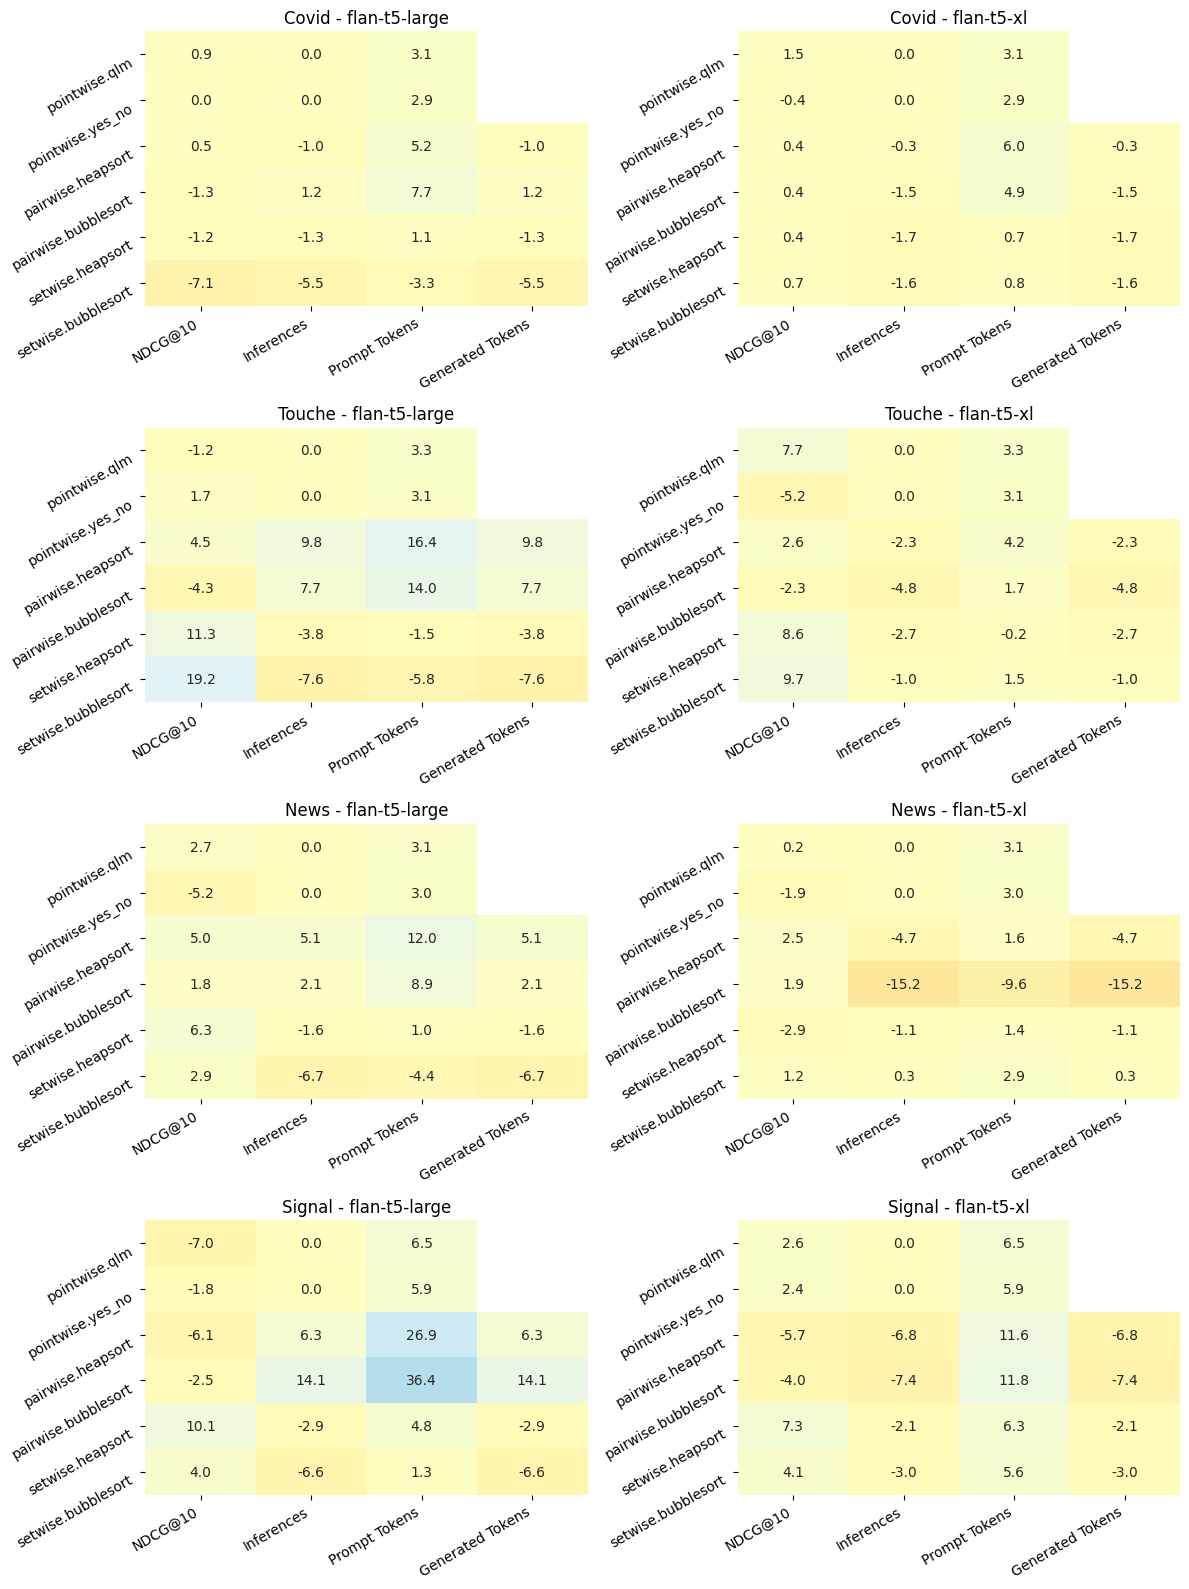

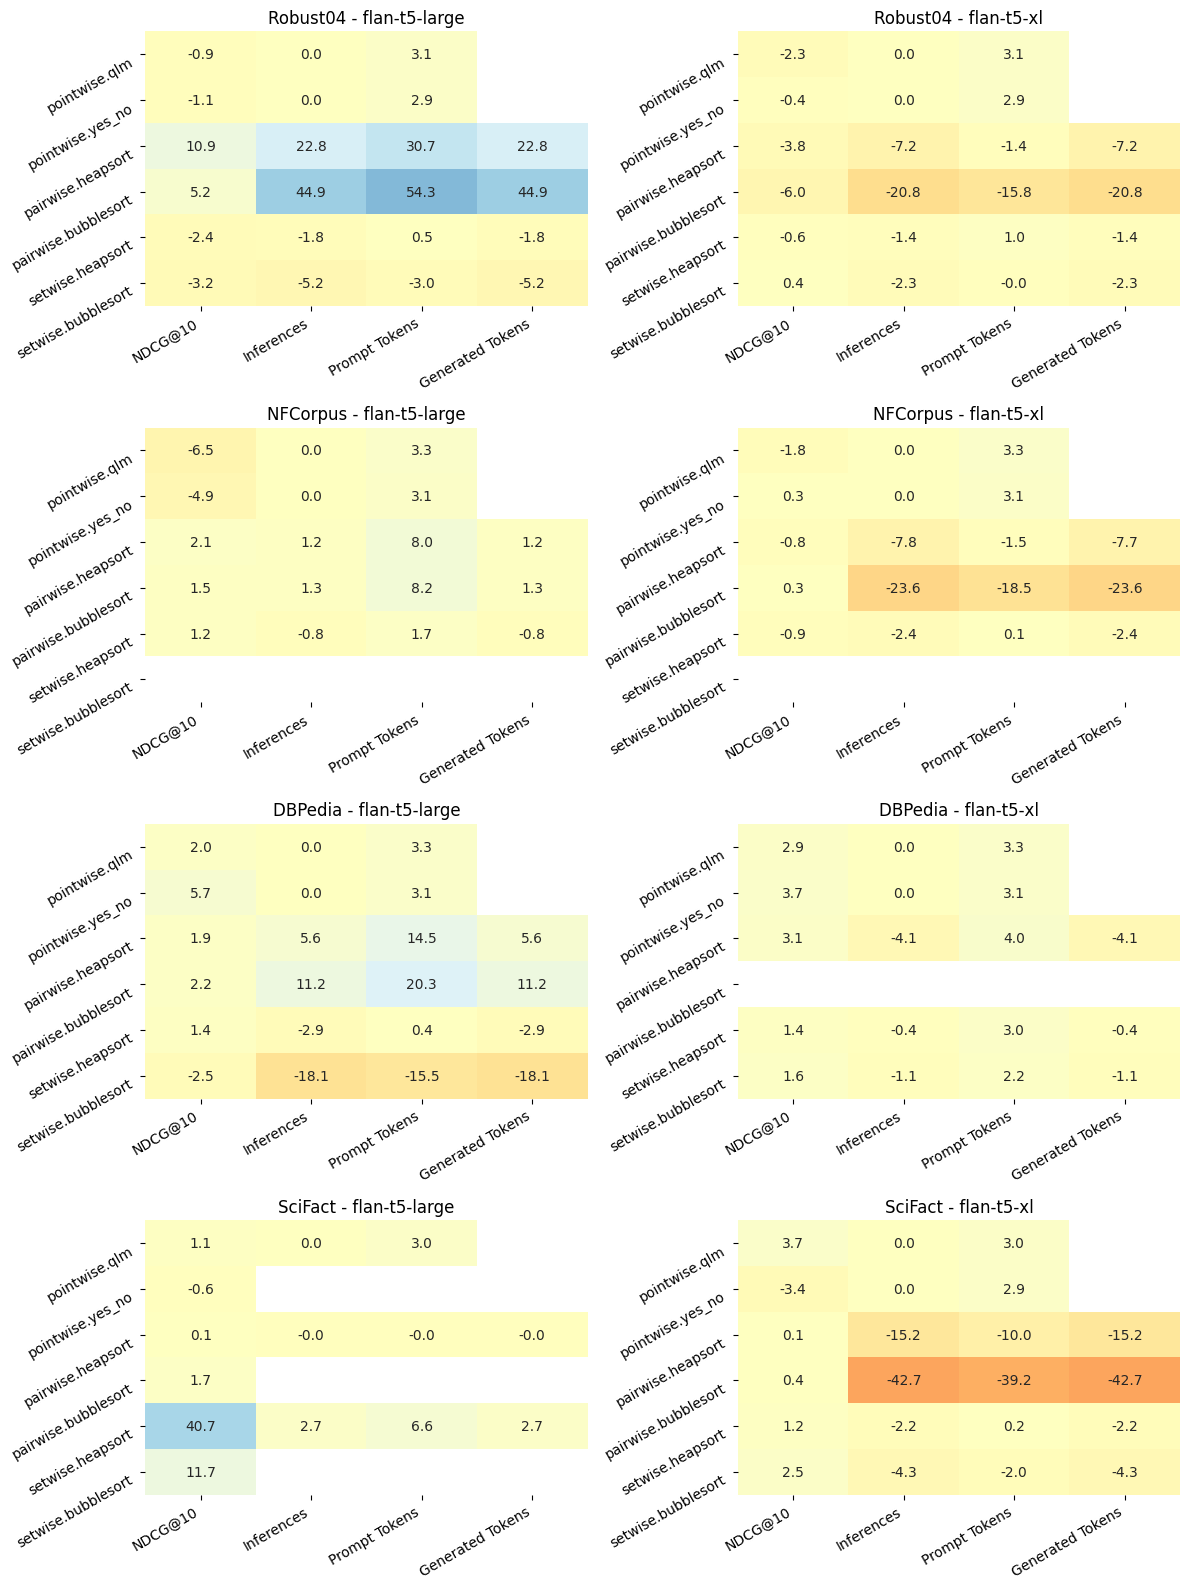

In [53]:
def create_increase_heatmap(df: pd.DataFrame, llm: str, dataset: str, ax: plt.Axes) -> pd.DataFrame:
    """
    Create a heatmap showing the percentage increase from original to modified 
    for different methods and metrics.
    
    Parameters:
        df (pd.DataFrame): Input dataframe containing the metrics data
        llm (str): LLM model name to filter data
        dataset (str): Dataset name to filter data
        ax (plt.Axes): Matplotlib axes object to plot on
    """
    column_order = ['NDCG@10', 'Inferences', 'Prompt Tokens', 'Generated Tokens']

    method_order = [
        'pointwise.qlm',
        'pointwise.yes_no',
        # 'listwise.generation',
        # 'listwise.likelihood',
        # 'pairwise.allpair',
        'pairwise.heapsort',
        'pairwise.bubblesort',
        'setwise.heapsort',
        'setwise.bubblesort'
    ]

    # Filter data for specified LLM and dataset
    filtered_df = df[(df['LLM'] == llm) & (df['Dataset'] == dataset)].copy()
    
    # Create pivot tables for measured and published values
    modified_pivot = filtered_df[filtered_df['Source'] == 'Modified'].pivot_table(
        values='Metric_Value',
        index='Method',
        columns='Metric_Name',
        aggfunc='first'
    )
    
    original_pivot = filtered_df[filtered_df['Source'] == 'Measured'].pivot_table(
        values='Metric_Value',
        index='Method',
        columns='Metric_Name',
        aggfunc='first'
    )
    
    # Calculate increase percentage
    increase = (modified_pivot - original_pivot) / original_pivot * 100

    # Reorder columns
    increase = increase[column_order]

    # Reorder rows according to method_order
    available_methods = [method for method in method_order if method in increase.index]
    increase = increase.reindex(available_methods)
    
    # Create heatmap on the provided axes
    sns.heatmap(
        increase,
        annot=True,
        fmt='.1f',
        cmap='RdYlBu',
        center=0,
        # cbar_kws={'label': 'Discrepancy %'},
        cbar=False,
        vmin=-100,
        vmax=100,
        ax=ax
    )
    
    # Customize the plot
    ax.set_title(f"{dataset} - {llm}")
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    # Rotate labels
    ax.set_yticklabels(ax.get_yticklabels(), rotation=30, ha='right', va='top')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', va='top')
    
    return increase

def create_increase_heatmap_matrix(df: pd.DataFrame, llms: list, datasets: list):
    """
    Create a matrix of heatmaps for different LLM and dataset combinations.
    
    Parameters:
        df (pd.DataFrame): Input dataframe containing the metrics data
        llms (list): List of LLM models to include
        datasets (list): List of datasets to include
    """
    # Create a figure with subplots based on number of datasets and LLMs
    fig, axes = plt.subplots(len(datasets), len(llms), figsize=(hmap_width, hmap_height*len(datasets)))
    
    # Create heatmaps for each combination
    for j, dataset in enumerate(datasets):
        for i, llm in enumerate(llms):
            create_increase_heatmap(df, llm, dataset, axes[j, i])
    
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    
    return fig

datasets1 = [
    "Covid"
    , "Touche"
    , "News"
    , "Signal"
    # , "Robust04"
    # , "NFCorpus"
    # , "DBPedia"
    # , "SciFact"
]
datasets2 = [
    # "Covid"
    # , "Touche"
    # , "News"
    # , "Signal"
     "Robust04"
    , "NFCorpus"
    , "DBPedia"
    , "SciFact"
]

llms = ["flan-t5-large", "flan-t5-xl"]
fig = create_increase_heatmap_matrix(adjusted_df, llms, datasets1)

bname = "Modified vs Original BEIR Metric Increase 1"
filename = f'doc/_generated/{bname.replace(" ","_")}.png'
plt.savefig(filename, bbox_inches='tight', dpi=150)

fig = create_increase_heatmap_matrix(adjusted_df, llms, datasets2)

bname = "Modified vs Original BEIR Metric Increase 2"
filename = f'doc/_generated/{bname.replace(" ","_")}.png'
plt.savefig(filename, bbox_inches='tight', dpi=150)

# plt.show()

## Modified vs Original: BEIR NDCG@10 Increase %

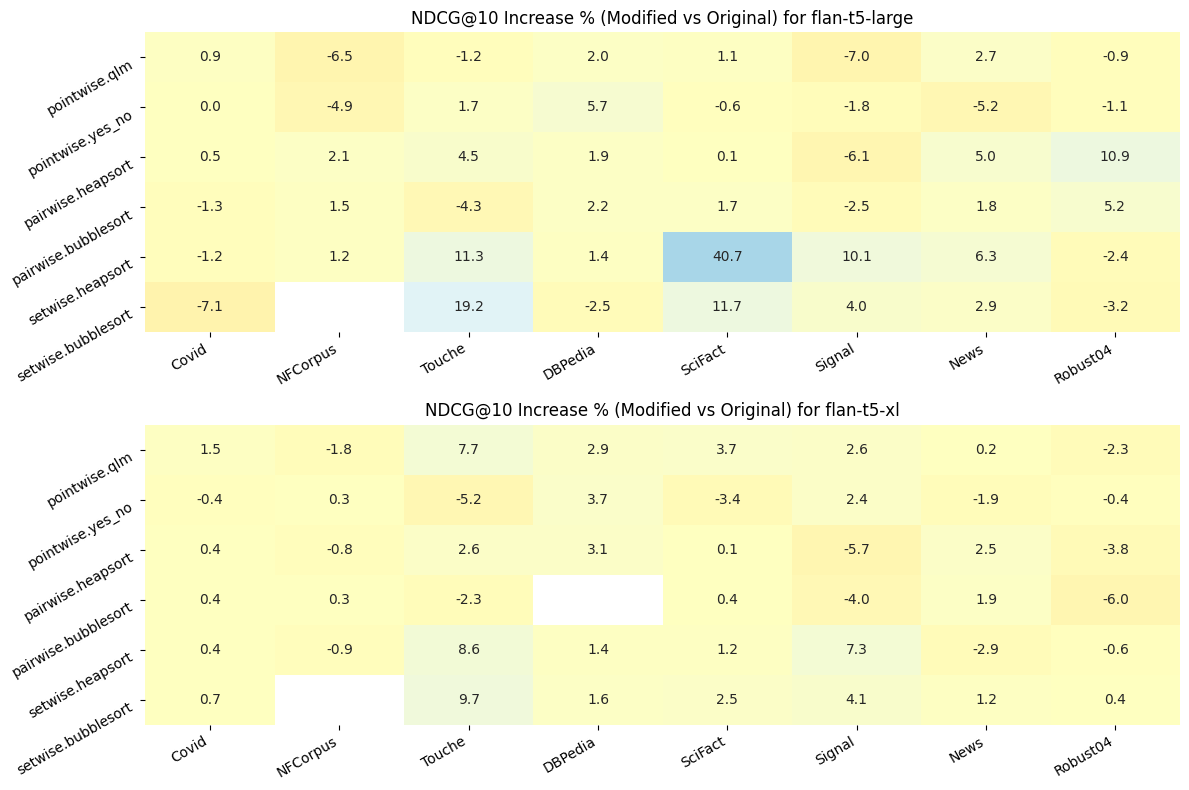

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def value_formatter(val):
    """Custom formatter to display '-' for missing values"""
    if pd.isna(val) or not np.isfinite(val) :
        return '-'
    return f'{val:.1f}'

def plot_ndcg_discrepancy_stacked(df, llm_list):
    """
    Creates three vertically stacked heatmaps showing the percentage discrepancy 
    between measured and published NDCG@10 values for different methods and datasets
    for multiple LLMs. Empty cells are filled with '-'.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing the metrics data
    llm_list : list
        List of LLM names to create heatmaps for
    """
    
    # Define the order of methods and datasets
    method_order = [
        'pointwise.qlm',
        'pointwise.yes_no',
        # 'listwise.generation',
        # 'listwise.likelihood',
        'pairwise.heapsort',
        'pairwise.bubblesort',
        'setwise.heapsort',
        'setwise.bubblesort'
    ]
    
    dataset_order = [
        'Covid',
        'NFCorpus',
        'Touche',
        'DBPedia',
        'SciFact',
        'Signal',
        'News',
        'Robust04'
    ]
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(hmap_width, hmap_height*2))
                                                
    # Create heatmap for each LLM
    for idx, llm in enumerate(llm_list):
        # Filter data for the specified LLM and NDCG@10 metric
        filtered_df = df[
            (df['LLM'] == llm) &
            (df['Metric_Name'] == 'NDCG@10')
        ]
        
        # Create pivot tables for measured and published values
        original_df = filtered_df[filtered_df['Source'] == 'Measured'].pivot(
            index='Method',
            columns='Dataset',
            values='Metric_Value'
        )
        
        modified_df = filtered_df[filtered_df['Source'] == 'Modified'].pivot(
            index='Method',
            columns='Dataset',
            values='Metric_Value'
        )
        
        # Calculate discrepancy percentage
        increase_df = ((modified_df - original_df) / original_df) * 100
        
        # Reorder rows and columns
        increase_df = increase_df.reindex(index=method_order, columns=dataset_order)
        
        # Format annotation values
        annot_values = [[value_formatter(val) for val in row] for row in increase_df.values]
        
        # Create heatmap
        sns.heatmap(
            increase_df,
            annot=annot_values,
            fmt='',  # Empty format string since we're using custom annotations
            cmap='RdYlBu',
            center=0,
            cbar=False,
            vmin=-100,
            vmax=100,
            ax=axes[idx]
        )
        
        # Customize each subplot
        axes[idx].set_title(f"NDCG@10 Increase % (Modified vs Original) for {llm}")
        axes[idx].set_ylabel('')
        axes[idx].set_xlabel('')
        
        # Rotate labels
        axes[idx].set_yticklabels(axes[idx].get_yticklabels(), rotation=30, ha='right', va='top')
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=30, ha='right', va='top')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    bname = "Modified vs Original BEIR NDCG@10 Increase"
    filename = f'doc/_generated/{bname.replace(" ","_")}.png'
    plt.savefig(filename, bbox_inches='tight', dpi=150)

    # return fig

# Call the function with the list of LLMs
# llms = ["flan-t5-large", "flan-t5-xl", "flan-t5-xxl"]
llms = ["flan-t5-large", "flan-t5-xl"]
plot_ndcg_discrepancy_stacked(adjusted_df, llms)

## analyze_beir_modified_metric()

In [55]:
import pandas as pd
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product


def analyze_beir_modified_metric(df: pd.DataFrame, metric_name="NDCG@10") -> Tuple[pd.DataFrame, List[plt.Figure]]:
    """
    Analyzes BEIR NDCG@10 scores, comparing original (measured) vs modified values across LLMs, methods, and datasets.
    
    Args:
        df (pd.DataFrame): Input dataframe with columns Source, LLM, Dataset, Method, Metric_Name, Metric_Value
        
    Returns:
        Tuple[pd.DataFrame, List[plt.Figure]]: Tables and figures for the analysis
    """

    scale=0.6
    # Filter for relevant data
    relevant_datasets = ['Covid', 'Signal', 'News', 'Robust04', 'NFCorpus', 'Touche', 'SciFact', 'DBPedia']
    relevant_llms = ['flan-t5-large', 'flan-t5-xl']
    
    # Filter out listwise methods
    filtered_df = df[
        (df['Dataset'].isin(relevant_datasets)) &
        (df['LLM'].isin(relevant_llms)) &
        (df['Metric_Name'] == metric_name) &
        (~df['Method'].str.contains('listwise', case=False, na=False)) &
        (df['Source'].isin(['Measured', 'Modified']))
    ].copy()
    
    # Rename Sources for clarity
    filtered_df['Source'] = filtered_df['Source'].map({
        'Measured': 'Original',
        'Modified': 'Modified'
    })
    
    # Create comparison table
    pivot_table = filtered_df.pivot_table(
        index=['Dataset', 'LLM', 'Method'],
        columns='Source',
        values='Metric_Value',
        aggfunc='mean'
    ).reset_index()
    
    # Calculate differences
    pivot_table['Difference'] = pivot_table['Modified'] - pivot_table['Original']
    pivot_table['Relative_Difference_%'] = (pivot_table['Difference'] / pivot_table['Original'] * 100).round(2)
    pivot_table['Factor_Difference'] = pivot_table['Modified'] / pivot_table['Original']
    
    # Sort by absolute difference
    pivot_table['Abs_Difference'] = pivot_table['Difference'].abs()
    pivot_table = pivot_table.sort_values('Abs_Difference', ascending=False)
    pivot_table = pivot_table.drop('Abs_Difference', axis=1)
    
    # Generate figures
    figures = []
    
    # # 1. Heatmap of absolute differences by Dataset and Method for each LLM
    # for llm in relevant_llms:
    #     fig, ax = plt.subplots(figsize=(hmap_width, hmap_height))
    #     heatmap_data = pivot_table[pivot_table['LLM'] == llm].pivot(
    #         index='Dataset',
    #         columns='Method',
    #         values='Difference'
    #     )
        
    #     sns.heatmap(heatmap_data, 
    #                cmap='RdYlBu',
    #                center=0,
    #                annot=True,
    #                fmt='.3f',
    #                ax=ax)
        
    #     # Rotate x-axis labels 45 degrees
    #     plt.xticks(rotation=45, ha='right')
    #     plt.xlabel('')  # Remove x-label
    #     plt.ylabel('')  # Remove y-label
        
    #     plt.title(f'Absolute Difference (Modified - Original) {metric_name} for {llm}')
    #     plt.tight_layout()
    #     figures.append(fig)

    # 2. Heatmap of relative differences by Dataset and Method for each LLM
    # for llm in relevant_llms:
    #     fig, ax = plt.subplots(figsize=(hmap_width, hmap_height))
    #     heatmap_data = pivot_table[pivot_table['LLM'] == llm].pivot(
    #         index='Dataset',
    #         columns='Method',
    #         values='Relative_Difference_%'
    #     )
        
    #     sns.heatmap(heatmap_data, 
    #                cmap='RdYlBu',
    #                center=0,
    #                annot=True,
    #                fmt='.1f',
    #                vmin=-50,
    #                vmax=50,
    #                ax=ax)
        
    #     # Rotate x-axis labels 45 degrees
    #     plt.xticks(rotation=45, ha='right')
    #     plt.xlabel('')  # Remove x-label
    #     plt.ylabel('')  # Remove y-label
        
    #     # plt.title(f'Relative Difference (% {metric_name} Change) for {llm}')
    #     plt.title(f'{metric_name} % Increase (Modified vs Original) for {llm}')
    #     plt.tight_layout()

    #     filename = f'doc/_generated/modified_original_beir_heatmap_pdiff_{metric_name.replace(" ", "")}_{llm.lower().replace("-", "")}.png'
    #     plt.savefig(filename, bbox_inches='tight', dpi=150)

    #     figures.append(fig)
    

    # if metric_name == 'Latency (s)':
    #     for llm in relevant_llms:
    #         fig, ax = plt.subplots(figsize=(hmap_width, hmap_height))
    #         heatmap_data = pivot_table[pivot_table['LLM'] == llm].pivot(
    #             index='Dataset',
    #             columns='Method',
    #             values='Factor_Difference'
    #         )
            
    #         sns.heatmap(heatmap_data, 
    #                 cmap='RdYlBu',
    #                 center=0,
    #                 annot=True,
    #                 fmt='.1f',
    #                 vmin=0,
    #                 vmax=2,
    #                 ax=ax)
            
    #         plt.tick_params(axis='x', labelsize=9)
    #         plt.xticks(rotation=30)
    #         plt.xlabel('')  # Remove x-label
    #         plt.ylabel('')  # Remove y-label

    #         plt.title(f'{metric_name} Factor (Modified/Original) for {llm}')
    #         # plt.tight_layout()

    #         filename = f'doc/_generated/modified_original_beir_heatmap_fdiff_{metric_name.replace(" ", "")}_{llm.lower().replace("-", "")}.png'
    #         plt.savefig(filename, bbox_inches='tight', dpi=150)

    #         figures.append(fig)


    # 3. Box plot of differences by Dataset
    if metric_name == 'NDCG@10':
        fig, ax = plt.subplots(figsize=(hmap_width, hmap_height))
        sns.boxplot(data=pivot_table, x='Method', y='Difference', hue='LLM', ax=ax)
        plt.xticks(rotation=45)
        plt.xlabel('')  # Remove x-label
        
        if (metric_name == 'NDCG@10'):
            plt.ylim(-0.07, 0.07)  # Set y-axis limits

        if (metric_name == 'Inferences'):
            plt.ylim(-300, 300)

        if (metric_name == 'Prompt Tokens'):
            plt.ylim(-3000, 3000)
        
        if (metric_name == 'Generated Tokens'):
            plt.ylim(-3000, 3000)
        
        if (metric_name == 'Latency (s)'):
            plt.ylim(-30, 30)


        # Add horizontal line at y=0
        ax.axhline(y=0.0, color='black', linestyle='--', alpha=0.4)

        # plt.title('Modification Tends to Improve NDCG@10')
        plt.title(f'Modification Lifts {metric_name}')
        plt.tight_layout()

        filename = f'doc/_generated/modified_original_beir_pdiff_method_boxplot{metric_name.replace(" ", "")}.png'
        plt.savefig(filename, bbox_inches='tight', dpi=150)

        figures.append(fig)
    
    return pivot_table, figures

def format_modified_results(table: pd.DataFrame, metric_name="NDCG@10") -> str:
    """
    Formats the analysis results into a markdown string suitable for a research paper.
    
    Args:
        table (pd.DataFrame): The comparison table generated by analyze_beir_ndcg_modified
        
    Returns:
        str: Formatted markdown string
    """
    markdown = f"# BEIR {metric_name}: Original vs Modified Results\n\n"
    
    # Overall statistics
    markdown += "## Summary Statistics\n\n"
    markdown += f"* Mean absolute difference: {table['Difference'].abs().mean():.3f}\n"
    markdown += f"* Median absolute difference: {table['Difference'].abs().median():.3f}\n"
    markdown += f"* Maximum absolute difference: {table['Difference'].abs().max():.3f}\n"
    
    # Results by LLM
    markdown += "\n## Results by LLM\n\n"
    llm_stats = table.groupby('LLM')['Difference'].agg(['mean', 'std', 'count']).round(3)
    markdown += llm_stats.to_markdown()
    
    # Most significant differences
    markdown += "\n\n## Most Significant Differences\n\n"
    significant_diffs = table.head(15)  # Already sorted by absolute difference
    markdown += significant_diffs.to_markdown()
    
    return markdown


adjusted_df2 = adjusted_df[adjusted_df['Method'] != 'bm25']
adjusted_df2 = adjusted_df2[adjusted_df2['Method'] != 'listwise.generation']
adjusted_df2 = adjusted_df2[adjusted_df2['Method'] != 'listwise.likelihood']


## Modified vs Original: BEIR NDCG@10 

# BEIR NDCG@10: Original vs Modified Results

## Summary Statistics

* Mean absolute difference: 0.015
* Median absolute difference: 0.009
* Maximum absolute difference: 0.188

## Results by LLM

| LLM           |   mean |   std |   count |
|:--------------|-------:|------:|--------:|
| flan-t5-large |  0.009 | 0.035 |      47 |
| flan-t5-xl    |  0.002 | 0.013 |      46 |

## Most Significant Differences

|    | Dataset   | LLM           | Method              |   Modified |   Original |   Difference |   Relative_Difference_% |   Factor_Difference |
|---:|:----------|:--------------|:--------------------|-----------:|-----------:|-------------:|------------------------:|--------------------:|
| 65 | SciFact   | flan-t5-large | setwise.heapsort    |      0.65  |      0.462 |        0.188 |                   40.69 |            1.40693  |
| 64 | SciFact   | flan-t5-large | setwise.bubblesort  |      0.68  |      0.609 |        0.071 |                   11.66 |            1.11658  |
| 88 |

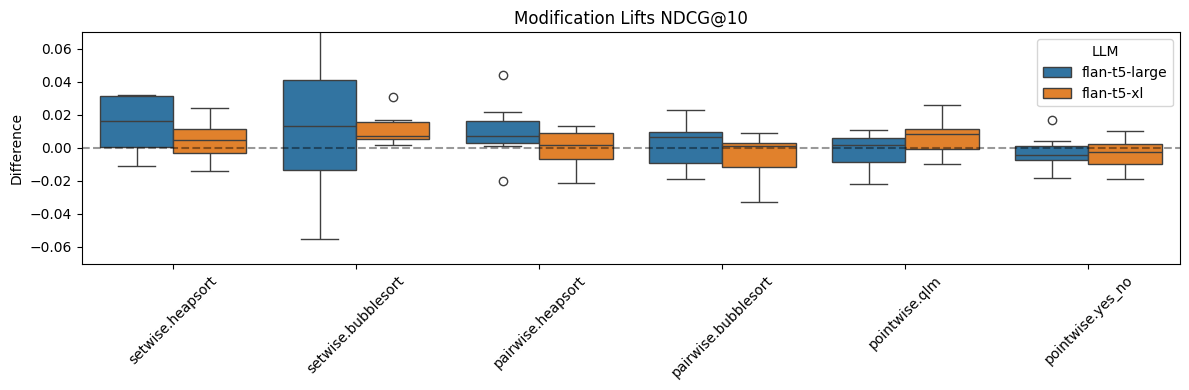

In [56]:
comparison_table, figures = analyze_beir_modified_metric(adjusted_df2,"NDCG@10")
report_text = format_modified_results(comparison_table,"NDCG@10")

# Print the formatted report
print(report_text)

# Display the figures
for fig in figures:
    plt.show()

## Modified vs Original: BEIR Query Latency

In [57]:
comparison_table, figures = analyze_beir_modified_metric(adjusted_df2,"Latency (s)")
report_text = format_modified_results(comparison_table,"Latency (s)")

# Print the formatted report
print(report_text)

# Display the figures
for fig in figures:
    plt.show()

# BEIR Latency (s): Original vs Modified Results

## Summary Statistics

* Mean absolute difference: 9.525
* Median absolute difference: 2.627
* Maximum absolute difference: 76.015

## Results by LLM

| LLM           |   mean |    std |   count |
|:--------------|-------:|-------:|--------:|
| flan-t5-large | -5.862 | 14.463 |      44 |
| flan-t5-xl    | -8.383 | 19.572 |      46 |

## Most Significant Differences

|    | Dataset   | LLM           | Method              |   Modified |   Original |   Difference |   Relative_Difference_% |   Factor_Difference |
|---:|:----------|:--------------|:--------------------|-----------:|-----------:|-------------:|------------------------:|--------------------:|
|  7 | Covid     | flan-t5-xl    | pairwise.heapsort   |     30.651 |    106.666 |      -76.015 |                  -71.26 |            0.287355 |
| 66 | SciFact   | flan-t5-xl    | pairwise.bubblesort |     28.904 |    103.395 |      -74.491 |                  -72.05 |            0.279549

## Modified vs Original: BEIR #Inferences

In [58]:
comparison_table, figures = analyze_beir_modified_metric(adjusted_df2,"Inferences")
report_text = format_modified_results(comparison_table,"Inferences")

# Print the formatted report
print(report_text)

# Display the figures
for fig in figures:
    plt.show()

# BEIR Inferences: Original vs Modified Results

## Summary Statistics

* Mean absolute difference: 19.291
* Median absolute difference: 1.743
* Maximum absolute difference: 280.090

## Results by LLM

| LLM           |    mean |    std |   count |
|:--------------|--------:|-------:|--------:|
| flan-t5-large |  10.482 | 43.305 |      44 |
| flan-t5-xl    | -20.507 | 51.482 |      46 |

## Most Significant Differences

|    | Dataset   | LLM           | Method              |   Modified |   Original |   Difference |   Relative_Difference_% |   Factor_Difference |
|---:|:----------|:--------------|:--------------------|-----------:|-----------:|-------------:|------------------------:|--------------------:|
| 66 | SciFact   | flan-t5-xl    | pairwise.bubblesort |    375.62  |    655.71  |     -280.09  |                  -42.72 |            0.572845 |
| 48 | Robust04  | flan-t5-large | pairwise.bubblesort |    765.229 |    528.205 |      237.024 |                   44.87 |            1.4

## Modified vs Original: BEIR Prompt Tokens

In [59]:
comparison_table, figures = analyze_beir_modified_metric(adjusted_df2,"Prompt Tokens")
report_text = format_modified_results(comparison_table,"Prompt Tokens")

# Print the formatted report
print(report_text)

# Display the figures
for fig in figures:
    plt.show()

# BEIR Prompt Tokens: Original vs Modified Results

## Summary Statistics

* Mean absolute difference: 12845.719
* Median absolute difference: 625.244
* Maximum absolute difference: 182008.635

## Results by LLM

| LLM           |     mean |     std |   count |
|:--------------|---------:|--------:|--------:|
| flan-t5-large | 13154.4  | 32991.6 |      44 |
| flan-t5-xl    | -5521.38 | 29439.1 |      46 |

## Most Significant Differences

|    | Dataset   | LLM           | Method              |   Modified |   Original |   Difference |   Relative_Difference_% |   Factor_Difference |
|---:|:----------|:--------------|:--------------------|-----------:|-----------:|-------------:|------------------------:|--------------------:|
| 48 | Robust04  | flan-t5-large | pairwise.bubblesort |     516949 |     334940 |     182009   |                   54.34 |            1.54341  |
| 66 | SciFact   | flan-t5-xl    | pairwise.bubblesort |     256336 |     421897 |    -165561   |                  -39.

## Modified vs Original: BEIR Generated Tokens

In [60]:
comparison_table, figures = analyze_beir_modified_metric(adjusted_df2,"Generated Tokens")
report_text = format_modified_results(comparison_table,"Generated Tokens")

# Print the formatted report
print(report_text)

# Display the figures
for fig in figures:
    plt.show()

# BEIR Generated Tokens: Original vs Modified Results

## Summary Statistics

* Mean absolute difference: 180.876
* Median absolute difference: 8.717
* Maximum absolute difference: 2800.900

## Results by LLM

| LLM           |    mean |     std |   count |
|:--------------|--------:|--------:|--------:|
| flan-t5-large |  123.06 | 417.963 |      44 |
| flan-t5-xl    | -199.58 | 516.412 |      46 |

## Most Significant Differences

|    | Dataset   | LLM           | Method              |   Modified |   Original |   Difference |   Relative_Difference_% |   Factor_Difference |
|---:|:----------|:--------------|:--------------------|-----------:|-----------:|-------------:|------------------------:|--------------------:|
| 66 | SciFact   | flan-t5-xl    | pairwise.bubblesort |    3756.2  |    6557.1  |    -2800.9   |                  -42.72 |            0.572845 |
| 48 | Robust04  | flan-t5-large | pairwise.bubblesort |    7652.29 |    5282.05 |     2370.24  |                   44.87 |   

## GPU Minutes Per Experiment

NVIDIA RTX 4090 GPUS!

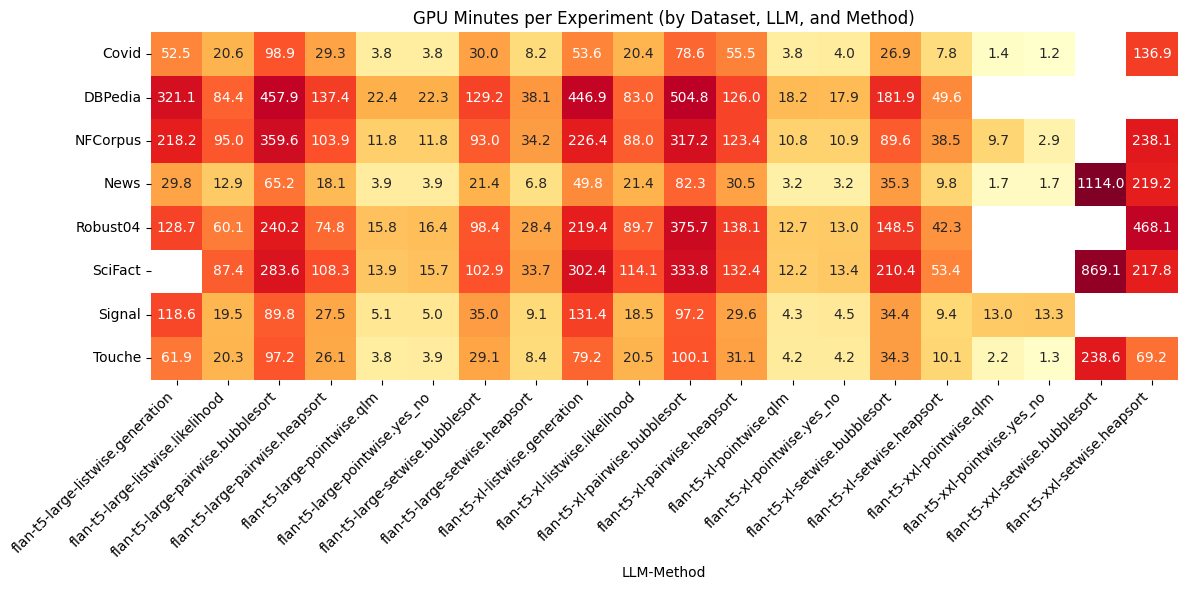

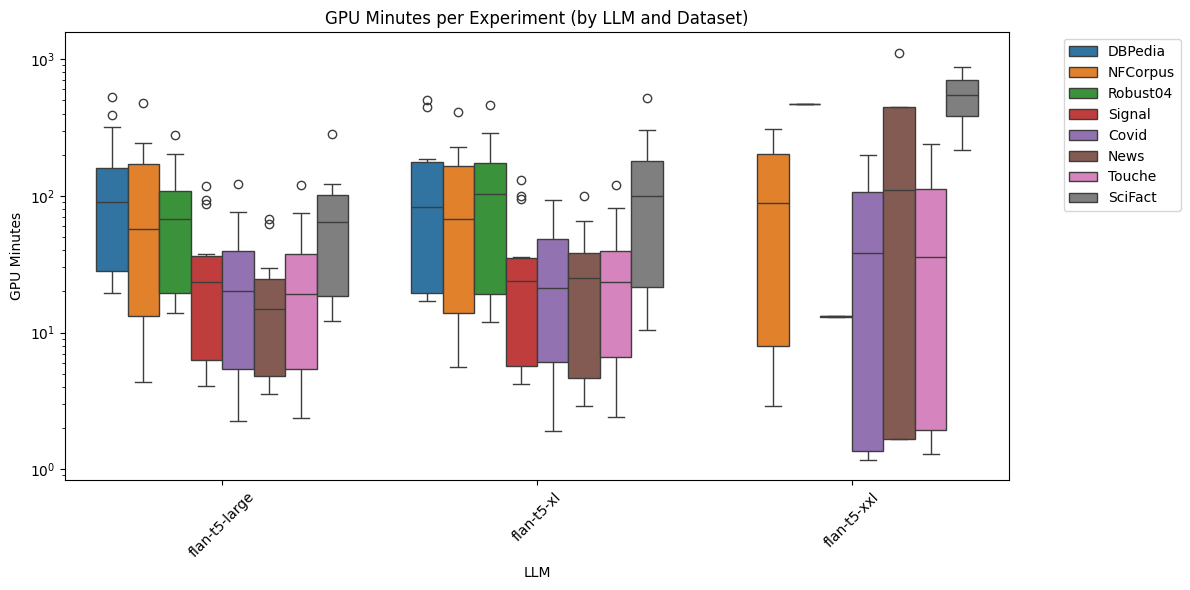

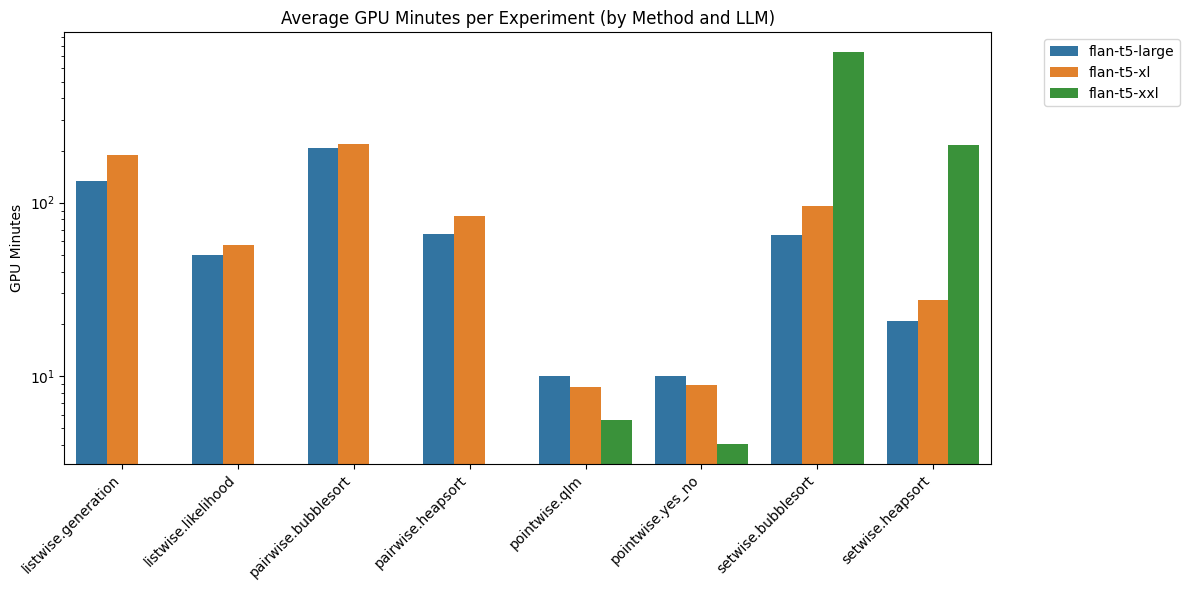

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from typing import Tuple, Dict

def analyze_gpu_minutes(df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict[str, plt.Figure]]:
    """
    Analyzes GPU time across LLMs, methods, and datasets.
    
    Args:
        df (pd.DataFrame): Input dataframe with columns Source, LLM, Dataset, Method, 
                          Metric_Name, and Metric_Value
    
    Returns:
        Tuple containing:
        - DataFrame with detailed statistics
        - Dictionary of matplotlib figures
    """
    # Filter for relevant data
    target_llms = ['flan-t5-large', 'flan-t5-xl', 'flan-t5-xxl']
    target_datasets = ['Covid', 'Signal', 'News', 'Robust04', 'NFCorpus', 
                      'Touche', 'SciFact', 'DBPedia']
    
    mask = (
        (df['Metric_Name'] == 'GPU Minutes ') &
        (df['LLM'].isin(target_llms)) &
        (df['Dataset'].isin(target_datasets))
    )
    
    filtered_df = df[mask].copy()
    
    # Create pivot table for analysis
    pivot_table = pd.pivot_table(
        filtered_df,
        values='Metric_Value',
        index=['Dataset', 'Method'],
        columns=['LLM'],
        aggfunc='mean'
    ).round(2)
    
    # Reset index for better display
    pivot_table = pivot_table.reset_index()
    
    # Create visualizations
    # plt.style.use('seaborn')
    figures = {}
    
    # 1. Heatmap
    fig_heatmap, ax_heatmap = plt.subplots(figsize=(hmap_width, 6))
    pivot_for_heatmap = filtered_df.pivot_table(
        values='Metric_Value',
        index='Dataset',
        columns=['LLM', 'Method'],
        # aggfunc='median'
        aggfunc='mean'
    )
    
    log_data = np.log1p(pivot_for_heatmap)  # log1p adds 1 before taking log to handle zeros

    sns.heatmap(log_data, 
                cmap='YlOrRd', 
                # annot=True, 
                annot=pivot_for_heatmap, 
                fmt='.1f',
                cbar=False,
                # cbar_kws={'label': 'GPU Minutes (minutes)'},
                # cbar_kws={'label': 'GPU Minutes (log scale)'},
                ax=ax_heatmap)
    
    plt.ylabel('')  # Remove y-label
    plt.title('GPU Minutes per Experiment (by Dataset, LLM, and Method)')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0, ha='right')
    plt.tight_layout()
    figures['heatmap'] = fig_heatmap

    filename = f'doc/_generated/gpu_mins_heatmap.png'
    plt.savefig(filename, bbox_inches='tight', dpi=150)
    
    # 2. Box plot
    fig_box, ax_box = plt.subplots(figsize=(12, 6))
    sns.boxplot(data=filtered_df, 
                x='LLM', 
                y='Metric_Value',
                hue='Dataset',
                ax=ax_box)
    
    plt.title('GPU Minutes per Experiment (by LLM and Dataset)')
    plt.ylabel('GPU Minutes')
    plt.yscale('log')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    figures['boxplot'] = fig_box

    filename = f'doc/_generated/gpu_mins_boxplot.png'
    plt.savefig(filename, bbox_inches='tight', dpi=150)

    
    # 3. Bar plot
    fig_bar, ax_bar = plt.subplots(figsize=(12, 6))
    sns.barplot(data=filtered_df,
                x='Method',
                y='Metric_Value',
                hue='LLM',
                # ci=None,
                errorbar=None,
                ax=ax_bar)
    
    plt.title('Average GPU Minutes per Experiment (by Method and LLM)')
    plt.ylabel('GPU Minutes')
    plt.yscale('log')
    plt.xlabel('')  # Remove x-label
    # plt.ylabel('')  # Remove y-label
    plt.xticks(rotation=45, ha='right')
    # plt.yticks(rotation=45, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    figures['barplot'] = fig_bar
    
    filename = f'doc/_generated/gpu_mins_barplot.png'
    plt.savefig(filename, bbox_inches='tight', dpi=150)

    return pivot_table, figures

def print_summary_stats(df: pd.DataFrame) -> None:
    """
    Prints summary statistics for the filtered data
    """
    mask = (
        (df['Metric_Name'] == 'GPU Minutes ') &
        (df['LLM'].isin(['flan-t5-large', 'flan-t5-xl', 'flan-t5-xxl'])) &
        (df['Dataset'].isin(['Covid', 'Signal', 'News', 'Robust04', 'NFCorpus', 
                            'Touche', 'SciFact', 'DBPedia']))
    )
    
    filtered_df = df[mask]
    
    print("\nSummary Statistics:")
    print("-" * 50)
    print(f"Total number of measurements: {len(filtered_df)}")
    print("\nMean GPU time by LLM:")
    print(filtered_df.groupby('LLM')['Metric_Value'].mean().round(2))
    print("\nMean GPU time by Dataset:")
    print(filtered_df.groupby('Dataset')['Metric_Value'].mean().round(2))
    print("\nMean GPU time by Method:")
    print(filtered_df.groupby('Method')['Metric_Value'].mean().round(2))


# print_summary_stats(adjusted_df)


# Display the figures
for fig in analyze_gpu_minutes(adjusted_df):
    plt.show()
